In [1]:
# MASTER_subsampling script

#--------------------------------------------------------------
## using Rödenbeck product with OCIM prior
#--------------------------------------------------------------
## and using Landschützer with FESOM kw
#--------------------------------------------------------------

# a couple of typical settings just in case they may be useful here, too

%autosave 10

import sys
import os
sys.path.append('../')

import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from netCDF4 import Dataset
#import gcb_iav
from annualmean import annualmean
from integrate_CO2flux import integrate_CO2flux
#from regional_average_pCO2 import reg_ave_pCO2  # this one doesn't work (total area is calculated also where there is no data, hence means become too small)

from matplotlib.pyplot import cm
from numpy import genfromtxt #loadtxt
from matplotlib.ticker import MultipleLocator
import seawater as sw
import scipy.signal

import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


import calendar
import matplotlib.patches as mpatches


# experiments:
# A, B, C

# A: SOCAT only
# B: SOCAT+SOCCOM
# C: ARGO


# Rödenbeck: 1958 - 2019
# Landschützer: 1982 - 2018 (?, 444 monthly entries)


SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Autosaving every 10 seconds
[NbConvertApp] Converting notebook annualmean.ipynb to python
[NbConvertApp] Writing 2130 bytes to annualmean.py
[NbConvertApp] Converting notebook integrate_CO2flux.ipynb to python
[NbConvertApp] Writing 5022 bytes to integrate_CO2flux.py


(756, 180, 360)
[  0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5
  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5
  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5  35.5
  36.5  37.5  38.5  39.5  40.5  41.5  42.5  43.5  44.5  45.5  46.5  47.5
  48.5  49.5  50.5  51.5  52.5  53.5  54.5  55.5  56.5  57.5  58.5  59.5
  60.5  61.5  62.5  63.5  64.5  65.5  66.5  67.5  68.5  69.5  70.5  71.5
  72.5  73.5  74.5  75.5  76.5  77.5  78.5  79.5  80.5  81.5  82.5  83.5
  84.5  85.5  86.5  87.5  88.5  89.5  90.5  91.5  92.5  93.5  94.5  95.5
  96.5  97.5  98.5  99.5 100.5 101.5 102.5 103.5 104.5 105.5 106.5 107.5
 108.5 109.5 110.5 111.5 112.5 113.5 114.5 115.5 116.5 117.5 118.5 119.5
 120.5 121.5 122.5 123.5 124.5 125.5 126.5 127.5 128.5 129.5 130.5 131.5
 132.5 133.5 134.5 135.5 136.5 137.5 138.5 139.5 140.5 141.5 142.5 143.5
 144.5 145.5 146.5 147.5 148.5 149.5 150.5 151.5 152.5 153.5 154.5 155.5
 156.5 157.5 158.5 159.5 160.5 161.

<ipython-input-2-a48820d755c8>:72: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(reg_lon,reg_lat,reg_arc)#, vmin=-60, vmax=750)


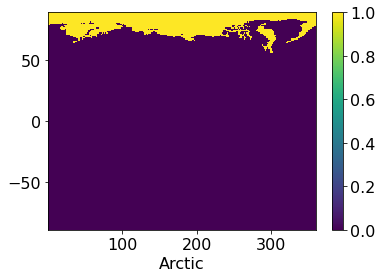

In [2]:
# some definitions, time and area

firstyear=1958
lastyear=2021 # always one more than actually analysed

#define time range for nc data 
gcb_time = np.arange(firstyear,lastyear-1./24,step=1./12)
tsteps = (lastyear-firstyear)*12
gcb_years = np.arange(firstyear,lastyear)

# print(np.shape(gcb_time))
# print(tsteps)
# print(gcb_years,np.shape(gcb_years))
# print(gcb_time)

#### initializing Area matrix
xax = np.arange(0.5,360.5,1)
yax = np.arange(-89.5,90.5,1)

xi = np.arange(-180,181,1) #longitude
yi = np.arange(-90,91,1) #latitude
Aarea = np.zeros((len(xi)-1,len(yi)-1))

#calculate area
for i in range(0,len(xi)-1): #laenge pruefen!
    for j in range(0,len(yi)-1): #laenge pruefen!
       #sw_dist aus matlab umsetzen
       dist1 = sw.dist([yi[j],yi[j+1]],[xi[i],xi[i]])
       dist2 = sw.dist([yi[j],yi[j]],[xi[i],xi[i+1]])
       Aarea[i][j] = float(dist1[0]) * float(dist2[0]) *1000 *1000 #m2
#flachen ueberall gleich gross?
Aarea = Aarea.transpose()    

areaT = np.tile(Aarea,(tsteps,1,1))


#print(np.shape(Aarea),np.shape(areaT))

indglob = np.where(yax < 90) 
indN = np.where((yax > 30) & (yax < 90)) 
indS = np.where((yax < -30) & (yax > -90)) 
indT = np.where((yax>-30) & (yax<30))

nt=tsteps
nx=len(xax)
ny=len(yax)

yax2=yax[np.newaxis,:,np.newaxis]
YY = np.tile(yax2,(nt,1,nx))

maskG = (YY[:] < 90)
maskN = ((YY[:]>30))
maskN60 = ((YY[:]>30)& (YY[:] <= 60))
maskArc = (YY[:]>60)
maskS = (YY[:]<-30)
maskT = ((YY[:]>-30) & (YY[:] < 30))

print(np.shape(maskN))

# load reccap regions mask:

regions = Dataset('/work/ollie/jhauck/reccap/RECCAP2-shared-resources/data/regions/RECCAP2_region_masks_all.nc',mode='r')
reg_lon = regions['lon'][:]
reg_lat = regions['lat'][:]
reg_arc = regions['arctic'][:]
reg_arc[reg_arc>0]=1
reg_arcT = np.tile(reg_arc,(nt,1,1))

print(reg_lon, reg_lat)

plt.figure()
plt.pcolor(reg_lon,reg_lat,reg_arc)#, vmin=-60, vmax=750)
plt.colorbar()
plt.xlabel('Arctic')
plt.show()

In [3]:
# for fesom, 12 time-steps less

fYY = np.tile(yax2,(nt-12,1,nx))
print(np.shape(fYY))

fareaT = np.tile(Aarea,(tsteps-12,1,1))
print(np.shape(fareaT))

freg_arcT =np.tile(reg_arc,(nt-12,1,1))
print(np.shape(freg_arcT))

(744, 180, 360)
(744, 180, 360)
(744, 180, 360)


In [4]:
print(61*12)

732


In [5]:
# print(gcb_years)
# print(gcb_years[24])
# print(gcb_years[61])
# print(tsteps)
# print(gcb_time)

# print(gcb_time[24*12+1])
# print(gcb_time[61*12])


ind1 = 24*12      # start index, monthly time-series, 1982
ind2 = 61*12   # end index, monthly time-series, end 2018

#print(gcb_time[51*12+1])
ind2009 = 51*12

#print(ind1,ind2,ind2009)

#print(np.shape(gcb_time[ind1:ind2]),np.shape(gcb_time[ind2009:ind2]))
print(gcb_time[24*12])
print(gcb_time[ind1:ind2])

indx = np.where((gcb_time>1981.95) & (gcb_time<2019))
print(gcb_time[indx])
print(indx)


# first again some definitions:
# for annual data!!!!

ind = np.where((gcb_years>=2009) & (gcb_years<=2018))
print(ind,gcb_years[ind])

# for trend 2000 - 2018:

ind2000 = np.where((gcb_years>=2000) & (gcb_years<=2018))
print(ind2000,gcb_years[ind2000])

# common years 1982 to 2018
ind_com = np.where((gcb_years>=1982) & (gcb_years<=2018))

# for monthly data:
ind_2009_2018_monthly = np.where((gcb_time>=2008.99) & (gcb_time<2018.95))
print(gcb_time[ind_2009_2018_monthly], np.shape(gcb_time[ind_2009_2018_monthly]))


1981.9999999999782
[1982.         1982.08333333 1982.16666667 1982.25       1982.33333333
 1982.41666667 1982.5        1982.58333333 1982.66666667 1982.75
 1982.83333333 1982.91666667 1983.         1983.08333333 1983.16666667
 1983.25       1983.33333333 1983.41666667 1983.5        1983.58333333
 1983.66666667 1983.75       1983.83333333 1983.91666667 1984.
 1984.08333333 1984.16666667 1984.25       1984.33333333 1984.41666667
 1984.5        1984.58333333 1984.66666667 1984.75       1984.83333333
 1984.91666667 1985.         1985.08333333 1985.16666667 1985.25
 1985.33333333 1985.41666667 1985.5        1985.58333333 1985.66666667
 1985.75       1985.83333333 1985.91666667 1986.         1986.08333333
 1986.16666667 1986.25       1986.33333333 1986.41666667 1986.5
 1986.58333333 1986.66666667 1986.75       1986.83333333 1986.91666667
 1987.         1987.08333333 1987.16666667 1987.25       1987.33333333
 1987.41666667 1987.5        1987.58333333 1987.66666667 1987.75
 1987.83333333 1987.

In [6]:
# load data


# for Landschützer, units (originally in mol/m2/yr , but in loading routine converted to /s, ok.)

# now the _fesom_kw version for CO2 flux; pCO2 is from the old files as it is the same and not provded with the updated flux files

land_fgco2_1x1_A = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_fgco2_1x1_A_fesom_kw_subsampling.npy')
land_fgco2_1x1_A[ind1:ind2,:,:] = tmp1
print(np.shape(tmp1))

land_fgco2_1x1_B = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_fgco2_1x1_B_fesom_kw_subsampling.npy')
land_fgco2_1x1_B[ind1:ind2,:,:] = tmp1
print(np.shape(tmp1))

land_fgco2_1x1_C = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_fgco2_1x1_C_fesom_kw_subsampling.npy')
land_fgco2_1x1_C[ind1:ind2,:,:] = tmp1
print(np.shape(tmp1))



# spco2:
land_spco2_1x1_A = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_spco2_1x1_A_subsampling.npy')
land_spco2_1x1_A[ind1:ind2,:,:] = tmp1
print(np.shape(tmp1))

land_spco2_1x1_B = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_spco2_1x1_B_subsampling.npy')
land_spco2_1x1_B[ind1:ind2,:,:] = tmp1
print(np.shape(tmp1))

land_spco2_1x1_C = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_spco2_1x1_C_subsampling.npy')
land_spco2_1x1_C[ind1:ind2,:,:] = tmp1
print(np.shape(tmp1))



(444, 180, 360)
(444, 180, 360)
(444, 180, 360)
(444, 180, 360)
(444, 180, 360)
(444, 180, 360)


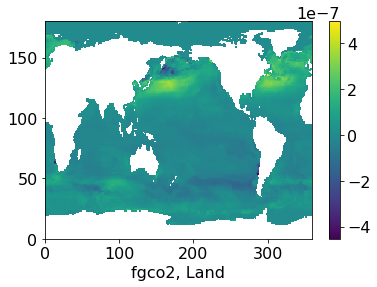

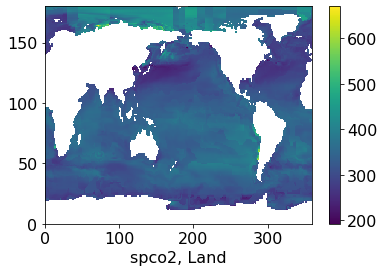

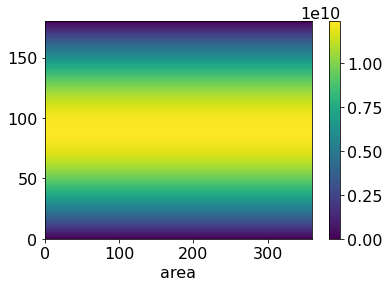

numpy.ndarray

In [7]:

# fig = plt.subplots(1, 1)
# c=plt.pcolor(land_fgco2_1x1_A[ind1,:,:])
# fig.colorbar()
# plt.show()


plt.figure()
#plt.subplot(2,2,3)
plt.pcolor(np.squeeze(land_fgco2_1x1_A[ind1,:,:]))#, vmin=-60, vmax=750)
plt.colorbar()
plt.xlabel('fgco2, Land')
plt.show()

plt.figure()
#plt.subplot(2,2,3)
plt.pcolor(np.squeeze(land_spco2_1x1_A[ind1,:,:]))#, vmin=-60, vmax=750)
plt.colorbar()
plt.xlabel('spco2, Land')
plt.show()


plt.figure()
#plt.subplot(2,2,3)
plt.pcolor(np.squeeze(areaT[ind1,:,:]))#, vmin=-60, vmax=750)
plt.colorbar()
plt.xlabel('area')
plt.show()

type(land_spco2_1x1_A)

(756, 180, 360)
(120, 180, 360)


<ipython-input-8-305f06460f15>:19: RuntimeWarning: Mean of empty slice
  roeden_fgco2_A_2009_2018 = np.nanmean(np.squeeze(roeden_fgco2_1x1_A[ind2009:ind2,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
<ipython-input-8-305f06460f15>:20: RuntimeWarning: Mean of empty slice
  roeden_fgco2_B_2009_2018 = np.nanmean(np.squeeze(roeden_fgco2_1x1_B[ind2009:ind2,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
<ipython-input-8-305f06460f15>:21: RuntimeWarning: Mean of empty slice
  roeden_fgco2_C_2009_2018 = np.nanmean(np.squeeze(roeden_fgco2_1x1_C[ind2009:ind2,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:27: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad('white',1.)

shape(reg_arcT) (756, 180, 360)
region global
shape(mask) (756, 180, 360)


/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:116: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(reg_lon,reg_lat,np.squeeze(mask[1,:,:]))#, vmin=-60, vmax=750)


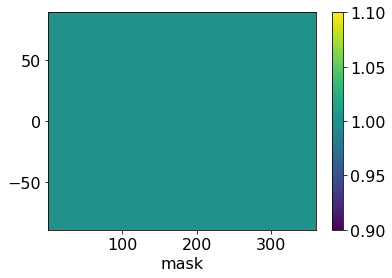

global
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
True
True
True
0 [0.0687506140806387 -0.5242402944618835 -0.4744841637683781
 -0.21512357428666815 -0.29614066168564984 -0.19381034220511448
 0.04302749342172805 0.15365994720588452 0.284496580951047
 0.7170150573779445 0.8527351007512932 0.9754795499815679]
1 [0.574598150788939 0.13531014907140912 0.10710745785261896
 0.1160224305893005 0.11551998898004098 0.3108415489535515
 0.34760743365058033 0.33103807628890175 0.3889777903203143
 0.8265457678094034 1.2922493390334275 1.273383289455106]
2 [0.872111912249219 0.31783238732119623 0.24094564919969141
 0.3514202999928202 0.29126368676660386 0.31405574679969683
 0.3929763176826969 0.18743515079120474 0.39662766767518187
 0.6392004866219392 1.0399263073465301 1.2223342746319499]
3 [0.835254836960267 0.39009610247994225 0.26616286585603577
 0.3524461875969793 0.26016941791789655 0.1954511692062009
 0.22767227896199 0.17060275453489654 0.33988230074800396
 0.9139588936150438 1.124

shape(reg_arcT) (756, 180, 360)
region glo_noArc
shape(mask) (756, 180, 360)


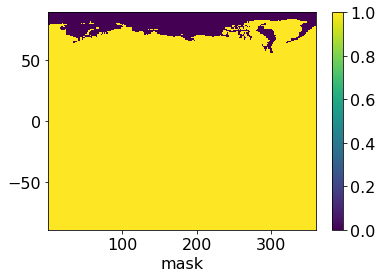

glo_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [0.04146653379892435 -0.5505065654609671 -0.5002223454251821
 -0.2397283163459223 -0.32716745837855177 -0.23201580095378627
 -0.004768290597190761 0.08572435510436499 0.22635164741473635
 0.6862378960684319 0.8193810223987308 0.9389170866784211]
1 [0.5379919083957299 0.0954201114232744 0.06738289571192696
 0.08619154230137623 0.08423605997936849 0.266599337634777
 0.2934636698270361 0.2582590906103662 0.33067252436426137
 0.7763955036413364 1.246306240824142 1.2295390370688715]
2 [0.8324676259277349 0.2836852667032674 0.20606687219455727
 0.31559155730139343 0.2545741573881632 0.2689084692994329
 0.3508006554143097 0.14466462444895012 0.37109810969268714
 0.5977281124688585 0.9979240429779417 1.178208177464647]
3 [0.798249427175568 0.3581939716499025 0.23670421882117332
 0.32356772448392873 0.23365690223559343 0.16704597106697278
 0.1979942129341364 0.133062739819206 0.3059894637842147
 0.8746775864249956

shape(reg_arcT) (756, 180, 360)
region N_noArc
shape(mask) (756, 180, 360)


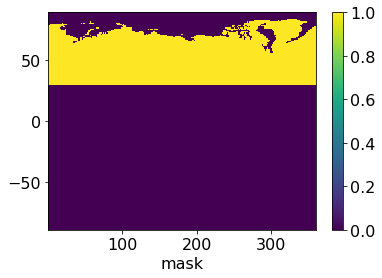

N_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.6328261598498985 1.6323256895131766 1.601162057548159
 1.4547585368965592 0.9072898686839981 0.2696580499957319
 -0.3032281382745376 -0.6619420402225684 -0.5960712350129135
 -0.031414628778820695 0.7063356936010007 1.3948177070144667]
1 [1.7323532853351278 1.8065977508031759 1.84464500495267 1.5089110644385857
 0.9273959663219793 0.350684089216265 -0.2627738098918569
 -0.6492610375239168 -0.6027576338842939 0.0482916555363874
 0.9145852149715741 1.5793264790716584]
2 [1.8118380679565793 1.8742990771423125 1.836576783581469
 1.5778991418172243 1.0323258438278895 0.3525528120760143
 -0.2739502001023671 -0.6589470291646846 -0.5706107335804598
 -0.08320115942462557 0.7772062410070171 1.4957666490109978]
3 [1.8375336342091861 1.9356541280221249 1.8454788077886697
 1.5558133684101714 1.0140011857160336 0.32622758666080987
 -0.2875671112122963 -0.62076154153315 -0.520613635787311
 0.04906026974135235 0.78532689

shape(reg_arcT) (756, 180, 360)
region N
shape(mask) (756, 180, 360)


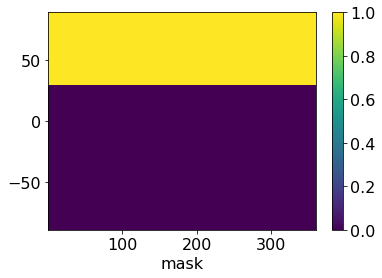

N
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.660110240131613 1.6585919605122603 1.626900239204963 1.4793632789558135
 0.9383166653769 0.30786350874440355 -0.25543235425561883
 -0.594006448121049 -0.5379263014766028 -0.0006374674693079826
 0.7396897719535632 1.4313801703176134]
1 [1.768959527728337 1.8464877884513102 1.8843695670933616
 1.5387419527265103 0.9586798953226516 0.3949263005350394
 -0.20863004606831248 -0.576482051845381 -0.5444523679282409
 0.09844191970445448 0.9605283131808594 1.6231707314578931]
2 [1.8514823542780638 1.908446197760241 1.871455560586603 1.613727884508651
 1.06901537320633 0.39770008957627817 -0.23177453783397975
 -0.61617650282243 -0.545081175597965 -0.04172878527154477
 0.8192085053756052 1.5398927461783007]
3 [1.874539043993885 1.9675562588521647 1.874937454823532 1.5846918315232221
 1.0405137013983368 0.35463278480003796 -0.25788904518444256
 -0.5832215268174595 -0.48672079882352187 0.08834157693140042
 0.836841985964114

shape(reg_arcT) (756, 180, 360)
region Arc
shape(mask) (756, 180, 360)


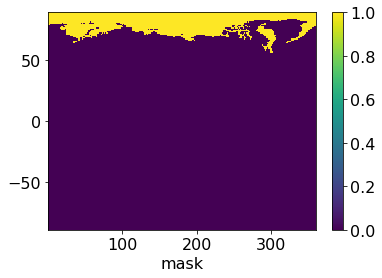

Arc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [0.027284080281714196 0.02626627099908398 0.025738181656803454
 0.02460474205925405 0.031026796692902 0.0382054587486717
 0.0477957840189187 0.06793559210151948 0.05814493353631061
 0.030777161309512715 0.03335407835256252 0.03656246330314668]
1 [0.036606242393209365 0.03989003764813469 0.039724562140691574
 0.029830888287924195 0.03128392900067252 0.04424221131877445
 0.05414376382354437 0.07277898567853568 0.05830526595605296
 0.05015026416806707 0.04594309820928516 0.043844252386234586]
2 [0.03964428632148445 0.034147120617928316 0.03487877700513476
 0.03582874269142666 0.036689529378440645 0.04514727750026383
 0.042175662268387364 0.042770526342254776 0.025529557982494837
 0.0414723741530808 0.042002264368588414 0.04412609716730295]
3 [0.037005409784699045 0.031902130830039836 0.02945864703486258
 0.02887846311305051 0.02651251568230322 0.028405198139228132
 0.029678066027853816 0.03754001471569058 0.033892

shape(reg_arcT) (756, 180, 360)
region T
shape(mask) (756, 180, 360)


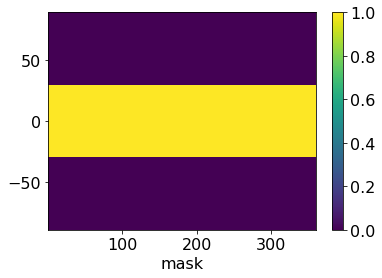

T
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-0.9528766596252463 -1.0975036476898898 -1.008872879420915
 -1.061228153808114 -1.2133189099928081 -1.0912332626235755
 -0.7727500069806557 -0.6014247247837308 -0.608112521315713
 -0.677928605790871 -0.8040201534710949 -0.7869203254790826]
1 [-0.880444811455281 -0.9257752662863191 -0.98143237090388
 -1.0621294084581565 -1.0407425023070438 -0.8286699278751956
 -0.6515545526289904 -0.5876788933044134 -0.6362840835546444
 -0.764456986556913 -0.8166524282497124 -0.8254534316285351]
2 [-0.7631399698633142 -0.8307880630882405 -0.8266314327282854
 -0.8999096397382751 -1.050670877501639 -0.9169927876310654
 -0.6573008219805284 -0.5940235230458446 -0.5811994232459113
 -0.713043945882415 -0.8242150309793423 -0.7593310260524976]
3 [-0.8114732554285546 -0.9238378371450878 -0.9094394046274082
 -0.9332664449232089 -1.0575874103683072 -1.00652084264887
 -0.7425457220223991 -0.6658593888339214 -0.7096159692395458
 -0.6727917292

shape(reg_arcT) (756, 180, 360)
region S
shape(mask) (756, 180, 360)


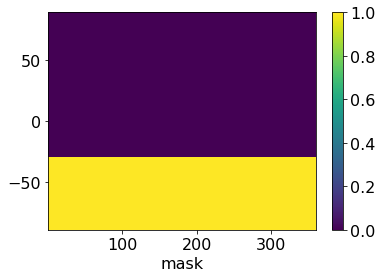

S
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-0.6384829664257282 -1.0853286072842543 -1.0925115235524263
 -0.6332586994343672 -0.021138417069741622 0.5895594116740575
 1.0712098546580024 1.3490911201106643 1.430535403743363
 1.3955811306381236 0.917065482268825 0.3310197051430374]
1 [-0.31391656548411717 -0.785402373093582 -0.7958297383368625
 -0.36059011367905325 0.197582595964433 0.7445851762937076
 1.207792032347883 1.4951990214386959 1.5697142418031997 1.492560834661862
 1.1483734541022803 0.47566598962574785]
2 [-0.21623047216553 -0.7598257473508042 -0.803878478658627
 -0.36239794477755577 0.2729191910619125 0.8333484448544843
 1.282051677497205 1.3976351766594795 1.522908266519058 1.3939732177758992
 1.044932832950267 0.4417725545061466]
3 [-0.22781095160506337 -0.6536223192271348 -0.6993351843400883
 -0.2989791990030339 0.27724312688786695 0.8473392270550331
 1.2281070461688315 1.4196836701862774 1.536219068811071 1.498409045927783
 1.04918194022603

shape(reg_arcT) (756, 180, 360)
region global
shape(mask) (756, 180, 360)


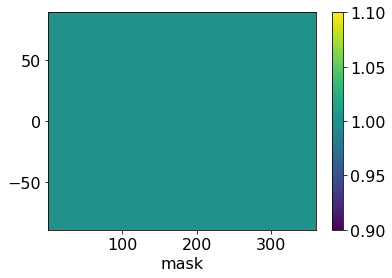

global
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
True
True
True
0 [0.1638339434763602 -0.4088021293300102 -0.3893782222668035
 -0.1639761751124686 -0.25466072799165 -0.17921796200420115
 0.025620779994197717 0.09346769389798132 0.20650134091028208
 0.6582222050194284 0.8049606001451431 0.9548719191888738]
1 [0.5904682497556386 0.18009972306462604 0.13921324536826762
 0.13019360757113407 0.12485822219412851 0.31262654561766384
 0.3266283604667707 0.26865066436229323 0.30806007964962656
 0.7660542091484156 1.2276764186537095 1.229613814749078]
2 [0.8599172504372841 0.3294977405081592 0.2414214753715355
 0.33831819900390137 0.287160502097919 0.3061985007424241
 0.36080100817186045 0.12836489329607853 0.32479857326705946
 0.5829513086400225 0.9856707758455672 1.1849178314864393]
3 [0.8431378579164814 0.416666820088417 0.27454325298562265
 0.33671494182635897 0.2515674400544402 0.18252327707719324
 0.19097809761325393 0.09336614730523457 0.26534275688573467
 0.8514136104804657 1.

shape(reg_arcT) (756, 180, 360)
region glo_noArc
shape(mask) (756, 180, 360)


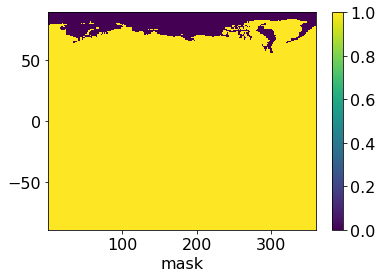

glo_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [0.13655623876931566 -0.4350603391816019 -0.4151097531283158
 -0.18857681803096468 -0.28567473663454696 -0.217367307504774
 -0.022089221465780975 0.025653896856287058 0.1485211589093823
 0.6275349767395961 0.7716298940497203 0.9183160294112568]
1 [0.5538661807267269 0.14021919629278934 0.09950010228143079
 0.10037401659781449 0.09359399396572222 0.26843438597133085
 0.27257176936833244 0.19595651363599387 0.24984182822934664
 0.7159609261829477 1.1817653490225173 1.185784573738801]
2 [0.8202803805655601 0.29535678705159263 0.20654858169018947
 0.302495073000003 0.2504866407353532 0.26109888115786706
 0.31869150404661234 0.08565606399667446 0.2993319970677285
 0.541516440150642 0.9436819323271749 1.1407971735542644]
3 [0.8061339157590176 0.384769851251805 0.24509220975746598
 0.30784161114654257 0.22506566928816463 0.15414059157071833
 0.1613225908924997 0.05585878163726 0.2314997678275574 0.81216753664755

shape(reg_arcT) (756, 180, 360)
region N_noArc
shape(mask) (756, 180, 360)


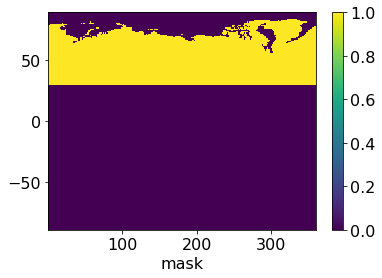

N_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.632733836849875 1.6322996632911864 1.6011584559631042
 1.4547552404421114 0.9073092428926541 0.2697010498722494
 -0.3032330755098819 -0.6620499547303536 -0.5962382337647437
 -0.03160950521103429 0.7061343021527162 1.3946659547483997]
1 [1.7322625604332624 1.806547281713048 1.8446136041856656
 1.5089024193027283 0.9274321505554513 0.35073519655365687
 -0.2627965247965206 -0.649379375246722 -0.6029205706874288
 0.04810082038399667 0.9143799286522307 1.57913708181619]
2 [1.811728623020671 1.874241706942261 1.8365542004575248 1.5778850751449987
 1.0323498176400263 0.3525903236423241 -0.27399274426282477
 -0.6590922678943862 -0.5708092438605415 -0.0833749791777813
 0.7769919812244163 1.4955873238277364]
3 [1.8374125286847192 1.9355655853762028 1.8454249279165242
 1.5557953603244155 1.0140238020324122 0.32626376249253286
 -0.2876044020944758 -0.620907043599312 -0.5208167780423494
 0.04884522780077833 0.7850982

shape(reg_arcT) (756, 180, 360)
region N
shape(mask) (756, 180, 360)


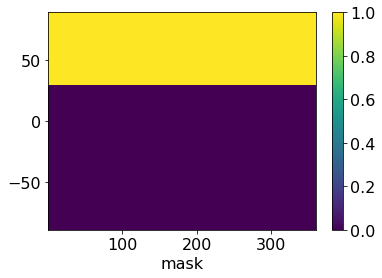

N
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.660011541556919 1.6585578731427784 1.6268899868246167
 1.4793558833606077 0.9383232515355509 0.30785039537282216
 -0.25552307404990343 -0.5942361576886594 -0.5382580517638437
 -0.0009222769312019573 0.7394650082481392 1.4312218445260168]
1 [1.7688646294621744 1.8464278084848842 1.8843267472725023
 1.538722010276048 0.9586963787838576 0.3949273561999899
 -0.20873993369808205 -0.5766852245204227 -0.544702319267149
 0.09819410334946452 0.9602909982834226 1.6229663228264666]
2 [1.8513654928923953 1.9083826603988272 1.8714270941388704
 1.6137082011488975 1.069023679002592 0.39768994322688117
 -0.2318832401375765 -0.6163834385949823 -0.5453426676612108
 -0.041940110688400874 0.8189808247428085 1.5397079817599113]
3 [1.8744164708421838 1.9674625542128141 1.874875971144681 1.584668691004232
 1.0405255727986882 0.35464644799900774 -0.2579488953737214
 -0.5833996779313372 -0.4869737889841719 0.08809130163369074
 0.83658

shape(reg_arcT) (756, 180, 360)
region Arc
shape(mask) (756, 180, 360)


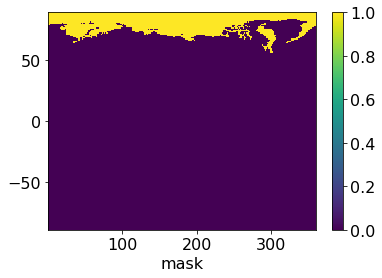

Arc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [0.027277704707044652 0.026258209851591816 0.02573153086151212
 0.024600642918496174 0.031014008642896967 0.03814934550057273
 0.04771000145997834 0.06781379704169412 0.05798018200089995
 0.030687228279832328 0.03333070609542289 0.036555889777617]
1 [0.03660206902891164 0.03988052677183637 0.03971314308683686
 0.029819590973319668 0.031264228228406236 0.044192159646333086
 0.05405659109843845 0.07269415072629921 0.05821825142027992
 0.05009328296546785 0.04591106963119191 0.04382924101027699]
2 [0.03963686987172388 0.0341409534565666 0.03487289368134626
 0.035823126003898476 0.03667386136256591 0.04509961958455708
 0.04210950412524829 0.04270882929940408 0.025466576199330966
 0.04143486848938044 0.04198884351839221 0.044120657932175004]
3 [0.03700394215746417 0.0318969688366118 0.029451043228156934
 0.02887333067981622 0.02650177076627559 0.028382685506474874
 0.029655506720754458 0.03750736566797475 0.03384298

shape(reg_arcT) (756, 180, 360)
region T
shape(mask) (756, 180, 360)


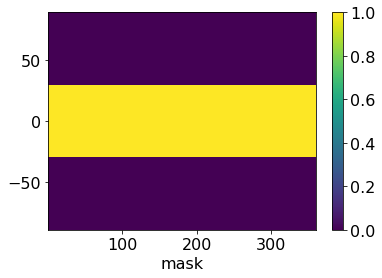

T
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-0.9388443319838805 -1.080433632364466 -0.9974813786964042
 -1.0536127555690593 -1.202949987828185 -1.08137600230563
 -0.7669410545428048 -0.5975947436573039 -0.6012893142295603
 -0.668174082903254 -0.7968572832652367 -0.7800143829594666]
1 [-0.8699544346783934 -0.9153127546694809 -0.974470720135702
 -1.0564687263261447 -1.0324547090307126 -0.8198183494851848
 -0.6461858841141469 -0.5843444764094617 -0.6306207696378014
 -0.7570900543231128 -0.8105189178148815 -0.822823552695176]
2 [-0.7591321217616633 -0.8218568276945885 -0.8205159414462049
 -0.8960935603739 -1.0430448000832218 -0.9079802016357665
 -0.6520722862238486 -0.5903168204338574 -0.5745963417419312
 -0.7043641216164002 -0.8188544562993403 -0.7578794264772788]
3 [-0.8068620674510437 -0.9176068542454253 -0.9048709650078315
 -0.9293467401340693 -1.0511804457985874 -0.9997120669829999
 -0.7391782840953295 -0.6641295735331667 -0.7053109553616892
 -0.66583964

shape(reg_arcT) (756, 180, 360)
region S
shape(mask) (756, 180, 360)


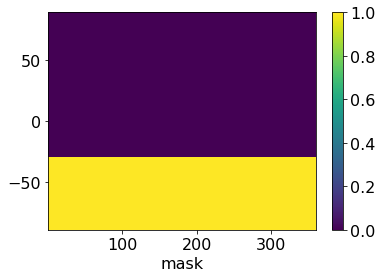

S
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-0.5573332660966788 -0.986926370108322 -1.018786830395016
 -0.5897193029040169 0.009966008300983866 0.5943076449286067
 1.0480849085869057 1.2852985952439446 1.3460487069036864
 1.3273185648538846 0.8623528751622409 0.30366445762232364]
1 [-0.308441945028142 -0.751015330750778 -0.7706427817685331
 -0.3520596763787691 0.1986165524409833 0.7375175389028588
 1.1815541782789996 1.4296803652921775 1.483383168554577
 1.4249501601220642 1.077904338185168 0.429471044617787]
2 [-0.23231612069344756 -0.7570280921960799 -0.8094896773211301
 -0.3792964417710957 0.2611816231785488 0.8164887591513094
 1.2447565345332854 1.3350651523249182 1.4447375826702016
 1.3292555409448237 0.9855444074020989 0.40308927620380686]
3 [-0.22441654547465822 -0.6331888798789722 -0.6954617531512269
 -0.31860700904380385 0.26222231305434 0.8275888960611852
 1.1881052770823048 1.3408953987697387 1.4576275012315958
 1.4291619566772098 0.99263516499

shape(reg_arcT) (756, 180, 360)
region global
shape(mask) (756, 180, 360)


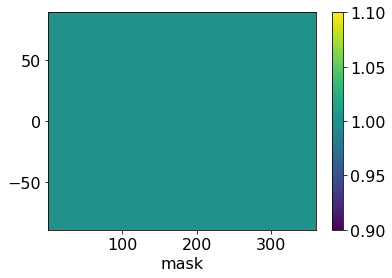

global
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
True
True
True
0 [1.040026166604287 0.5649002221039111 0.5667480185644956
 0.7728203503705309 0.7190882205742447 0.7840752833733392
 0.8511780975596753 0.7375886686193373 0.666804897109885 1.079383577938631
 1.244157044356984 1.389766271349062]
1 [1.0846394055680668 0.859992410984259 0.9024700283552914
 0.8992517774995542 0.9271575319740916 1.101673218563624 1.0220388092486
 0.8808146219013012 0.813654123485421 1.2028302299010643
 1.6895729703283724 1.6746550980482153]
2 [1.2968846661974864 0.9170015291193303 0.8564269098588906
 1.070264269037747 1.1484364100219537 1.2007157551189984
 1.1971410514848215 0.823049434477083 0.9279535980400196 1.092280536248576
 1.5091167543456507 1.6037785132264313]
3 [1.2102990611241409 0.9063890899058166 0.8003615461266702
 0.8665979083978744 0.8768976072642727 0.964049946483548
 0.9606532110427717 0.773354126543519 0.7656853168036357 1.220126670642753
 1.4637498308059895 1.5443831822565417]
4 

shape(reg_arcT) (756, 180, 360)
region glo_noArc
shape(mask) (756, 180, 360)


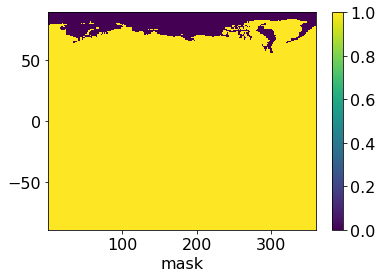

glo_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.002516745360384 0.5307956203740369 0.5364305445063764
 0.7481639158408144 0.6958470441898236 0.7778961939947355
 0.8943945895865744 0.8256751230860678 0.7182147104524921
 1.069356408940102 1.2098358500068775 1.352371269790256]
1 [1.046779985913526 0.8171933074178274 0.8641377783478983
 0.8751939754752255 0.9147967127182189 1.125360226762582
 1.0940926306919083 0.9596195496099093 0.8597027918227435
 1.2068928970725343 1.6678368955280067 1.6414278918884087]
2 [1.2630106226600166 0.8815560081505949 0.8217108671489044
 1.038096247882612 1.1325397521561598 1.2181882894271923 1.254834628239143
 0.8927980364133979 0.9504405842445773 1.088305279129462
 1.4955351877977876 1.5746342817800973]
3 [1.1815869935656855 0.879708495053425 0.7788623404664982
 0.8507519029779087 0.8661210198913252 0.9757315481600793 1.02319638160175
 0.8350517757526974 0.7896661612256641 1.2084332917256504
 1.4304920064921465 1.511636994

shape(reg_arcT) (756, 180, 360)
region N_noArc
shape(mask) (756, 180, 360)


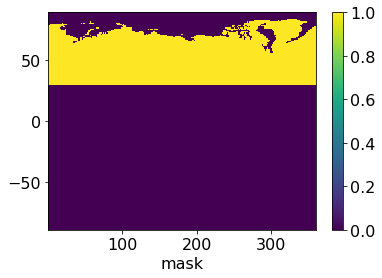

N_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.8764257448716548 1.8474470366306635 1.7650496240186195
 1.550703746541929 0.9816363529208907 0.356060441765668
 -0.15230674573396494 -0.44334222088627623 -0.3620738149750004
 0.17627710553998457 0.8358540294765838 1.4711581335632324]
1 [1.7968765666827293 1.907281644054534 1.930866325117777 1.568419808340093
 0.9918148373132906 0.44872031215816227 -0.11085352863583925
 -0.4132811780840086 -0.32812143681759626 0.26848015993961405
 1.021048905641948 1.5597283707848992]
2 [1.7381643970644516 1.8152872150593773 1.7635433070265936
 1.539630647336953 1.0678071084067158 0.45744848541321004
 -0.10843707967150511 -0.43038823165973433 -0.3243356333352716
 0.12544757216277705 0.9285835604402957 1.5522496996108852]
3 [1.8498475901705806 1.9663337638929543 1.870034412748235
 1.5589179582036063 1.027169714318712 0.37801261663848656
 -0.17433393056338986 -0.4263544988182018 -0.31297460525485676
 0.19510594947941653 0.8

shape(reg_arcT) (756, 180, 360)
region N
shape(mask) (756, 180, 360)


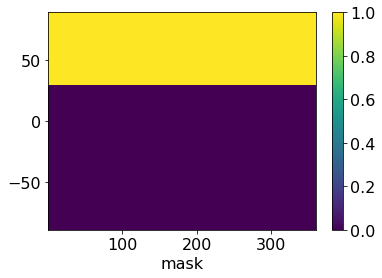

N
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.9139351661155573 1.8815516383605373 1.7953670980767387
 1.5753601810716455 1.0048775293053118 0.3622395311442716
 -0.19552323776086386 -0.5314286753530068 -0.41348362831760765
 0.1863042745385138 0.8701752238266902 1.5085531351220383]
1 [1.8347359863372703 1.9500807476209654 1.9691985751251702
 1.5924776103644225 1.0041756565691633 0.42503330395920447
 -0.1829073500791476 -0.49208610579261636 -0.37417010515491866
 0.264417492768144 1.0427849804423137 1.5929555769447061]
2 [1.7720384406019214 1.8507327360281127 1.79825934973658 1.571798668492088
 1.0837037662725097 0.43997595110501614 -0.16613065642582667
 -0.5001368335960494 -0.34682261953982946 0.12942282928189103
 0.9421651269881591 1.5813939310572194]
3 [1.8785596577290364 1.993014358745346 1.8915336184084066
 1.5747639636235722 1.0379463016916592 0.3663310149619553
 -0.2368771011223681 -0.4880521480273802 -0.33695544967688523
 0.2067993283965191 0.90757511

shape(reg_arcT) (756, 180, 360)
region Arc
shape(mask) (756, 180, 360)


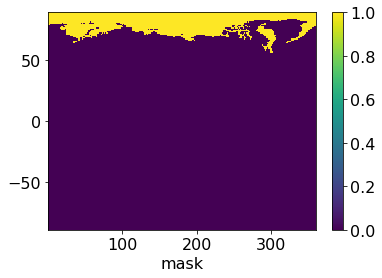

Arc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [0.03750942124390308 0.034104601729874305 0.03031747405811966
 0.02465643452971622 0.023241176384421105 0.0061790893786036845
 -0.04321649202689898 -0.08808645446673052 -0.051409813342607344
 0.010027168998529241 0.03432119435010654 0.03739500155880607]
1 [0.03785941965454067 0.04279910356643119 0.038332250007393175
 0.024057802024328872 0.012360819255872691 -0.023687008198957842
 -0.07205382144330835 -0.07880492770860781 -0.04604866833732236
 -0.004062667171470011 0.02173607480036568 0.03322720615980658]
2 [0.03387404353746987 0.035445520968734594 0.034716042709986523
 0.0321680211551351 0.01589665786579403 -0.017472534308193805
 -0.057693576754321546 -0.06974860193631516 -0.02248698620455782
 0.003975257119113914 0.013581566547863211 0.02914423144633404]
3 [0.028712067558455144 0.026680594852391857 0.021499205660171626
 0.015846005419965913 0.010776587372947356 -0.011681601676531173
 -0.06254317055897823 -0.0

shape(reg_arcT) (756, 180, 360)
region T
shape(mask) (756, 180, 360)


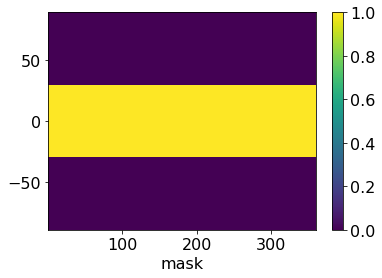

T
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-0.7180745673678121 -0.8313675421584072 -0.8139248096376247
 -0.851525608437307 -0.937273822912496 -0.7746812642118074
 -0.4660423027262973 -0.33671013606707184 -0.42343428910207254
 -0.5314822490634876 -0.6425140780502548 -0.6204769627301288]
1 [-0.636900686908922 -0.6154245881454291 -0.6620093681428005
 -0.7088522937420959 -0.6452784059215193 -0.42839784822965976
 -0.26281523701777376 -0.21156230237231474 -0.30683105174887426
 -0.47903739526342903 -0.5179055677752091 -0.5208646175379856]
2 [-0.45753612827648316 -0.4879846079871921 -0.5115005779648224
 -0.5635822189764855 -0.6379435715938686 -0.45303311203818164
 -0.1957387697462272 -0.1681194846334599 -0.2291100772268851
 -0.4127536009695627 -0.5372880342305562 -0.49926045250698603]
3 [-0.5173332233693703 -0.5979697507231446 -0.6349808596841148
 -0.6425863001124733 -0.6781116367600811 -0.5554711286128922
 -0.3021089229170556 -0.2691374000202229 -0.402931546755

shape(reg_arcT) (756, 180, 360)
region S
shape(mask) (756, 180, 360)


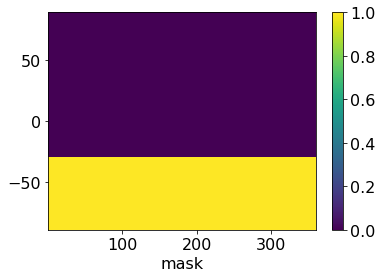

S
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-0.15583443214345893 -0.48528387409821905 -0.4146942698746184
 0.04898577773619239 0.6514845141814289 1.1965170164408752
 1.5127436380468366 1.6057274800394163 1.5037228145295651
 1.424561552463605 1.0164958985805486 0.5016900989571524]
1 [-0.11319589386028095 -0.4746637484912775 -0.4047191786270777
 0.015626460877228285 0.5682602813264478 1.1050377628340793
 1.4677613963455212 1.5844630300662326 1.4946552803892141
 1.4174501323963493 1.1646935576612678 0.602564138641495]
2 [-0.017617646127952236 -0.4457465989215906 -0.43033186191286726
 0.06204781952214453 0.7026762153433129 1.213772916052164
 1.5590104776568752 1.4913057527065923 1.5038862948067342
 1.3756113079362475 1.1042396615880476 0.5216450346761982]
3 [-0.150927373235525 -0.48865551811638464 -0.45619121259762196
 -0.0655797551132244 0.5170629423326945 1.153190060134485
 1.4996392350821954 1.530543674591122 1.5055723132360868 1.451452497440686
 1.0976384

[0.11594711 0.48493345 0.52217749 0.52111096 0.46333849 0.4730052
 0.65999462 0.56892321 0.62496921 0.62217405 0.60793401 0.65270699
 0.82728226 0.6239602  0.58948957 0.7448945  0.69598835 0.66244364
 0.68900832 0.85516012 1.01625541 1.02636067 1.33895185 1.37447713
 1.3823495  1.57363049 1.61486191 1.50861784 1.59224242 1.75128905
 1.87851508 1.75389964 1.69264255 1.80559647 2.07378943 2.09728397
 2.08375865 2.06904176 2.07773625 2.00693189 2.35285118 2.11735846
 1.9544783  1.83853254 2.24586835 2.39865469 2.23514365 2.42678165
 2.52941473 2.64400787 2.33373281 2.38857653 2.64060832 2.66365572
 2.68593849 2.6665181  2.75330126 2.75496907 3.14133575 2.94890064
 2.94392276 2.93497224 2.90570351]
(756, 180, 360)
(120, 180, 360)


<ipython-input-8-305f06460f15>:100: RuntimeWarning: Mean of empty slice
  roeden_spco2_A_2009_2018 = np.nanmean(np.squeeze(roeden_spco2_1x1_A[ind_2009_2018_monthly,:,:]),axis=0)
<ipython-input-8-305f06460f15>:101: RuntimeWarning: Mean of empty slice
  roeden_spco2_B_2009_2018 = np.nanmean(np.squeeze(roeden_spco2_1x1_B[ind_2009_2018_monthly,:,:]),axis=0)
<ipython-input-8-305f06460f15>:102: RuntimeWarning: Mean of empty slice
  roeden_spco2_C_2009_2018 = np.nanmean(np.squeeze(roeden_spco2_1x1_C[ind_2009_2018_monthly,:,:]),axis=0)


In [8]:
# now with Schmidt number
#-----------------
## here with OCIM prior
#-----------------

# # for Rödenbeck, units given as PgC/yr  for timeseries, mol/m2/yr for gridded fields (as converted to /s in load_roeden...

# gridded fields
roeden_fgco2_1x1_A = np.load('roedenSc_OCIMprior_fgco2_1x1_A_subsampling.npy')
roeden_fgco2_1x1_B = np.load('roedenSc_OCIMprior_fgco2_1x1_B_subsampling.npy')
roeden_fgco2_1x1_C = np.load('roedenSc_OCIMprior_fgco2_1x1_C_subsampling.npy')

print(np.shape(roeden_fgco2_1x1_A))

# calculate mean over 2009-2018, double-check time-entries!!!

print(np.shape(roeden_fgco2_1x1_A[ind2009:ind2,:,:])) # should be 120 time entries

roeden_fgco2_A_2009_2018 = np.nanmean(np.squeeze(roeden_fgco2_1x1_A[ind2009:ind2,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
roeden_fgco2_B_2009_2018 = np.nanmean(np.squeeze(roeden_fgco2_1x1_B[ind2009:ind2,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
roeden_fgco2_C_2009_2018 = np.nanmean(np.squeeze(roeden_fgco2_1x1_C[ind2009:ind2,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr


# integrated time-series:
#----------------------------------------------------------------------------------------------------------
# need to calculate this from 1x1 regridded field now to be able to apply Arctic mask on 1x1 degree grid


roeden_fgco2_PgCyr_A_glo= integrate_CO2flux(roeden_fgco2_1x1_A,'global',areaT,xax,yax)
roeden_fgco2_PgCyr_A_glo_noArc= integrate_CO2flux(roeden_fgco2_1x1_A,'glo_noArc',areaT,xax,yax)
roeden_fgco2_PgCyr_A_N_noArc= integrate_CO2flux(roeden_fgco2_1x1_A,'N_noArc',areaT,xax,yax)
roeden_fgco2_PgCyr_A_N= integrate_CO2flux(roeden_fgco2_1x1_A,'N',areaT,xax,yax)
#roeden_fgco2_PgCyr_A_N60= integrate_CO2flux(roeden_fgco2_1x1_A,'N60',areaT,xax,yax)
roeden_fgco2_PgCyr_A_Arc= integrate_CO2flux(roeden_fgco2_1x1_A,'Arc',areaT,xax,yax)
roeden_fgco2_PgCyr_A_T= integrate_CO2flux(roeden_fgco2_1x1_A,'T',areaT,xax,yax)
roeden_fgco2_PgCyr_A_S= integrate_CO2flux(roeden_fgco2_1x1_A,'S',areaT,xax,yax)


roeden_fgco2_PgCyr_B_glo= integrate_CO2flux(roeden_fgco2_1x1_B,'global',areaT,xax,yax)
roeden_fgco2_PgCyr_B_glo_noArc= integrate_CO2flux(roeden_fgco2_1x1_B,'glo_noArc',areaT,xax,yax)
roeden_fgco2_PgCyr_B_N_noArc= integrate_CO2flux(roeden_fgco2_1x1_B,'N_noArc',areaT,xax,yax)
roeden_fgco2_PgCyr_B_N= integrate_CO2flux(roeden_fgco2_1x1_B,'N',areaT,xax,yax)
#roeden_fgco2_PgCyr_A_N60= integrate_CO2flux(roeden_fgco2_1x1_A,'N60',areaT,xax,yax)
roeden_fgco2_PgCyr_B_Arc= integrate_CO2flux(roeden_fgco2_1x1_B,'Arc',areaT,xax,yax)
roeden_fgco2_PgCyr_B_T= integrate_CO2flux(roeden_fgco2_1x1_B,'T',areaT,xax,yax)
roeden_fgco2_PgCyr_B_S= integrate_CO2flux(roeden_fgco2_1x1_B,'S',areaT,xax,yax)

roeden_fgco2_PgCyr_C_glo= integrate_CO2flux(roeden_fgco2_1x1_C,'global',areaT,xax,yax)
roeden_fgco2_PgCyr_C_glo_noArc= integrate_CO2flux(roeden_fgco2_1x1_C,'glo_noArc',areaT,xax,yax)
roeden_fgco2_PgCyr_C_N_noArc= integrate_CO2flux(roeden_fgco2_1x1_C,'N_noArc',areaT,xax,yax)
roeden_fgco2_PgCyr_C_N= integrate_CO2flux(roeden_fgco2_1x1_C,'N',areaT,xax,yax)
#roeden_fgco2_PgCyr_A_N60= integrate_CO2flux(roeden_fgco2_1x1_A,'N60',areaT,xax,yax)
roeden_fgco2_PgCyr_C_Arc= integrate_CO2flux(roeden_fgco2_1x1_C,'Arc',areaT,xax,yax)
roeden_fgco2_PgCyr_C_T= integrate_CO2flux(roeden_fgco2_1x1_C,'T',areaT,xax,yax)
roeden_fgco2_PgCyr_C_S= integrate_CO2flux(roeden_fgco2_1x1_C,'S',areaT,xax,yax)
#----------------------------------------------------------------------------------------------------------

# keep this just for the comparison further down:
roeden_fgco2_PgCyr_A_glo_old= np.hstack([np.load('roedenSc_OCIMprior_fgco2_PgCyr_A_glo.npy')[:-1],np.nan])
roeden_fgco2_PgCyr_A_N_old= np.hstack([np.load('roedenSc_OCIMprior_fgco2_PgCyr_A_N.npy')[:-1],np.nan])
roeden_fgco2_PgCyr_A_Arc_old= np.hstack([np.load('roedenSc_OCIMprior_fgco2_PgCyr_A_Arc.npy')[:-1],np.nan])
roeden_fgco2_PgCyr_A_N60_old= np.hstack([np.load('roedenSc_OCIMprior_fgco2_PgCyr_A_N60.npy')[:-1],np.nan])
roeden_fgco2_PgCyr_A_T_old= np.hstack([np.load('roedenSc_OCIMprior_fgco2_PgCyr_A_T.npy')[:-1],np.nan])
roeden_fgco2_PgCyr_A_S_old= np.hstack([np.load('roedenSc_OCIMprior_fgco2_PgCyr_A_S.npy')[:-1],np.nan])

print(roeden_fgco2_PgCyr_A_glo)

# roeden_fgco2_PgCyr_B_glo= np.hstack([np.load('roeden_fgco2_PgCyr_B_glo.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_B_N= np.hstack([np.load('roeden_fgco2_PgCyr_B_N.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_B_Arc= np.hstack([np.load('roeden_fgco2_PgCyr_B_Arc.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_B_N60= np.hstack([np.load('roeden_fgco2_PgCyr_B_N60.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_B_T= np.hstack([np.load('roeden_fgco2_PgCyr_B_T.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_B_S= np.hstack([np.load('roeden_fgco2_PgCyr_B_S.npy')[:-1],np.nan])

# print(roeden_fgco2_PgCyr_B_glo)

# roeden_fgco2_PgCyr_C_glo= np.hstack([np.load('roeden_fgco2_PgCyr_C_glo.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_C_N= np.hstack([np.load('roeden_fgco2_PgCyr_C_N.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_C_Arc= np.hstack([np.load('roeden_fgco2_PgCyr_C_Arc.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_C_N60= np.hstack([np.load('roeden_fgco2_PgCyr_C_N60.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_C_T= np.hstack([np.load('roeden_fgco2_PgCyr_C_T.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_C_S= np.hstack([np.load('roeden_fgco2_PgCyr_C_S.npy')[:-1],np.nan])

# print(roeden_fgco2_PgCyr_C_glo)



#-------------------------------------
# spco2:
# gridded fields
roeden_spco2_1x1_A = np.load('roedenSc_OCIMprior_spco2_1x1_A_subsampling.npy')
roeden_spco2_1x1_B = np.load('roedenSc_OCIMprior_spco2_1x1_B_subsampling.npy')
roeden_spco2_1x1_C = np.load('roedenSc_OCIMprior_spco2_1x1_C_subsampling.npy')

print(np.shape(roeden_spco2_1x1_A))

# calculate mean over 2009-2018, double-check time-entries!!!

print(np.shape(np.squeeze(roeden_spco2_1x1_A[ind_2009_2018_monthly,:,:]))) # should be 120 time entries
roeden_spco2_A_2009_2018 = np.nanmean(np.squeeze(roeden_spco2_1x1_A[ind_2009_2018_monthly,:,:]),axis=0)
roeden_spco2_B_2009_2018 = np.nanmean(np.squeeze(roeden_spco2_1x1_B[ind_2009_2018_monthly,:,:]),axis=0)
roeden_spco2_C_2009_2018 = np.nanmean(np.squeeze(roeden_spco2_1x1_C[ind_2009_2018_monthly,:,:]),axis=0)


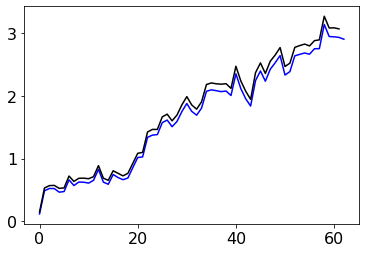

glo, mean diff between native mesh and interpolated integration:  0.09727554111389837


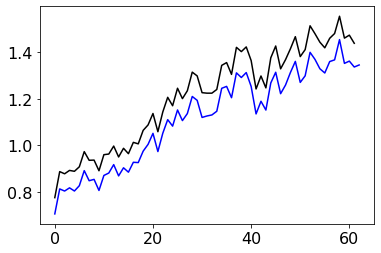

N, mean diff between native mesh and interpolated integration:  0.09644176935997258


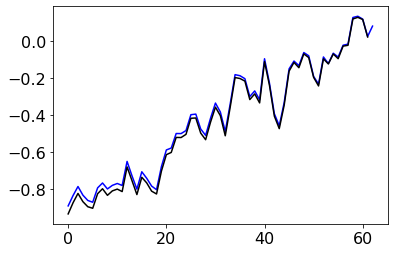

T, mean diff between native mesh and interpolated integration:  -0.019536313342013355


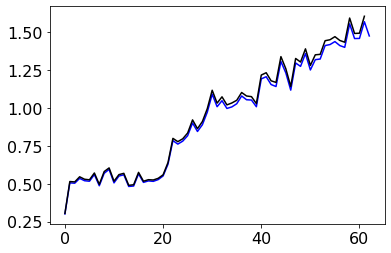

S, mean diff between native mesh and interpolated integration:  0.020370085095939176


In [9]:
# compare Rö CO2 flux: integrated on native mesh (old) and from 1x1 degree field

plt.figure()
plt.plot(roeden_fgco2_PgCyr_A_glo,'b')
plt.plot(roeden_fgco2_PgCyr_A_glo_old,'k')
plt.show()
print('glo, mean diff between native mesh and interpolated integration: ',np.nanmean(roeden_fgco2_PgCyr_A_glo_old-roeden_fgco2_PgCyr_A_glo))


plt.figure()
plt.plot(roeden_fgco2_PgCyr_A_N,'b')
plt.plot(roeden_fgco2_PgCyr_A_N_old,'k')
plt.show()
print('N, mean diff between native mesh and interpolated integration: ',np.nanmean(roeden_fgco2_PgCyr_A_N_old-roeden_fgco2_PgCyr_A_N))

plt.figure()
plt.plot(roeden_fgco2_PgCyr_A_T,'b')
plt.plot(roeden_fgco2_PgCyr_A_T_old,'k')
plt.show()
print('T, mean diff between native mesh and interpolated integration: ',np.nanmean(roeden_fgco2_PgCyr_A_T_old-roeden_fgco2_PgCyr_A_T))


plt.figure()
plt.plot(roeden_fgco2_PgCyr_A_S,'b')
plt.plot(roeden_fgco2_PgCyr_A_S_old,'k')
plt.show()
print('S, mean diff between native mesh and interpolated integration: ',np.nanmean(roeden_fgco2_PgCyr_A_S_old-roeden_fgco2_PgCyr_A_S))


(120, 180, 360)


<ipython-input-10-760c08e324d9>:10: RuntimeWarning: Mean of empty slice
  land_fgco2_A_2009_2018 = np.nanmean(np.squeeze(land_fgco2_1x1_A[ind_2009_2018_monthly,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
<ipython-input-10-760c08e324d9>:11: RuntimeWarning: Mean of empty slice
  land_fgco2_B_2009_2018 = np.nanmean(np.squeeze(land_fgco2_1x1_B[ind_2009_2018_monthly,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
<ipython-input-10-760c08e324d9>:12: RuntimeWarning: Mean of empty slice
  land_fgco2_C_2009_2018 = np.nanmean(np.squeeze(land_fgco2_1x1_C[ind_2009_2018_monthly,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
<ipython-input-10-760c08e324d9>:14: RuntimeWarning: Mean of empty slice
  land_spco2_A_2009_2018 = np.nanmean(np.squeeze(land_spco2_1x1_A[ind_2009_2018_monthly,:,:]),axis=0)
<ipython-input-10-760c08e324d9>:15: RuntimeWarning: Mean of empty slice
  land_spco2_B_2009_2018 = np.nanmean(np.squeeze(land_spco2_1x1_B[ind_2009_2018_monthly,:,:]),axis=0)
<ipython-input-10-760c08e324d9>

shape(reg_arcT) (756, 180, 360)
region global
shape(mask) (756, 180, 360)


/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:116: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(reg_lon,reg_lat,np.squeeze(mask[1,:,:]))#, vmin=-60, vmax=750)


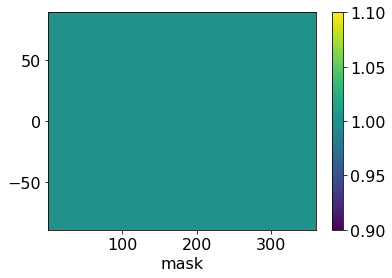

global
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
True
True
True
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region glo_noArc
shape(mask) (756, 180, 360)


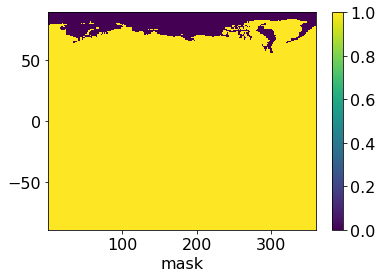

glo_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- 

shape(reg_arcT) (756, 180, 360)
region N
shape(mask) (756, 180, 360)


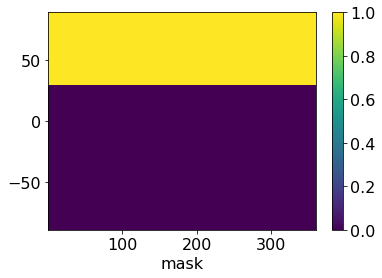

N
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region N_noArc
shape(mask) (756, 180, 360)


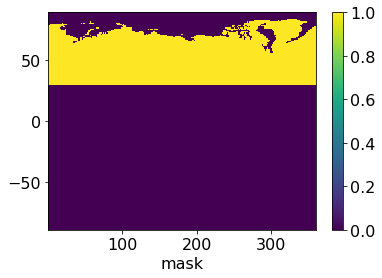

N_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region Arc
shape(mask) (756, 180, 360)


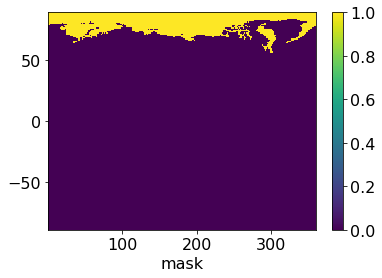

Arc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- 

shape(reg_arcT) (756, 180, 360)
region T
shape(mask) (756, 180, 360)


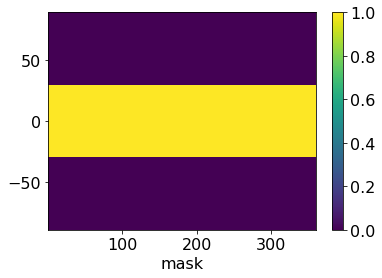

T
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region S
shape(mask) (756, 180, 360)


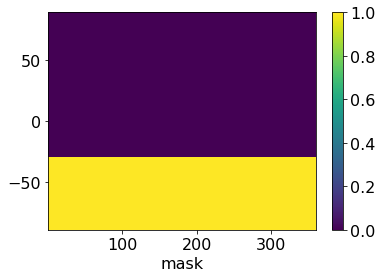

S
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region global
shape(mask) (756, 180, 360)


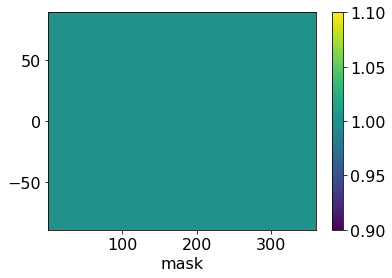

global
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
True
True
True
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region glo_noArc
shape(mask) (756, 180, 360)


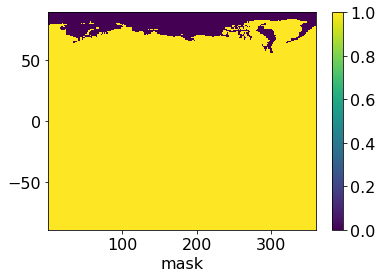

glo_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- 

shape(reg_arcT) (756, 180, 360)
region N
shape(mask) (756, 180, 360)


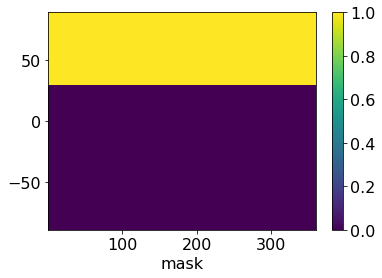

N
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region N_noArc
shape(mask) (756, 180, 360)


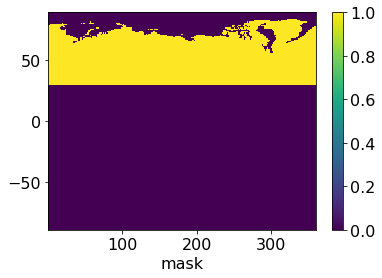

N_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region Arc
shape(mask) (756, 180, 360)


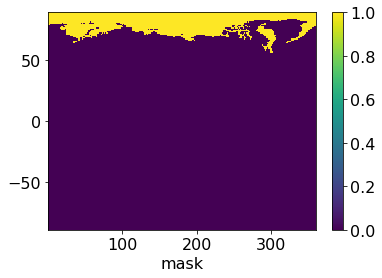

Arc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- 

shape(reg_arcT) (756, 180, 360)
region T
shape(mask) (756, 180, 360)


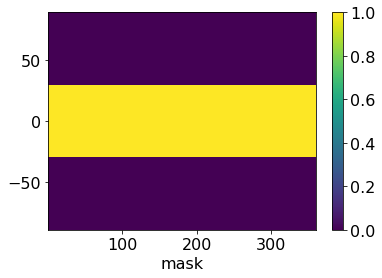

T
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region S
shape(mask) (756, 180, 360)


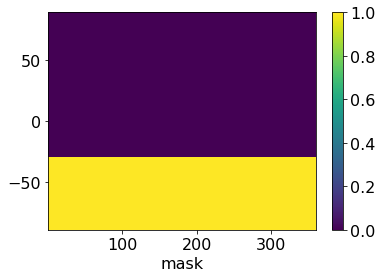

S
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region global
shape(mask) (756, 180, 360)


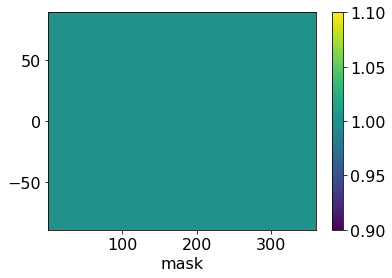

global
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
True
True
True
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region glo_noArc
shape(mask) (756, 180, 360)


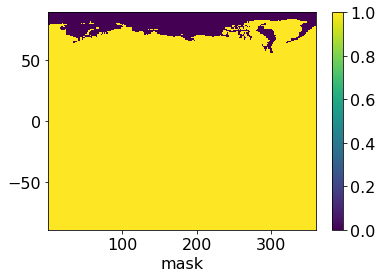

glo_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- 

shape(reg_arcT) (756, 180, 360)
region N
shape(mask) (756, 180, 360)


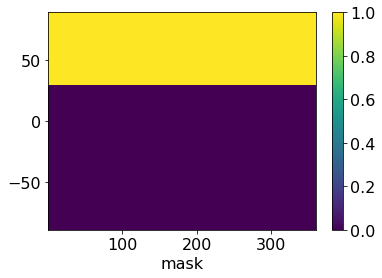

N
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region N_noArc
shape(mask) (756, 180, 360)


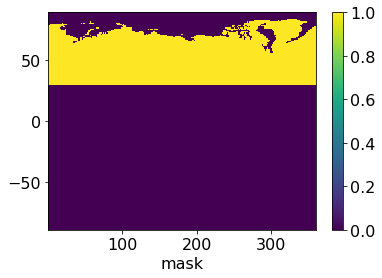

N_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region Arc
shape(mask) (756, 180, 360)


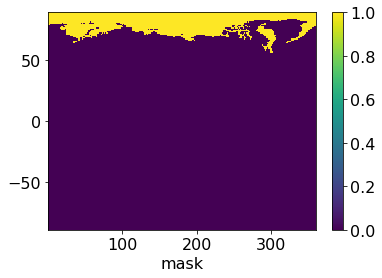

Arc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- 

shape(reg_arcT) (756, 180, 360)
region T
shape(mask) (756, 180, 360)


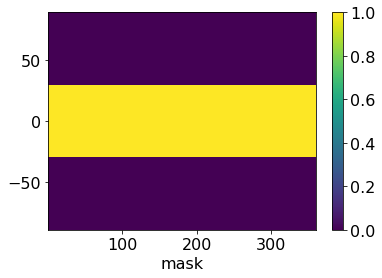

T
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region S
shape(mask) (756, 180, 360)


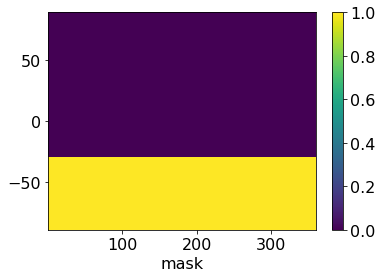

S
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

In [10]:
# calculate/integrate fluxes, and calculate annual mean. convert units where necessary:

# mean map for the last ten years:
# check whether empty entries at the end??
# ind2 = end 2018

# convert from mol/m2/s to mol/m2/yr

print(np.shape(land_fgco2_1x1_A[ind2009:ind2,:,:])) # 120 time entries
land_fgco2_A_2009_2018 = np.nanmean(np.squeeze(land_fgco2_1x1_A[ind_2009_2018_monthly,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
land_fgco2_B_2009_2018 = np.nanmean(np.squeeze(land_fgco2_1x1_B[ind_2009_2018_monthly,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
land_fgco2_C_2009_2018 = np.nanmean(np.squeeze(land_fgco2_1x1_C[ind_2009_2018_monthly,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr

land_spco2_A_2009_2018 = np.nanmean(np.squeeze(land_spco2_1x1_A[ind_2009_2018_monthly,:,:]),axis=0)
land_spco2_B_2009_2018 = np.nanmean(np.squeeze(land_spco2_1x1_B[ind_2009_2018_monthly,:,:]),axis=0)
land_spco2_C_2009_2018 = np.nanmean(np.squeeze(land_spco2_1x1_C[ind_2009_2018_monthly,:,:]),axis=0)

# Landschützer:

land_fgco2_PgCyr_A_glo= integrate_CO2flux(land_fgco2_1x1_A,'global',areaT,xax,yax)
land_fgco2_PgCyr_A_glo_noArc= integrate_CO2flux(land_fgco2_1x1_A,'glo_noArc',areaT,xax,yax)

land_fgco2_PgCyr_A_N= integrate_CO2flux(land_fgco2_1x1_A,'N',areaT,xax,yax)
land_fgco2_PgCyr_A_N_noArc= integrate_CO2flux(land_fgco2_1x1_A,'N_noArc',areaT,xax,yax)
land_fgco2_PgCyr_A_Arc= integrate_CO2flux(land_fgco2_1x1_A,'Arc',areaT,xax,yax)
land_fgco2_PgCyr_A_T= integrate_CO2flux(land_fgco2_1x1_A,'T',areaT,xax,yax)
land_fgco2_PgCyr_A_S= integrate_CO2flux(land_fgco2_1x1_A,'S',areaT,xax,yax)

land_fgco2_PgCyr_A_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_A_glo_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan

land_fgco2_PgCyr_A_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_A_N_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_A_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_A_T[(gcb_years<1982) | (gcb_years>2018) ]=np.nan
land_fgco2_PgCyr_A_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan


print(land_fgco2_PgCyr_A_glo)

land_fgco2_PgCyr_B_glo= integrate_CO2flux(land_fgco2_1x1_B,'global',areaT,xax,yax)
land_fgco2_PgCyr_B_glo_noArc= integrate_CO2flux(land_fgco2_1x1_B,'glo_noArc',areaT,xax,yax)
land_fgco2_PgCyr_B_N= integrate_CO2flux(land_fgco2_1x1_B,'N',areaT,xax,yax)
land_fgco2_PgCyr_B_N_noArc= integrate_CO2flux(land_fgco2_1x1_B,'N_noArc',areaT,xax,yax)
land_fgco2_PgCyr_B_Arc= integrate_CO2flux(land_fgco2_1x1_B,'Arc',areaT,xax,yax)
land_fgco2_PgCyr_B_T= integrate_CO2flux(land_fgco2_1x1_B,'T',areaT,xax,yax)
land_fgco2_PgCyr_B_S= integrate_CO2flux(land_fgco2_1x1_B,'S',areaT,xax,yax)

land_fgco2_PgCyr_B_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_B_glo_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_B_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_B_N_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_B_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_B_T[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_B_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan

print(land_fgco2_PgCyr_B_glo)

land_fgco2_PgCyr_C_glo= integrate_CO2flux(land_fgco2_1x1_C,'global',areaT,xax,yax)
land_fgco2_PgCyr_C_glo_noArc= integrate_CO2flux(land_fgco2_1x1_C,'glo_noArc',areaT,xax,yax)
land_fgco2_PgCyr_C_N= integrate_CO2flux(land_fgco2_1x1_C,'N',areaT,xax,yax)
land_fgco2_PgCyr_C_N_noArc= integrate_CO2flux(land_fgco2_1x1_C,'N_noArc',areaT,xax,yax)
land_fgco2_PgCyr_C_Arc= integrate_CO2flux(land_fgco2_1x1_C,'Arc',areaT,xax,yax)
land_fgco2_PgCyr_C_T= integrate_CO2flux(land_fgco2_1x1_C,'T',areaT,xax,yax)
land_fgco2_PgCyr_C_S= integrate_CO2flux(land_fgco2_1x1_C,'S',areaT,xax,yax)

land_fgco2_PgCyr_C_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_C_glo_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan

land_fgco2_PgCyr_C_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_C_N_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_C_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_C_T[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_C_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan

print(land_fgco2_PgCyr_C_glo)



# (not needed for Rödenbeck, already done in the Rödenbeck loading routine)

In [11]:
print(np.shape(land_spco2_1x1_A))

(756, 180, 360)


In [12]:
print(np.shape(areaT))

(756, 180, 360)


In [13]:
def reg_ave_pCO2(datam,region,areaT,intYY,reg_arcT):
        """
        this function averages a pCO2 fiels over specific regions

        """
        import numpy as np
        from annualmean import annualmean

        print('shape reg_arcT',np.shape(reg_arcT))
        print('shape intYY',np.shape(intYY))

        #-------------------------------------------
        tmp = np.copy(datam)
        print(type(tmp))

        if region == 'global':        # in that case, nothing to do    
            datam_reg = np.copy(tmp)
            print('global, just return from if loop')
 #           print(np.shape(datam_reg))
 #           print(type(datam_reg))
    
        elif region == 'glo_noArc': 
#            tmp[(reg_arcT>0)]=np.nan
            tmp[(reg_arcT[:]>0)] = np.nan
            datam_reg = np.copy(tmp)
            print('global no Arc, apply some mask')
 #           print(np.shape(datam_reg))
 #           print(type(datam_reg))

        elif region == 'S':
            tmp[(intYY[:]>-30)] = np.nan
            datam_reg = np.copy(tmp)

            print('S, apply some mask')
  #          print(np.shape(datam_reg))
  #          print(type(datam_reg))

        elif region == 'N':
            tmp[(intYY[:]<30)] = np.nan
            datam_reg = np.copy(tmp)

            print('N, apply some mask')
   #         print(np.shape(datam_reg))
   #         print(type(datam_reg))

    
        elif region == 'N_noArc':
            tmp[(intYY[:]<30) | (reg_arcT[:]>0.5)] = np.nan
#            tmp[(reg_arcT[:]==1)] = np.nan
            datam_reg = np.ma.array(datam, mask=np.isnan(tmp))

            print('N_noArc, apply some mask')
   #         print(np.shape(datam_reg))
   #         print(type(datam_reg))
    
        elif region == 'N3060':
            tmp[(intYY[:]<30)] = np.nan
            tmp[(intYY[:]>60)] = np.nan
            datam_reg = np.ma.array(datam, mask=np.isnan(tmp))

            print('N3060, apply some mask')
#            print(datam_reg)
#            print(np.shape(datam_reg))
#            print(type(datam_reg))

        elif region == 'N60':
            tmp[(intYY[:]<60)] = np.nan
            datam_reg = np.ma.array(datam, mask=np.isnan(tmp))

            print('N60, apply some mask')
            
        elif region == 'Arc': # changed this to reccap Arc mask
            tmp[(reg_arcT<1)] = np.nan
            datam_reg = np.copy(tmp)
            print('Arc, apply some mask')
#            print(np.shape(datam_reg))
#            print(type(datam_reg))

        elif region == 'T':
            tmp[(intYY[:]<-30)] = np.nan
            tmp[(intYY[:]>30)] = np.nan
            datam_reg = np.ma.array(datam, mask=np.isnan(tmp))

            print('T, apply some mask')
#            print(datam_reg)
#            print(np.shape(datam_reg))
#            print(type(datam_reg))

        else:
            raise NameError('Region not defined properly')
      
        # check with figure
        plt.figure()
        plt.pcolor(np.squeeze(datam_reg[ind1,:,:]))#, vmin=-60, vmax=750)
        plt.colorbar()
        plt.xlabel('pCO2 field')
        plt.show()
        
        # average in space and time
        datam_ts= np.ma.average(np.ma.average(datam_reg,axis=2,weights=areaT),axis=1,weights=np.squeeze(areaT[:,:,0]))
        datam_am = annualmean(datam_ts)
        
        return datam_ts, datam_am


global
shape reg_arcT (756, 180, 360)
shape intYY (756, 180, 360)
<class 'numpy.ndarray'>
global, just return from if loop


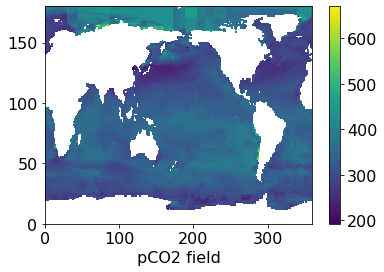

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [321.02082803456045 326

<class 'numpy.ndarray'>
global no Arc, apply some mask


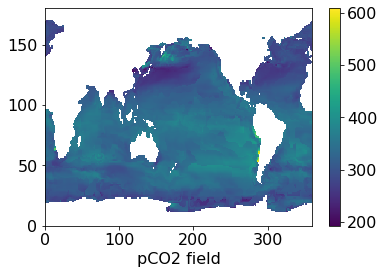

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [315.8750614597136 322.

<class 'numpy.ndarray'>
N_noArc, apply some mask


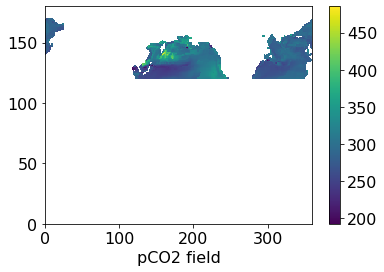

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [291.7454696671238 288.

<class 'numpy.ndarray'>
Arc, apply some mask


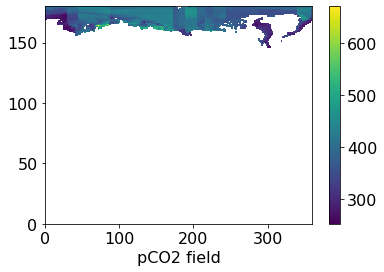

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [389.8670861881764 389.

<class 'numpy.ndarray'>
T, apply some mask


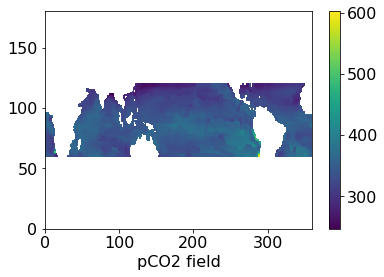

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [337.796228918111 337.6

<class 'numpy.ndarray'>
S, apply some mask


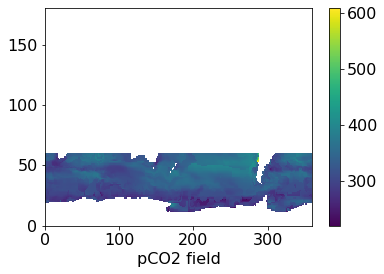

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [315.8750614597136 322.

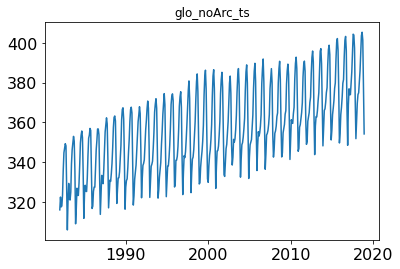

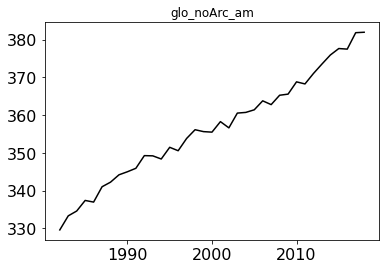

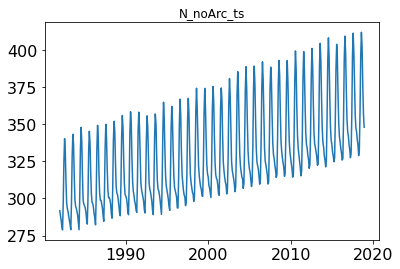

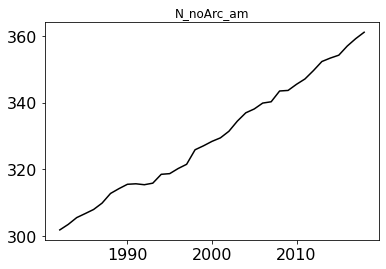

global
shape reg_arcT (756, 180, 360)
shape intYY (756, 180, 360)
<class 'numpy.ndarray'>
global, just return from if loop


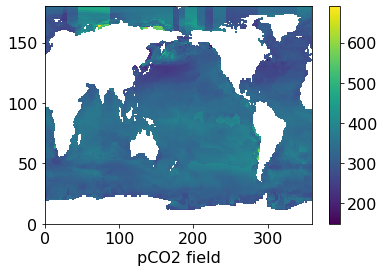

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [319.08170194117844 322

<class 'numpy.ndarray'>
global no Arc, apply some mask


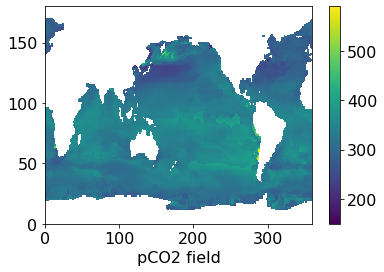

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [317.4073744217657 321.

<class 'numpy.ndarray'>
N_noArc, apply some mask


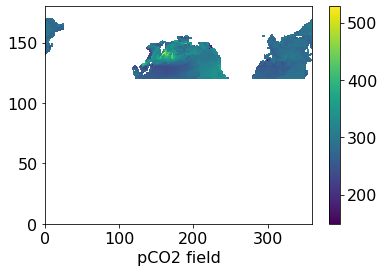

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [289.53363506906334 286

<class 'numpy.ndarray'>
Arc, apply some mask


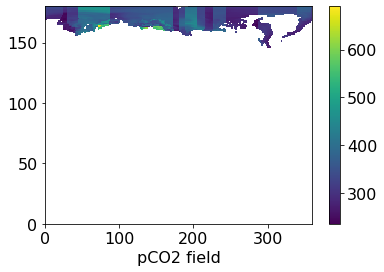

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [341.4828705442495 332.

<class 'numpy.ndarray'>
T, apply some mask


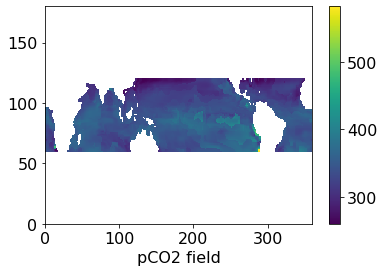

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [337.9537513809201 337.

<class 'numpy.ndarray'>
S, apply some mask


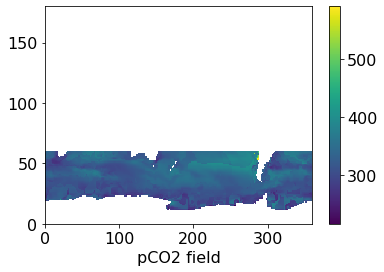

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [317.4073744217657 321.

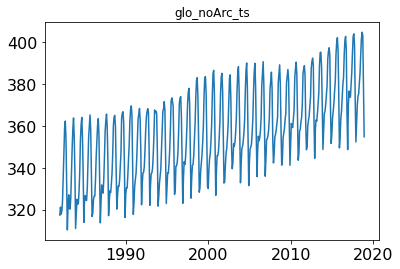

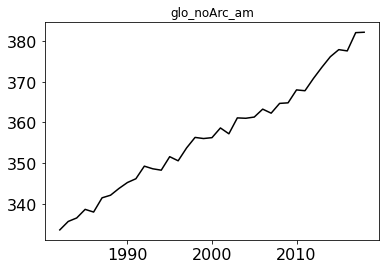

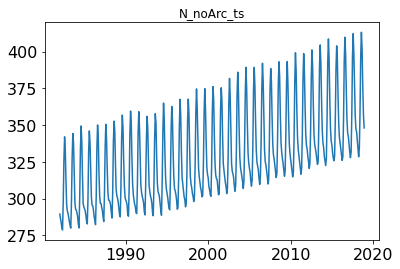

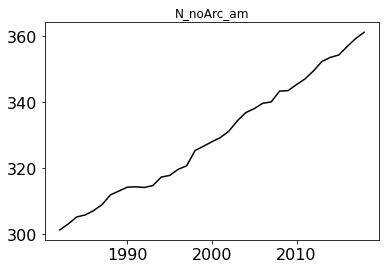

global
shape reg_arcT (756, 180, 360)
shape intYY (756, 180, 360)
<class 'numpy.ndarray'>
global, just return from if loop


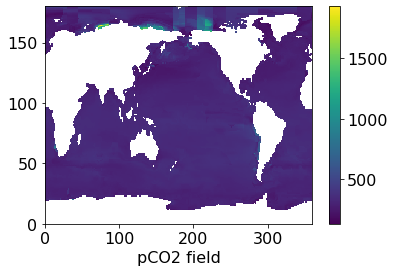

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [317.3819345219323 326.

<class 'numpy.ndarray'>
global no Arc, apply some mask


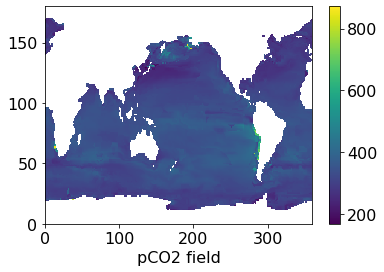

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [316.0196627294616 324.

<class 'numpy.ndarray'>
N_noArc, apply some mask


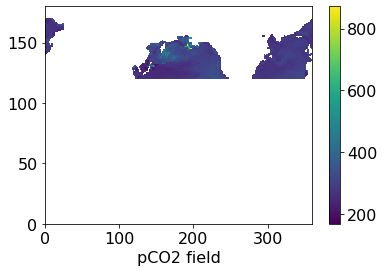

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [292.5239160647953 288.

<class 'numpy.ndarray'>
Arc, apply some mask


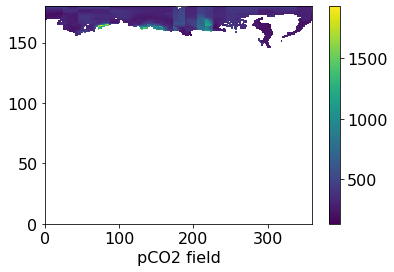

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [335.60804605180084 356

<class 'numpy.ndarray'>
T, apply some mask


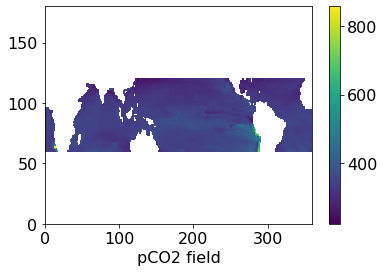

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [337.0740133898645 337.

<class 'numpy.ndarray'>
S, apply some mask


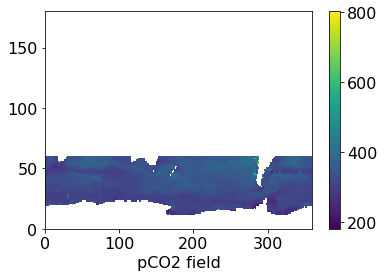

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [316.0196627294616 324.

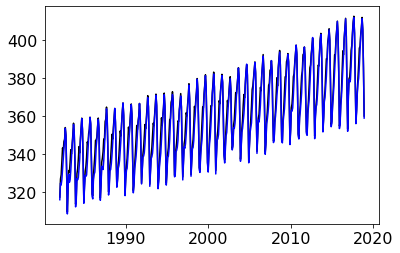

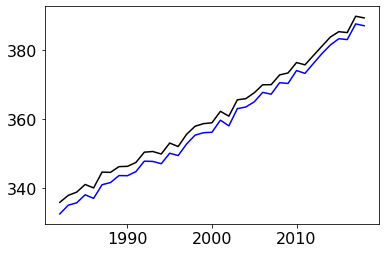

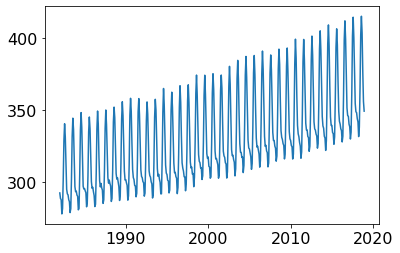

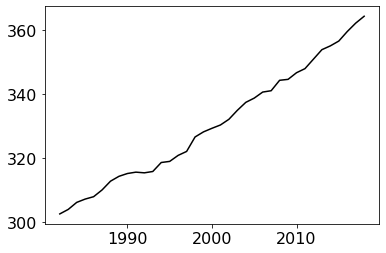

[         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan 335.95178593
 337.96002653 338.90207785 341.11244045 340.11813494 344.68895273
 344.60226725 346.26125707 346.34187152 347.454614   350.43095809
 350.62483303 349.90627706 353.06728108 352.05800729 355.59896597
 357.9048686  358.6635713  358.91194427 362.22281769 360.82361799
 365.53164148 365.87149111 367.56661265 369.87840691 369.91014038
 372.72460339 373.29196194 376.28990329 375.63593628 378.32611148
 381.00288387 383.64197613 385.200833   384.9429081  389.6562391
 389.17510568          nan          nan]


In [14]:
# spco2 for Landschützer 
#--------------------------------------------------------------------
# calculate means for spco2:
regions=('global','glo_noArc','N_noArc','Arc','T','S') #'N','Arc','N60',

# sim A
for reg in regions:
        print(reg)
        exec('land_spco2_A_'+reg+'_ts, land_spco2_A_'+reg+'_am = reg_ave_pCO2(land_spco2_1x1_A,"'+reg+'",areaT,YY,reg_arcT)')
        exec('land_spco2_A_'+reg+'_am[(gcb_years<1982) | (gcb_years>2018)]=np.nan')

plt.figure()
plt.plot(gcb_time,land_spco2_A_glo_noArc_ts)#, vmin=-60, vmax=750)
plt.title('glo_noArc_ts')
plt.show()

plt.figure()
plt.plot(gcb_years,land_spco2_A_glo_noArc_am,'k-')#, vmin=-60, vmax=750)
plt.title('glo_noArc_am')
plt.show()

plt.figure()
plt.plot(gcb_time,land_spco2_A_N_noArc_ts)#, vmin=-60, vmax=750)plt.show()
plt.title('N_noArc_ts')
plt.show()

plt.figure()
plt.plot(gcb_years,land_spco2_A_N_noArc_am,'k-')#, vmin=-60, vmax=750)
plt.title('N_noArc_am')
plt.show()

#print(land_spco2_A_N60_am, land_spco2_A_T_am)


# sim B
for reg in regions:
        print(reg)
        exec('land_spco2_B_'+reg+'_ts, land_spco2_B_'+reg+'_am = reg_ave_pCO2(land_spco2_1x1_B,"'+reg+'",areaT,YY,reg_arcT)')
        exec('land_spco2_B_'+reg+'_am[(gcb_years<1982) | (gcb_years>2018)]=np.nan')

plt.figure()
plt.plot(gcb_time,land_spco2_B_glo_noArc_ts)#, vmin=-60, vmax=750)
plt.title('glo_noArc_ts')

plt.show()

plt.figure()
plt.plot(gcb_years,land_spco2_B_glo_noArc_am,'k-')#, vmin=-60, vmax=750)
plt.title('glo_noArc_am')

plt.show()

plt.figure()
plt.plot(gcb_time,land_spco2_B_N_noArc_ts)#, vmin=-60, vmax=750)
plt.title('N_noArc_ts')

plt.show()

plt.figure()
plt.plot(gcb_years,land_spco2_B_N_noArc_am,'k-')#, vmin=-60, vmax=750)
plt.title('N_noArc_am')


plt.show()

#print(land_spco2_B_global_am, land_spco2_B_N_am)             
             
             
# sim C
for reg in regions:
        print(reg)
        exec('land_spco2_C_'+reg+'_ts, land_spco2_C_'+reg+'_am = reg_ave_pCO2(land_spco2_1x1_C,"'+reg+'",areaT,YY,reg_arcT)')
        exec('land_spco2_C_'+reg+'_am[(gcb_years<1982) | (gcb_years>2018)]=np.nan')

plt.figure()
plt.plot(gcb_time,land_spco2_C_global_ts,'k')#, vmin=-60, vmax=750)
plt.plot(gcb_time,land_spco2_C_glo_noArc_ts,'b')#, vmin=-60, vmax=750)

plt.show()

plt.figure()
plt.plot(gcb_years,land_spco2_C_global_am,'k-')#, vmin=-60, vmax=750)
plt.plot(gcb_years,land_spco2_C_glo_noArc_am,'b-')#, vmin=-60, vmax=750)

plt.show()

plt.figure()
plt.plot(gcb_time,land_spco2_C_N_noArc_ts)#, vmin=-60, vmax=750)
plt.show()

plt.figure()
plt.plot(gcb_years,land_spco2_C_N_noArc_am,'k-')#, vmin=-60, vmax=750)

plt.show()

print(land_spco2_C_global_am)#, land_spco2_C_N_am)             
                          
             
             

In [15]:
print(np.shape(land_spco2_A_N_noArc_ts))
print(land_spco2_A_N_noArc_ts)

index = np.where(land_spco2_A_N_noArc_ts>0)
print(np.shape(index))
print(444./12)
print(index[0])

(756,)
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 291.7454696671238 288.28403307943415 285.4767442896281 281.0329142791021
 278.7983235255484 297.0899860665014 325.05

global
shape reg_arcT (756, 180, 360)
shape intYY (756, 180, 360)
<class 'numpy.ndarray'>
global, just return from if loop


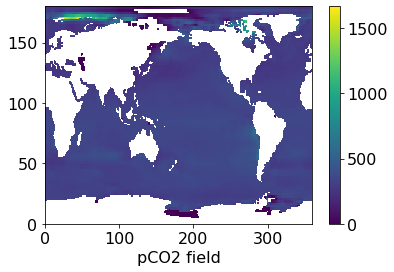

0 [309.10716162531423 316.7500732811083 320.00249037476055 319.9691090299846
 317.08763035748933 321.2284685634303 325.5786331318447 315.5789781685798
 313.0636882974829 314.90032135824316 309.1512673492325 301.34418018637604]
1 [302.97379486464615 310.02808760671707 313.4182351967333 314.0292871364553
 311.4805121150883 306.1704868890963 306.555206130048 312.4734290265802
 310.50676131116194 307.2820818029023 309.6752918645983 302.00996669425984]
2 [304.96521804621267 313.2774499088416 315.4688458389794 314.90665041940053
 316.07766436282475 315.59576766089987 312.07952978968365
 310.9504162611761 310.2818820207066 306.25749098153454 309.70282403274626
 304.26769532841183]
3 [306.3288408526276 312.2586000905548 315.1131705928019 314.2534912413642
 315.24844379153586 315.85319236765616 311.61480416445545
 309.83445410872446 310.1374595809389 306.3919269274971 308.87549186726636
 301.2492858009044]
4 [303.37757812368403 310.8087998514719 314.7753149049323 316.3920486717803
 318.26483734

<class 'numpy.ndarray'>
global no Arc, apply some mask


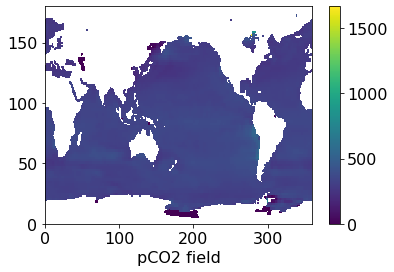

0 [309.10716162531423 316.7500732811083 320.00249037476055 319.9691090299846
 322.005192190044 325.2646277332037 329.71789028072203 329.9133805119467
 325.95696320977567 319.52221712082667 309.1512673492325
 301.34418018637604]
1 [302.97379486464615 310.02808760671707 313.4182351967333 314.0292871364553
 316.3003141391974 321.07771944642377 326.23496674822945 329.4927013161779
 327.3873038074282 320.37150040208826 309.6752918645983 302.00996669425984]
2 [304.96521804621267 313.2774499088416 315.4688458389794 314.90665041940053
 316.07766436282475 319.60217296373105 324.27872494689984
 327.35741029875425 325.54867930887286 318.9846151459689
 309.70282403274626 304.26769532841183]
3 [306.3288408526276 312.2586000905548 315.1131705928019 314.2534912413642
 315.24844379153586 319.8701462142672 325.32020058216784 328.0635112892156
 326.7979428427875 319.7461364296917 308.87549186726636 301.2492858009044]
4 [303.37757812368403 310.8087998514719 314.7753149049323 316.3920486717803
 318.264837

<class 'numpy.ndarray'>
N_noArc, apply some mask


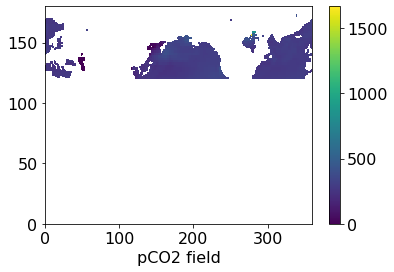

0 [277.44096950414763 274.5547301257961 270.40047008577415
 268.28566873301514 274.76089917980033 290.9741681211387 314.7627625037364
 329.4092809223796 322.6034540191101 304.64461787776526 289.83039168659275
 280.28409692167503]
1 [275.2114076895873 272.4452802353869 268.825741895312 266.68266564368275
 272.3130084310809 287.1099034041508 310.7224519670383 328.05319772560733
 320.69529940609743 302.8595206123508 288.80860624773055
 279.58360293621536]
2 [274.2275188545481 271.0711221090628 267.6370244019112 266.2447526583346
 272.5503305879078 289.6878817837894 314.2390342787976 331.0743628765142
 323.99981904651094 306.0048060518698 289.0072301969927 278.8062174752288]
3 [273.8820605838036 271.046532648301 268.0132466012674 266.3566761276187
 272.5506454899196 289.07716932300053 313.1194445340654 329.224457278679
 321.093217126136 304.7019968991243 289.9221091704379 279.5973419806715]
4 [274.79021460594134 272.21704856151104 268.31968705938175
 266.29029813602773 271.76700020736627 2

<class 'numpy.ndarray'>
Arc, apply some mask


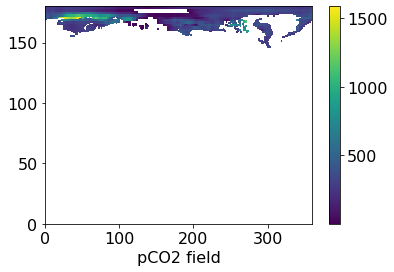

0 [-- -- -- -- 76.7071654863372 123.9327658228521 123.24329062909635
 165.26225020905494 177.8592443957589 88.972617787573 -- --]
1 [-- -- -- -- 75.87874632287226 149.84681414203635 169.00284672446358
 193.51664371703552 192.51963263326056 170.0207905686256 -- --]
2 [-- -- -- -- -- 119.75449469890589 184.15350568021185 196.27317071901032
 203.57408062529998 172.7953755123364 -- --]
3 [-- -- -- -- -- 119.49628504378396 167.89410374390056 182.42183595932806
 193.688442442625 166.35392403267926 -- --]
4 [-- -- -- -- -- 125.70339275032684 178.91520725354317 208.7902774547295
 211.67288501163821 103.00770879978444 -- --]
5 [-- -- -- -- -- 139.22583162622792 200.94003128482993 229.2722963515809
 224.05049592180157 196.33657401693017 -- --]
6 [-- -- -- -- 105.19870055692981 164.8173878442429 193.95058418513244
 229.28916885717496 250.36263915431127 191.93825314093192 -- --]
7 [-- -- -- -- 97.87454137915641 181.18082011914032 202.79751209675436
 233.86279215522887 234.54586017033884 203.424984

<class 'numpy.ndarray'>
T, apply some mask


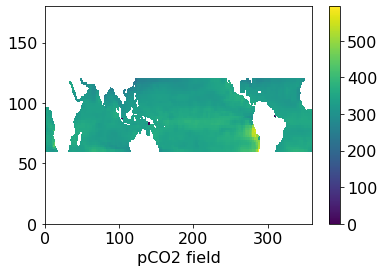

0 [320.870422546108 323.342144055709 324.3699754872395 325.44212298262573
 325.2161635708638 322.5237199574731 319.36103831463606 317.8235124234682
 317.14231921156585 317.3274798053443 318.2056732358244 318.9312706174712]
1 [320.20224021441464 322.457116534699 323.8353026578731 324.167572618972
 323.7402166556142 321.8983719032178 320.0145141803333 318.7465837248581
 318.165445572039 318.6505437408468 319.5859870670494 319.8069548630936]
2 [320.89798031975766 323.05999887463 324.19794349118825 325.2007098679327
 325.5004180018768 323.31208208465017 320.81871510122335
 318.89793907903385 318.25510709919547 318.87427902686517
 319.66016140187236 319.8432143807588]
3 [320.9898236541917 323.1639689612549 324.000414074726 324.78258034629573
 324.87408298212557 322.89889832748975 320.80745894857796
 319.5819862411119 318.54185514663794 318.8530909140427 319.923902537828
 320.1815186211053]
4 [321.14811824530267 323.3277837057511 325.64704392622883
 326.84729029257585 326.7618944479281 324.9

<class 'numpy.ndarray'>
S, apply some mask


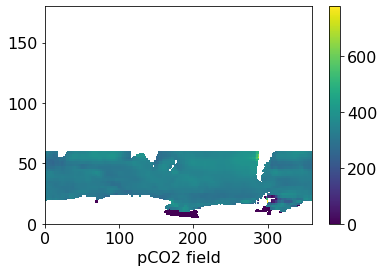

0 [309.10716162531423 316.7500732811083 320.00249037476055 319.9691090299846
 322.005192190044 325.2646277332037 329.71789028072203 329.9133805119467
 325.95696320977567 319.52221712082667 309.1512673492325
 301.34418018637604]
1 [302.97379486464615 310.02808760671707 313.4182351967333 314.0292871364553
 316.3003141391974 321.07771944642377 326.23496674822945 329.4927013161779
 327.3873038074282 320.37150040208826 309.6752918645983 302.00996669425984]
2 [304.96521804621267 313.2774499088416 315.4688458389794 314.90665041940053
 316.07766436282475 319.60217296373105 324.27872494689984
 327.35741029875425 325.54867930887286 318.9846151459689
 309.70282403274626 304.26769532841183]
3 [306.3288408526276 312.2586000905548 315.1131705928019 314.2534912413642
 315.24844379153586 319.8701462142672 325.32020058216784 328.0635112892156
 326.7979428427875 319.7461364296917 308.87549186726636 301.2492858009044]
4 [303.37757812368403 310.8087998514719 314.7753149049323 316.3920486717803
 318.264837

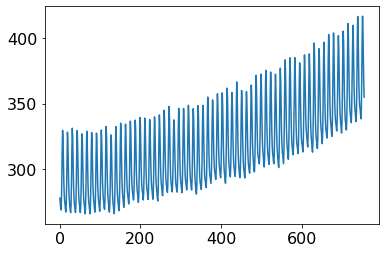

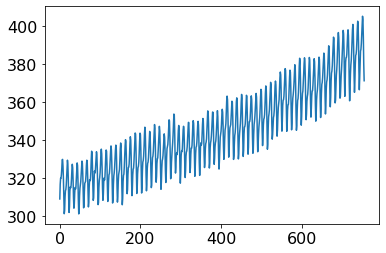

[291.49595914 289.44255718 290.37917503 289.88207481 289.11729973
 289.21488236 289.3099753  289.50585858 290.8192457  292.25292184
 289.05670977 290.40984451 293.37344871 294.61303627 296.94032289
 298.73383093 298.90466055 299.24833173 299.6965469  300.01711646
 300.60353536 303.7696047  306.33271074 303.75764922 305.6236582
 305.77993793 307.9382266  306.93424312 306.12407131 308.35289999
 311.69597971 312.72284548 316.58260685 316.92278025 317.06230165
 318.08692586 320.57625007 317.90061175 318.29311313 321.39588268
 325.38856543 328.87639243 329.30885777 330.05457353 329.2132586
 330.10268345 334.52117677 336.84417662 338.41709321 337.92342797
 341.00876259 342.95710287 343.57674827 345.45383066 348.44095429
 353.24137808 355.02532555 356.41586038 357.70710785 360.73407686
 364.01288475          nan          nan] [319.05871274 316.0832641  316.20316255 316.0937718  317.35749547
 318.11374379 320.96051463 322.35661597 321.75353197 322.2199207
 323.79105719 323.77427214 323.9938307

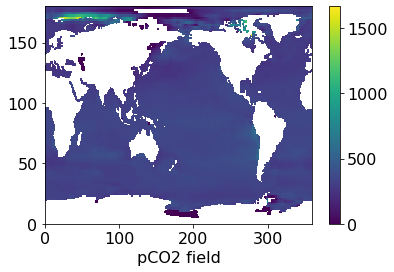

0 [308.7835040671794 316.1251072095491 319.17262630356 319.0857057382426
 316.3613444369857 321.3790506247428 326.594357701515 317.25121461045853
 315.0783822409417 316.62226620350003 309.99691264937366 301.7940966977516]
1 [303.3841694399193 309.97601730049814 313.14037975253655 313.617538405193
 311.20222955669976 306.4663876720608 307.6003542432075 314.14221793028713
 312.5416887102727 309.0775826620848 310.68911851269223 302.51771393571306]
2 [305.2098623231479 313.1878286519811 315.4281722093084 314.753466134496
 316.04428938970216 316.23245461412324 313.36904373826246
 312.60021241720966 312.2282247977841 307.9662100699069 310.6448441014064
 304.59561276667364]
3 [306.41894539284215 311.9197249162784 314.66777024148865 313.7987708605106
 314.9664517376318 316.1904489784517 312.6420031358804 311.45490147001027
 312.17839699049665 308.25230213346236 309.8983582713142
 301.64636120596214]
4 [303.61114432576034 310.69150655871505 314.45311834166966
 315.9516059055489 318.113314754353

<class 'numpy.ndarray'>
global no Arc, apply some mask


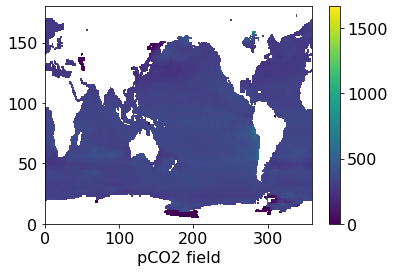

0 [308.7835040671794 316.1251072095491 319.17262630356 319.0857057382426
 321.2616456944101 325.4151423361145 330.7511081475797 331.74965515535007
 328.16841760429446 321.27615081178317 309.99691264937366
 301.7940966977516]
1 [303.3841694399193 309.97601730049814 313.14037975253655 313.617538405193
 316.0132559936681 321.4046475281148 327.4259748431643 331.3982872649325
 329.71004941358154 322.34385270290016 310.68911851269223
 302.51771393571306]
2 [305.2098623231479 313.1878286519811 315.4281722093084 314.753466134496
 316.04428938970216 320.2484246618539 325.69788488918937 329.2428462521698
 327.7719398733279 320.8630522012811 310.6448441014064 304.59561276667364]
3 [306.41894539284215 311.9197249162784 314.66777024148865 313.7987708605106
 314.9664517376318 320.2107630137537 326.4510840647589 329.9160746098249
 329.13024321295717 321.7902412441766 309.8983582713142 301.64636120596214]
4 [303.61114432576034 310.69150655871505 314.45311834166966
 315.9516059055489 318.1133147543532 

<class 'numpy.ndarray'>
N_noArc, apply some mask


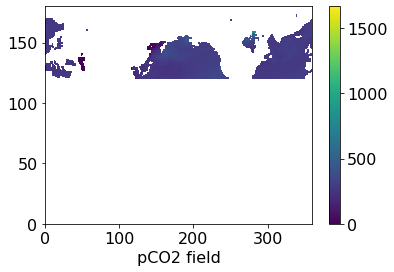

0 [277.44035671597777 274.552682167091 270.39799712749084 268.2830473952972
 274.75708812211286 290.96955197608446 314.7612486327986 329.41241152744
 322.60794013001254 304.6482811321684 289.83253389074656 280.2847530071438]
1 [275.21080130853477 272.4438529037708 268.8237169056591 266.6798917991196
 272.3085651193045 287.105344730036 310.7213273284738 328.05644878677555
 320.6997295713411 302.8628020393221 288.81047802976514 279.58410691621424]
2 [274.22685792623645 271.06946722763496 267.6348794159319 266.2421231224618
 272.54621362921915 289.683619097686 314.2388705528755 331.07921434611484
 324.0059415775045 306.008891399383 289.0101961254728 278.8069706553507]
3 [273.88209949840183 271.04574645216263 268.01173201778187
 266.35454618593593 272.54684221262653 289.0732322057987 313.1196250093421
 329.2295385656638 321.09898103366527 304.7063014203738 289.9249996817044
 279.5987441693145]
4 [274.7903114296566 272.2160291027406 268.31792703795765 266.2881013924612
 271.76336090379306 2

<class 'numpy.ndarray'>
Arc, apply some mask


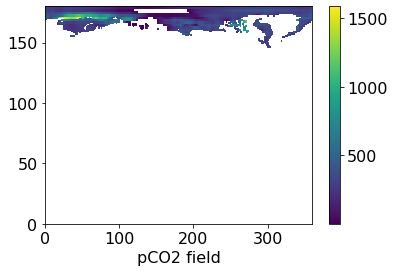

0 [-- -- -- -- 76.82461172722078 124.08664538860322 123.40390710796505
 165.214311290782 177.81062335149068 89.13088252838494 -- --]
1 [-- -- -- -- 76.02943238516212 149.8173492829413 169.0285015101724
 193.53033158173446 192.5428448379289 169.96175090328055 -- --]
2 [-- -- -- -- -- 119.9236373886102 184.08349579927608 196.27595445814467
 203.58489706371074 172.7243587697172 -- --]
3 [-- -- -- -- -- 119.66928876929258 167.83402219359667 182.41990089025376
 193.69288848152325 166.2876312883248 -- --]
4 [-- -- -- -- -- 125.87246534063254 178.7979369796985 208.71688213794485
 211.60176025247702 103.15429389318294 -- --]
5 [-- -- -- -- -- 139.41732946707455 200.96911010611163 229.29143662278653
 224.08023745823726 196.27845637675134 -- --]
6 [-- -- -- -- 105.41271186337404 165.03557963439638 193.96305266825752
 229.2866786819877 250.36779524627653 191.91087060439548 -- --]
7 [-- -- -- -- 98.05785358547575 181.09839285537225 202.8054572954309
 233.8601763884758 234.55544707665496 203.318325

<class 'numpy.ndarray'>
T, apply some mask


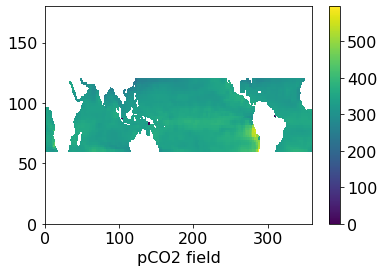

0 [320.65679799030846 323.1173834506343 324.21626102193716 325.3251933208077
 325.0723296932209 322.39342834893336 319.2872599723553 317.7732389179085
 317.0655130530962 317.2185441329364 318.0990464290548 318.82647807310786]
1 [320.057075439242 322.3134396234001 323.7439091289926 324.0970191318806
 323.6356517333427 321.78569916882634 319.951209964776 318.7077846469939
 318.09793237891694 318.5563480763835 319.50575470895217 319.7659100410433]
2 [320.8311881766296 322.95195652097453 324.12856669434484
 325.15038514848465 325.404971285135 323.206469117061 320.75911200407745
 318.8582117938287 318.18969888390336 318.7787472072775 319.58998313844734
 319.8097786178575]
3 [320.9178940815221 323.07474768787665 323.9450149571528 324.73691608840755
 324.79570787804096 322.81767261435965 320.7679781561371 319.5661499177447
 318.49278583501933 318.7684754123678 319.85394493487127
 320.12232507552204]
4 [321.0360898190925 323.1761127017585 325.55495519810046 326.79253146846827
 326.678246564390

<class 'numpy.ndarray'>
S, apply some mask


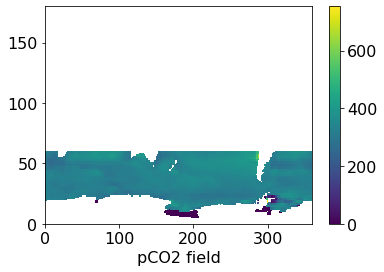

0 [308.7835040671794 316.1251072095491 319.17262630356 319.0857057382426
 321.2616456944101 325.4151423361145 330.7511081475797 331.74965515535007
 328.16841760429446 321.27615081178317 309.99691264937366
 301.7940966977516]
1 [303.3841694399193 309.97601730049814 313.14037975253655 313.617538405193
 316.0132559936681 321.4046475281148 327.4259748431643 331.3982872649325
 329.71004941358154 322.34385270290016 310.68911851269223
 302.51771393571306]
2 [305.2098623231479 313.1878286519811 315.4281722093084 314.753466134496
 316.04428938970216 320.2484246618539 325.69788488918937 329.2428462521698
 327.7719398733279 320.8630522012811 310.6448441014064 304.59561276667364]
3 [306.41894539284215 311.9197249162784 314.66777024148865 313.7987708605106
 314.9664517376318 320.2107630137537 326.4510840647589 329.9160746098249
 329.13024321295717 321.7902412441766 309.8983582713142 301.64636120596214]
4 [303.61114432576034 310.69150655871505 314.45311834166966
 315.9516059055489 318.1133147543532 

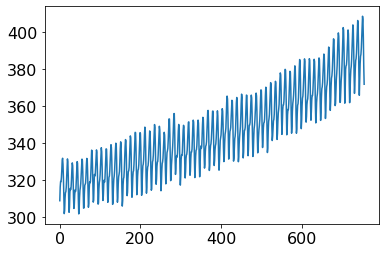

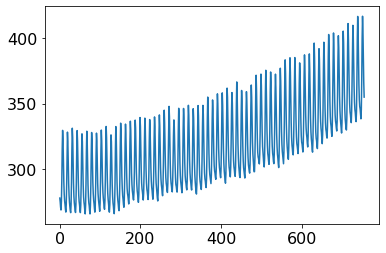

[319.46500603 316.80175042 316.97401862 316.73456573 318.17836053
 318.97842346 321.58378851 323.10743167 322.60396538 322.93061901
 324.46171122 324.41886385 324.69163624 325.98766029 327.78334567
 329.30024909 329.44677832 331.08448059 330.9711712  333.26309358
 333.25484519 331.83003218 337.44020566 338.33876981 335.59520704
 335.86539243 337.33723399 337.82101383 338.27237858 340.14609634
 342.33907237 342.6316835  341.96437333 344.24267163 348.78545354
 348.45287164 347.504356   348.7050958  349.94967862 350.96990955
 351.26522249 352.63821748 354.22468651 355.85403549 357.38174704
 361.26895898 363.79613063 362.37448302 364.91723397 365.77795781
 368.65880546 368.41147808 369.26079354 369.60525166 372.39289558
 374.64435859 379.44800771 380.96094926 381.67884354 383.95104055
 385.03627992          nan          nan] [291.49565765 289.44225545 290.37943709 289.88269904 289.11713459
 289.21444283 289.30414815 289.50004722 290.81979206 292.25273357
 289.0563278  290.41142171 293.3758

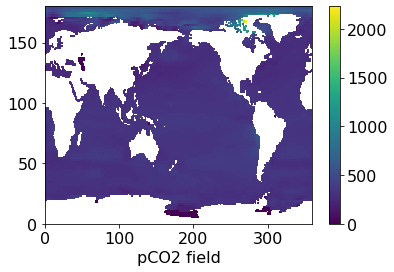

0 [324.42414855483344 328.79957445430733 329.3495004718513
 328.16073797050166 329.5233471702783 334.682489104998 342.5419823629486
 349.0517245988203 350.37233041327846 344.76539585996227 332.1511993545245
 323.71895860524353]
1 [327.1088120787165 331.44786238965156 331.6940869222562 332.0953297372755
 334.91668502724974 340.22458395299117 346.61087414865426
 350.70996599713703 351.5250073516349 346.3510849813404 334.0713846646545
 325.57838745065527]
2 [328.45055366809424 334.2699410915802 335.5233325965915 334.4653446625328
 337.4464794698702 343.46400992592703 350.00631027529846
 353.16736699383233 352.49364672374065 346.72791319399147
 335.94492158298686 329.2802933372567]
3 [332.5432953554835 336.2786221834539 335.3063627478722 333.60396599405084
 336.3034130226715 341.58603237628216 347.7045615728688 352.0276009096016
 353.1652616250623 348.13641535985516 336.1677666386823 328.0364097177239]
4 [331.5938973035693 337.3588428425546 338.95383911644376 339.4550213536743
 343.3216790

<class 'numpy.ndarray'>
global no Arc, apply some mask


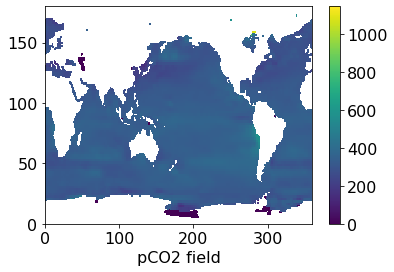

0 [303.1592232293655 309.53409552037715 309.6974792810749 307.43303118062266
 307.528747554536 311.5703421709665 318.3994853323005 324.95406173324267
 327.28095414604985 321.8667658999981 308.5113789323111 299.4886946761075]
1 [303.613678141981 308.7312807846161 308.7125367024336 308.1848499868913
 310.06519233101795 314.63493508402985 321.0456201517583
 327.53267968653995 329.72115612339644 323.8452451617377
 309.96593580274015 300.16201417294695]
2 [303.3565411299477 309.6623138436821 310.29288467464494 307.984291631165
 310.0976305809242 315.7243505603374 322.71967099616865 328.5513712726296
 329.5657519967729 322.801439693982 310.25457348367684 302.5563963358338]
3 [306.25395488780316 310.55372549638133 309.47033038349815
 307.6637710457244 309.8488586755581 314.6641110492169 320.77980013570783
 326.6370638887524 328.8595764879541 323.04740185562537 309.0442240654514
 299.5138827721935]
4 [303.4599946460311 309.62509263386715 310.6754233079463 310.0354554201524
 312.5526009999502 3

<class 'numpy.ndarray'>
N_noArc, apply some mask


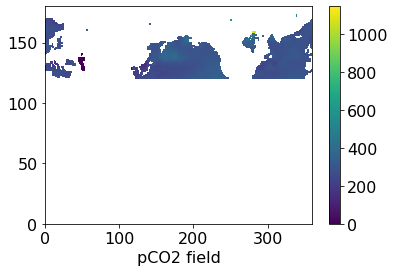

0 [269.7915246467783 268.0469345363169 265.72184401298875 264.61547475768214
 270.08475503225054 284.94818780028663 304.70096807616176
 316.18412935408344 310.7513402551338 296.10141028707216 283.0604609999667
 274.8663550357482]
1 [270.8602042233214 268.4136072392964 266.0586892577499 264.7170667931331
 269.2043875356306 282.52551262799096 302.7816041571152 315.8917141452073
 310.294750362488 295.841748019846 283.6166179476996 276.5418233285271]
2 [273.88670662549424 272.1149275122397 269.62842415139346 267.3223407540142
 270.4840917396579 283.90531940743546 305.37977541052794 319.4642855647423
 313.22696231874477 298.02165692414826 283.5122779217764 275.8425902545794]
3 [272.5431252137024 270.29507448638896 268.20833869805335 266.9524739050243
 271.6352432712268 286.0861108505899 306.68476392617976 318.775362384093
 312.49029522216165 298.92817341236486 285.91747882588345
 277.2261324891104]
4 [272.73458555953374 269.93233761530024 266.9023014715359
 265.62191411139105 270.2488067734

<class 'numpy.ndarray'>
Arc, apply some mask


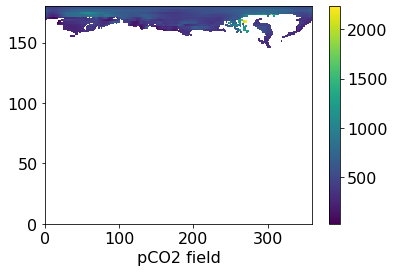

0 [473.0560708557247 463.45629786955254 466.70797420158095 473.0377529572056
 483.25535285999473 496.2256299685866 511.28679043952377 517.4831627464073
 511.77029399140116 504.81615253626717 497.3825320972428 493.0772164182734]
1 [491.32885368646043 490.2261858675964 492.3244175886788 499.21844510414957
 508.6170425386726 519.0843092605318 525.3000906641879 512.7084007593988
 503.9237706679794 503.6564215478062 502.557243299727 503.2269970913605]
2 [503.846011902807 506.2657927176621 511.87241060911595 519.5555698273579
 528.6021934385576 537.3513070772416 540.7272080501333 525.2217103500728
 512.7489504891537 513.9628174204653 515.5084876024918 516.0678847300846]
3 [516.2935390045501 516.0836667378388 515.8881939168682 514.9138451033859
 521.2084247282959 529.7577215607595 535.8961018039222 529.4956271500242
 523.0506785487686 523.4969326761626 525.7486944137329 527.3955865738917]
4 [528.2367714174029 531.2048377397535 536.60679283771 545.0840828731252
 558.3832013669418 572.614404371

<class 'numpy.ndarray'>
T, apply some mask


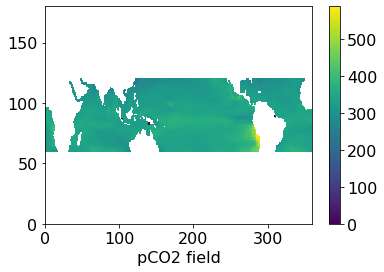

0 [317.78854533456894 319.8229509870559 321.6082383422157 322.344773888938
 321.33076529901473 318.5215054197936 315.66284198343016
 314.76003327117934 314.9114834151253 315.4867447651925 316.10453313968833
 316.8490477368108]
1 [317.37843076797117 318.36162524756276 319.34566792762536
 319.2631621445761 318.48281320286014 316.75748931674474 314.7955486532047
 313.76781858162946 314.02806576017076 315.02300421919074 315.751006778951
 316.16931074420313]
2 [316.9158006123945 318.0324140024123 319.34838182583536 320.01874686906956
 319.6650449906239 317.41348478203355 315.02290268379824 313.5857716870419
 313.7987734195479 315.1230591397176 316.1767127638243 316.6989961919805]
3 [317.46816768010615 318.7674753196031 319.95116220358227 320.6873832101159
 320.0895316048621 317.8213876107306 315.7259421040918 315.04713968669995
 315.1512713224937 316.31221404210174 317.5400707918943 317.98979863190374]
4 [318.466932185205 319.54899149593143 322.0154837086211 323.1876219033454
 322.740449756

<class 'numpy.ndarray'>
S, apply some mask


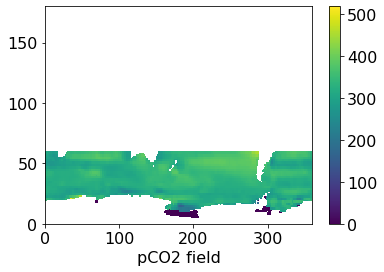

0 [303.1592232293655 309.53409552037715 309.6974792810749 307.43303118062266
 307.528747554536 311.5703421709665 318.3994853323005 324.95406173324267
 327.28095414604985 321.8667658999981 308.5113789323111 299.4886946761075]
1 [303.613678141981 308.7312807846161 308.7125367024336 308.1848499868913
 310.06519233101795 314.63493508402985 321.0456201517583
 327.53267968653995 329.72115612339644 323.8452451617377
 309.96593580274015 300.16201417294695]
2 [303.3565411299477 309.6623138436821 310.29288467464494 307.984291631165
 310.0976305809242 315.7243505603374 322.71967099616865 328.5513712726296
 329.5657519967729 322.801439693982 310.25457348367684 302.5563963358338]
3 [306.25395488780316 310.55372549638133 309.47033038349815
 307.6637710457244 309.8488586755581 314.6641110492169 320.77980013570783
 326.6370638887524 328.8595764879541 323.04740185562537 309.0442240654514
 299.5138827721935]
4 [303.4599946460311 309.62509263386715 310.6754233079463 310.0354554201524
 312.5526009999502 3

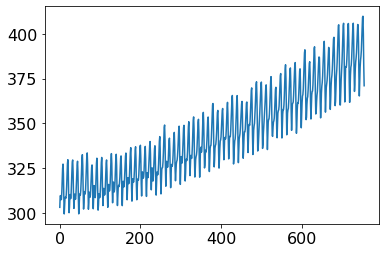

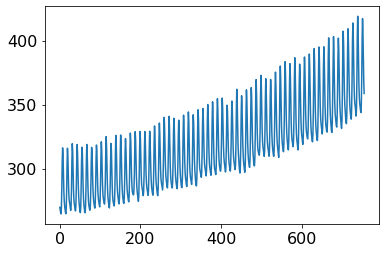

roeden pCO2 N_Arc, T
[490.96293558 504.34768151 519.31086202 523.26908435 558.64208458
 591.06187913 589.20186236 574.94035289 588.70974357 606.19153897
 625.73148131 650.78260465 658.11377575 636.52807608 628.61482899
 609.95347765 639.56136823 651.95784463 655.76027584 642.1391187
 643.52509463 664.42029749 670.40923213 646.69821999 635.33433355
 624.11556736 613.51503044 608.58333793 588.76999134 607.32864569
 617.76569534 608.56885229 584.35798546 554.58461212 547.25565408
 566.21637238 575.22691502 557.02514024 539.10178105 525.45095134
 537.53848272 570.41338462 566.21809586 542.8173653  540.37782118
 552.06408615 577.55141406 599.06888132 577.67877685 547.36760841
 537.86745779 552.28069212 552.78801428 543.92935986 519.15835201
 510.92991001 509.73677037 530.84704447 522.15264991 520.72726509
 514.24101718          nan          nan] [490.96293558 504.34768151 519.31086202 523.26908435 558.64208458
 591.06187913 589.20186236 574.94035289 588.70974357 606.19153897
 625.73148131 6

In [16]:
# do pco2 averaging also from 1x1 fields for Rödenbeck rather than from native mesh

# spco2 for Rödenbeck
#--------------------------------------------------------------------
# calculate means for spco2:

# calculate means for spco2:
regions=('global','glo_noArc','N_noArc','Arc','T','S') #'N','Arc','N60',

# sim A
for reg in regions:
        print(reg)
        exec('roeden_spco2_A_'+reg+'_ts, roeden_spco2_A_'+reg+'_am = reg_ave_pCO2(roeden_spco2_1x1_A,"'+reg+'",areaT,YY,reg_arcT)')
        exec('roeden_spco2_A_'+reg+'_am[(gcb_years>2018)]=np.nan')  # only later than 2018 for roedenbeck, (gcb_years<1982) | 

plt.figure()
plt.plot(roeden_spco2_A_N_noArc_ts)#, vmin=-60, vmax=750)

plt.show()

plt.figure()
plt.plot(roeden_spco2_A_glo_noArc_ts)#, vmin=-60, vmax=750)

plt.show()

print(roeden_spco2_A_N_noArc_am, roeden_spco2_A_glo_noArc_am)


# sim B
for reg in regions:
        print(reg)
        exec('roeden_spco2_B_'+reg+'_ts, roeden_spco2_B_'+reg+'_am = reg_ave_pCO2(roeden_spco2_1x1_B,"'+reg+'",areaT,YY,reg_arcT)')
        exec('roeden_spco2_B_'+reg+'_am[(gcb_years>2018)]=np.nan')

plt.figure()
plt.plot(roeden_spco2_B_glo_noArc_ts)#, vmin=-60, vmax=750)

plt.show()

plt.figure()
plt.plot(roeden_spco2_B_N_noArc_ts)#, vmin=-60, vmax=750)

plt.show()

print(roeden_spco2_B_glo_noArc_am, roeden_spco2_B_N_noArc_am)             
             
             
# sim C
for reg in regions:
        print(reg)
        exec('roeden_spco2_C_'+reg+'_ts, roeden_spco2_C_'+reg+'_am = reg_ave_pCO2(roeden_spco2_1x1_C,"'+reg+'",areaT,YY,reg_arcT)')
        exec('roeden_spco2_C_'+reg+'_am[(gcb_years>2018)]=np.nan')

plt.figure()
plt.plot(roeden_spco2_C_glo_noArc_ts)#, vmin=-60, vmax=750)

plt.show()

plt.figure()
plt.plot(roeden_spco2_C_N_noArc_ts)#, vmin=-60, vmax=750)

plt.show()

print('roeden pCO2 N_Arc, T')
print(roeden_spco2_C_Arc_am, roeden_spco2_C_Arc_am)             
                          



# roeden_spco2_A_glo= reg_ave_pCO2(roeden_spco2_1x1_A,'global',areaT,xax,yax)
# roeden_spco2_A_N= reg_ave_pCO2(roeden_spco2_1x1_A,'N',areaT,xax,yax)
# roeden_spco2_A_N60= reg_ave_pCO2(roeden_spco2_1x1_A,'N60',areaT,xax,yax)
# roeden_spco2_A_Arc= reg_ave_pCO2(roeden_spco2_1x1_A,'Arc',areaT,xax,yax)
# roeden_spco2_A_T= reg_ave_pCO2(roeden_spco2_1x1_A,'T',areaT,xax,yax)
# roeden_spco2_A_S= reg_ave_pCO2(roeden_spco2_1x1_A,'S',areaT,xax,yax)

# roeden_spco2_A_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_A_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_A_N60[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_A_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_A_T[(gcb_years<1982) | (gcb_years>2018) ]=np.nan
# roeden_spco2_A_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan


# print(roeden_spco2_A_glo)

# roeden_spco2_B_glo= reg_ave_pCO2(roeden_spco2_1x1_B,'global',areaT,xax,yax)
# roeden_spco2_B_N= reg_ave_pCO2(roeden_spco2_1x1_B,'N',areaT,xax,yax)
# roeden_spco2_B_N60= reg_ave_pCO2(roeden_spco2_1x1_B,'N60',areaT,xax,yax)
# roeden_spco2_B_Arc= reg_ave_pCO2(roeden_spco2_1x1_B,'Arc',areaT,xax,yax)
# roeden_spco2_B_T= reg_ave_pCO2(roeden_spco2_1x1_B,'T',areaT,xax,yax)
# roeden_spco2_B_S= reg_ave_pCO2(roeden_spco2_1x1_B,'S',areaT,xax,yax)

# roeden_spco2_B_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_B_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_B_N60[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_B_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_B_T[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_B_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan

# print(roeden_spco2_B_glo)

# roeden_spco2_C_glo= reg_ave_pCO2(roeden_spco2_1x1_C,'global',areaT,xax,yax)
# roeden_spco2_C_N= reg_ave_pCO2(roeden_spco2_1x1_C,'N',areaT,xax,yax)
# roeden_spco2_C_N60= reg_ave_pCO2(roeden_spco2_1x1_C,'N60',areaT,xax,yax)
# roeden_spco2_C_Arc= reg_ave_pCO2(roeden_spco2_1x1_C,'Arc',areaT,xax,yax)
# roeden_spco2_C_T= reg_ave_pCO2(roeden_spco2_1x1_C,'T',areaT,xax,yax)
# roeden_spco2_C_S= reg_ave_pCO2(roeden_spco2_1x1_C,'S',areaT,xax,yax)

# roeden_spco2_C_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_C_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_C_N60[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_C_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_C_T[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_C_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan

# print(roeden_spco2_C_glo)



In [17]:

# # Rödenbeck:
# roeden_fgco2_PgCyr_A_glo= integrate_CO2flux(roeden_fgco2_1x1_A,'global',areaT,xax,yax)
# roeden_fgco2_PgCyr_A_N= integrate_CO2flux(roeden_fgco2_1x1_A,'N',areaT,xax,yax)
# roeden_fgco2_PgCyr_A_T= integrate_CO2flux(roeden_fgco2_1x1_A,'T',areaT,xax,yax)
# roeden_fgco2_PgCyr_A_S= integrate_CO2flux(roeden_fgco2_1x1_A,'S',areaT,xax,yax)

# print(roeden_fgco2_PgCyr_A_glo)

# roeden_fgco2_PgCyr_B_glo= integrate_CO2flux(roeden_fgco2_1x1_B,'global',areaT,xax,yax)
# roeden_fgco2_PgCyr_B_N= integrate_CO2flux(roeden_fgco2_1x1_B,'N',areaT,xax,yax)
# roeden_fgco2_PgCyr_B_T= integrate_CO2flux(roeden_fgco2_1x1_B,'T',areaT,xax,yax)
# roeden_fgco2_PgCyr_B_S= integrate_CO2flux(roeden_fgco2_1x1_B,'S',areaT,xax,yax)

# print(roeden_fgco2_PgCyr_B_glo)

# roeden_fgco2_PgCyr_C_glo= integrate_CO2flux(roeden_fgco2_1x1_C,'global',areaT,xax,yax)
# roeden_fgco2_PgCyr_C_N= integrate_CO2flux(roeden_fgco2_1x1_C,'N',areaT,xax,yax)
# roeden_fgco2_PgCyr_C_T= integrate_CO2flux(roeden_fgco2_1x1_C,'T',areaT,xax,yax)
# roeden_fgco2_PgCyr_C_S= integrate_CO2flux(roeden_fgco2_1x1_C,'S',areaT,xax,yax)

# print(roeden_fgco2_PgCyr_C_glo)


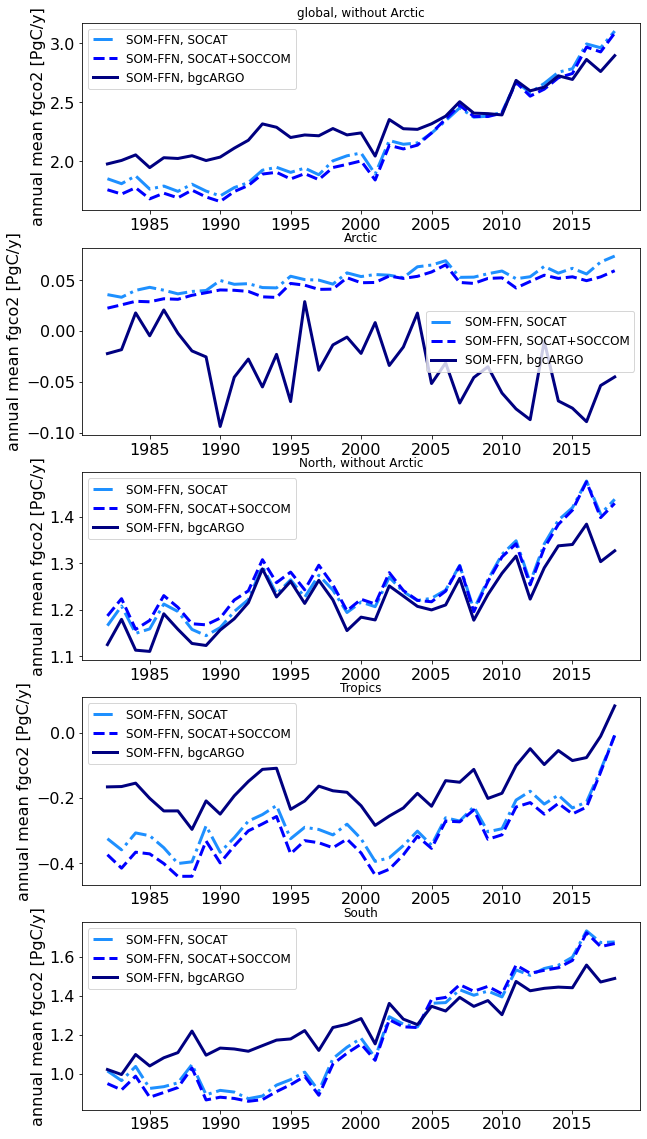

In [18]:
# plot: Landschützer CO2 flux

fig,ax = plt.subplots(5,1,figsize=(10,20))
#plt.figure(figsize=(8,8))

# global
ax1 = plt.subplot(5,1,1)
plt.plot(gcb_years,land_fgco2_PgCyr_A_glo_noArc,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_glo_noArc,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_glo_noArc,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

plt.legend()
plt.title('global, without Arctic')
plt.ylabel('annual mean fgco2 [PgC/y]')

# N-Arc
ax1 = plt.subplot(5,1,2)
plt.plot(gcb_years,land_fgco2_PgCyr_A_Arc,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_Arc,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_Arc,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

plt.legend()
plt.title('Arctic')
plt.ylabel('annual mean fgco2 [PgC/y]')

# N_noArc
ax1 = plt.subplot(5,1,3)
plt.plot(gcb_years,land_fgco2_PgCyr_A_N_noArc,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_N_noArc,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_N_noArc,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

plt.legend()
plt.title('North, without Arctic')
plt.ylabel('annual mean fgco2 [PgC/y]')

# T
ax1 = plt.subplot(5,1,4)
plt.plot(gcb_years,land_fgco2_PgCyr_A_T,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_T,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_T,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

plt.legend()
plt.title('Tropics')
plt.ylabel('annual mean fgco2 [PgC/y]')

# S
ax1 = plt.subplot(5,1,5)
plt.plot(gcb_years,land_fgco2_PgCyr_A_S,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_S,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_S,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

plt.legend()
plt.title('South')
plt.ylabel('annual mean fgco2 [PgC/y]')

plt.savefig('subsampling_Lflux_gloNTS_fesomkw.png',dpi=300,facecolor='w',transparent=False)
plt.show()

In [19]:
print(np.shape(gcb_years),np.shape(roeden_fgco2_PgCyr_A_glo))

(63,) (63,)


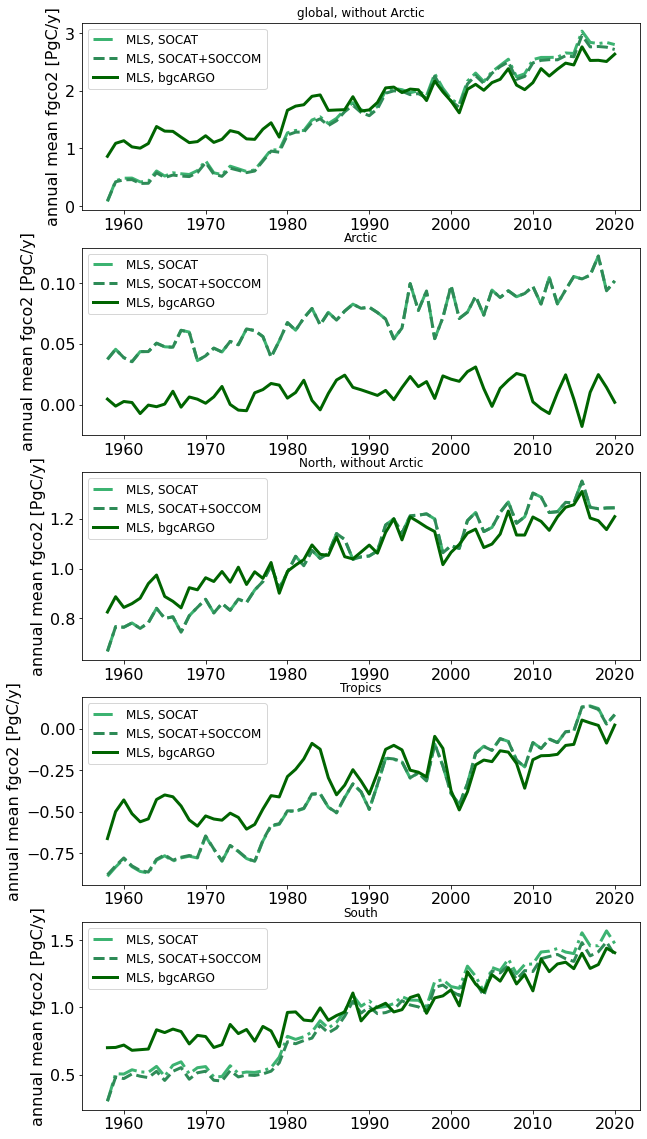

In [20]:
# plot: Rödenbeck
# here assuming the data came in Tmol/d, instead of Tmol/yr:

fig,ax = plt.subplots(5,1,figsize=(10,20))
#plt.figure(figsize=(8,8))

# global
ax1 = plt.subplot(5,1,1)
plt.plot(gcb_years,roeden_fgco2_PgCyr_A_glo_noArc,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_glo_noArc,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_glo_noArc,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

plt.legend()
plt.title('global, without Arctic')
plt.ylabel('annual mean fgco2 [PgC/y]')

# N-Arc
ax1 = plt.subplot(5,1,2)
plt.plot(gcb_years,roeden_fgco2_PgCyr_A_Arc,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_Arc,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_Arc,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

plt.legend()
plt.title('Arctic')
plt.ylabel('annual mean fgco2 [PgC/y]')

# N without Arctic
ax1 = plt.subplot(5,1,3)
plt.plot(gcb_years,roeden_fgco2_PgCyr_A_N_noArc,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_N_noArc,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_N_noArc,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

plt.legend()
plt.title('North, without Arctic')
plt.ylabel('annual mean fgco2 [PgC/y]')

# T
ax1 = plt.subplot(5,1,4)
plt.plot(gcb_years,roeden_fgco2_PgCyr_A_T,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_T,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_T,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

plt.legend()
plt.title('Tropics')
plt.ylabel('annual mean fgco2 [PgC/y]')

# S
ax1 = plt.subplot(5,1,5)
plt.plot(gcb_years,roeden_fgco2_PgCyr_A_S,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_S,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_S,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

plt.legend()
plt.title('South')
plt.ylabel('annual mean fgco2 [PgC/y]')

plt.savefig('subsampling_Rflux_OCIMprior_gloNTS.png',dpi=300,facecolor='w',transparent=False)
plt.show()

[0.96770561 1.25058837 1.27311613 1.13532327 1.08198878 1.18142414
 1.47824954 1.38144235 1.39144186 1.27060581 1.14398605 1.21577289
 1.27562041 1.1891878  1.28510892 1.39192482 1.37601489 1.22804509
 1.21964372 1.39032311 1.53789461 1.27208932 1.76955498 1.80775627
 1.86081705 2.03494987 2.02051727 1.73869375 1.75836318 1.7522121
 1.98802134 1.7529628  1.80699431 1.94238364 2.16275064 2.19991826
 2.08259171 2.10131625 2.09333394 1.93550248 2.26504206 2.14367893
 1.95060537 1.696257   2.1921021  2.22627987 2.14891837 2.28548899
 2.35045267 2.46351463 2.19304439 2.1326243  2.24007792 2.51426946
 2.36161079 2.49876414 2.61885225 2.55684282 2.90710819 2.6710983
 2.71217935 2.67674127]
0.5 1339200.0 (744, 180, 360)


/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:27: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad('white',1.)


shape(reg_arcT) (744, 180, 360)
region global
shape(mask) (744, 180, 360)


/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:116: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(reg_lon,reg_lat,np.squeeze(mask[1,:,:]))#, vmin=-60, vmax=750)


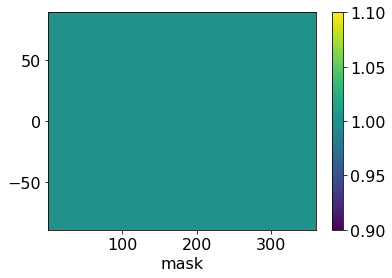

global
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
True
True
True
0 [1.1517664135668626 0.42674757364274535 0.46731912140906906
 0.9428513322646028 0.836355901496132 0.8708198152772764 0.981964205616793
 0.8564398485122265 0.5346966187672877 1.2643516993656065
 1.418989030182731 1.7236604812083205]
1 [1.228196975255577 0.8669653653641294 0.8914035065750471
 1.0200530109268888 1.1026784105916907 1.358247340663057 1.207156853817049
 1.041742028560982 0.7553453836271269 1.2544592613300536 2.129333965717803
 2.033304051449437]
2 [1.4303484651391223 0.8890233652381612 0.8279276351819035
 1.1152739818853428 1.3706166662674106 1.3113327163085422
 1.4366874800261011 0.782683280324746 0.9683316637022037
 1.1321055178170036 1.8242135869824825 2.013952164660032]
3 [1.32386481013642 0.848956637947975 0.7080952729820587 0.9245231207425848
 1.0638644830256183 1.1464202008131619 1.0887116859100132
 0.8422944751010871 0.6912126024888823 1.3163679398939319
 1.7193211129107615 1.842371953300534

shape(reg_arcT) (744, 180, 360)
region glo_noArc
shape(mask) (744, 180, 360)


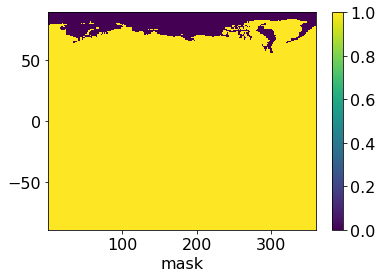

glo_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [1.1110681706818006 0.3851528683931458 0.43381254735149855
 0.9237480941549024 0.8081006307366104 0.8661289821323443
 0.9485569298406067 0.7966295357693309 0.47816234886888176
 1.21007871834028 1.3646631544733796 1.6770274872779283]
1 [1.186500959983193 0.8202403754905677 0.8529427386469347 1.00408139114648
 1.0887221357062815 1.3491900986360543 1.1462036862000609
 0.9534458254788024 0.6566636207516476 1.1892749678582306
 2.065762577263378 1.9776837236443972]
2 [1.3852032194481108 0.8454943856885561 0.7882594998146011
 1.086519897408194 1.3537424288067923 1.3140727294030001
 1.3965597328085244 0.6948427152773933 0.8920918481704458
 1.0586653062029325 1.775716494638024 1.9612406962822857]
3 [1.281465953422494 0.8153660251757227 0.7028569900847905
 0.9214552183412602 1.0537776382387618 1.1326453867340212
 1.051587267293727 0.7818600806447114 0.619261425277753 1.2650653460417567
 1.6499439613351983 1.7898110

shape(reg_arcT) (744, 180, 360)
region N
shape(mask) (744, 180, 360)


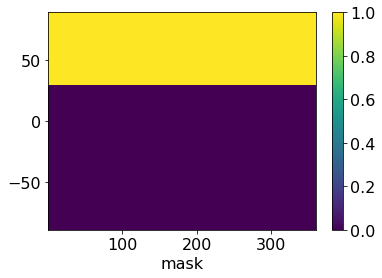

N
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [2.0260526069127303 1.8683973396574722 1.74831389078858 1.6612302542201576
 1.1510823685677578 0.4441752166383387 -0.1537512261609383
 -0.46419569494383195 -0.3866099416061635 0.28558666215324235
 0.9413516606059714 1.6496221285465282]
1 [1.9671898835092798 1.9666022012870548 2.0019470780159394
 1.6864164129964274 1.1412959345970675 0.6123624487318983
 -0.034796173053690434 -0.38987782118463676 -0.3081264094677766
 0.3963628139776841 1.2604554340171696 1.7954555556490706]
2 [1.846606130564416 1.9015352778925931 1.8106253220060091
 1.6191783192132199 1.2441384251771537 0.5523114314585127
 -0.09570729114680819 -0.455178688273305 -0.2811961327269132
 0.24636331511413928 1.1310047044767133 1.7641817047010184]
3 [1.9751311596565966 2.0032076480458545 1.8527276456252135
 1.638859682653455 1.2255548433808725 0.4933747046172444
 -0.15270286511292447 -0.4455221474897027 -0.2980229276208333
 0.2977512092357559 1.0492242849

shape(reg_arcT) (744, 180, 360)
region N_noArc
shape(mask) (744, 180, 360)


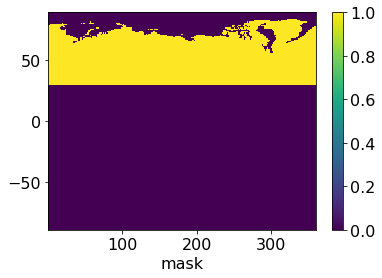

N_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [1.9853543640276679 1.8268026344078725 1.7148073167310094
 1.6421270161104573 1.1228270978082362 0.43948438349340674
 -0.18715850193712474 -0.5240060076867273 -0.44314421150456956
 0.23131368112791545 0.8870257848966195 1.602989134616136]
1 [1.9254938682368954 1.9198772114134928 1.963486310087827
 1.6704447932160182 1.127339659711658 0.6033052067048955
 -0.09574934067067839 -0.4781740242668162 -0.4068081723432557
 0.33117852050586105 1.1968840455627443 1.7398352278440314]
2 [1.8014608848734046 1.8580062983429877 1.770957186638707 1.590424234736071
 1.2272641877165353 0.5550514445529703 -0.13583503836438485
 -0.5430192533206577 -0.3574359482586712 0.1729231035000682
 1.0825076121322543 1.7114702363232726]
3 [1.93273230294267 1.9696170352736024 1.8474893627279454 1.6357917802521302
 1.2154679985940158 0.47959989053810365 -0.18982728372921076
 -0.5059565419460782 -0.3699741048319623 0.24644861538358057
 0.9798

shape(reg_arcT) (744, 180, 360)
region Arc
shape(mask) (744, 180, 360)


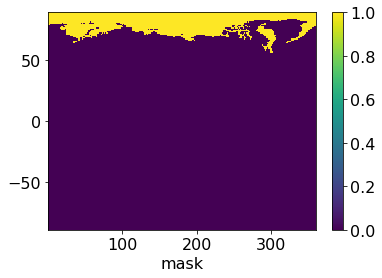

Arc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [0.04069824288506197 0.04159470524959958 0.03350657405757004
 0.019103238109700278 0.02825527075952152 0.004690833144931866
 0.03340727577618642 0.059810312742895486 0.05653426989840599
 0.054272981025326815 0.05432587570935144 0.0466329939303923]
1 [0.04169601527238447 0.04672498987356201 0.03846076792811241
 0.015971619780409285 0.013956274885409488 0.009057242027002836
 0.060953167616987956 0.08829620308217938 0.0986817628754791
 0.06518429347182303 0.06357138845442509 0.05562032780503889]
2 [0.045145245691011485 0.04352897954960523 0.03966813536730167
 0.028754084477148698 0.01687423746061842 -0.0027400130944576565
 0.040127747217576636 0.08784056504735267 0.07623981553175795
 0.07344021161407109 0.04849709234445896 0.052711468377746026]
3 [0.04239885671392655 0.03359061277225269 0.005238282897267879
 0.0030679024013248652 0.010086844786856525 0.013774814079140732
 0.03712441861628624 0.06043439445637563 0.

shape(reg_arcT) (744, 180, 360)
region T
shape(mask) (744, 180, 360)


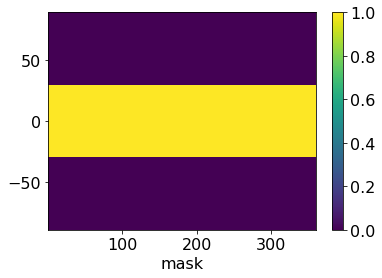

T
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.68433865761883 -0.8621722894991228 -0.7611195461428245
 -0.7743732544621936 -0.9098999204938081 -0.7773869465267351
 -0.4241677820987854 -0.2941488008524335 -0.4056010121413015
 -0.44841624685721354 -0.6027310469758627 -0.5580977897952643]
1 [-0.6006330787412201 -0.5138458029971474 -0.6029495591330136
 -0.6698944283526763 -0.6227218277322502 -0.37240961447191
 -0.2540878777631318 -0.17230930118209523 -0.2549252230651255
 -0.48334766615355385 -0.425786706035722 -0.47625442077662267]
2 [-0.377193976835936 -0.4342191254692499 -0.4790777805091006
 -0.4828135984070867 -0.5800173845622209 -0.4054396023565687
 -0.1202247917980598 -0.16521700054422114 -0.18154962157955912
 -0.38863138265115904 -0.4930209514984904 -0.4269657911196719]
3 [-0.4579588614615245 -0.5477573113665618 -0.6066264143741663
 -0.5774776196291034 -0.6165979092465288 -0.5346129849671528
 -0.25589649095136824 -0.2097668858029879 -0.4184509073334369


shape(reg_arcT) (744, 180, 360)
region S
shape(mask) (744, 180, 360)


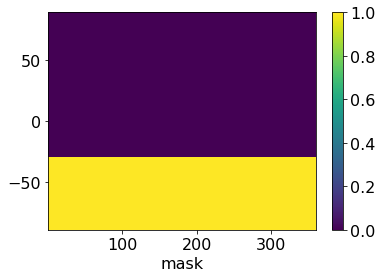

S
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.18994753572703713 -0.5794774765156034 -0.5198752232366864
 0.05599433250663867 0.5951734534221823 1.204031545165673
 1.5598832138765168 1.6147843443084917 1.3269075725147528
 1.4271812840695781 1.0803684165526226 0.6321361424570563]
1 [-0.13835982951248255 -0.5857910329257778 -0.5075940123078788
 0.003531026283138055 0.5841043037268734 1.1182945064030687
 1.4960409046338714 1.6039291509277136 1.3183970161600291
 1.341444113505923 1.2946652377363554 0.7141029165769889]
2 [-0.03906368858935761 -0.5782927871851818 -0.5036199063150052
 -0.02109073892079002 0.7064956256524778 1.1644608872065982
 1.6526195629709686 1.403078969142272 1.4310774180086763
 1.2743735853540232 1.18622983400426 0.6767362510786853]
3 [-0.19330748805865194 -0.6064936987313179 -0.5380059582689881
 -0.13685894228176693 0.4549075488912748 1.1876584811630706
 1.4973110419743059 1.4975835083937774 1.4076864374431524
 1.3839694405117298 1.1657002

(1, 120, 180, 360)
(180, 360)


<ipython-input-21-4ab31adaca09>:61: RuntimeWarning: Mean of empty slice
  fesom_fgco2_2009_2018 = np.nanmean(np.squeeze(fesom_fgco2_gridded[ind_2009_2018_monthly,:,:]),axis=0) # maybe double-check lengths of time-series,


In [21]:
# load model data, compare
# co2 flux

fesom= np.load('/work/ollie/jhauck/subsampling/fesom/fesom_reccap_A_1958_2019_fgco2_int.npz') 
co2flux_glo = fesom['co2flux']
co2flux_N = fesom['co2fluxN']
co2flux_T = fesom['co2fluxT']
co2flux_S = fesom['co2fluxS']

print(co2flux_glo)

#------------------------
# also gridded field:
# fgco2

in_data = Dataset('/work/ollie/jhauck/subsampling/fesom/fgco2_fesom_A_reg_1958_2019.nc',mode='r')

# mol/m2/s convert to mol/m2/yr later!! here keepin per s
fesom_fgco2_grid = in_data['fgco2'][:]

fesom_lon = in_data['Lon'][:]
fesom_lat = in_data['Lat'][:]
fesom_time = in_data['Time'][:]

# check whether it starts at 0 deg:
print(min(fesom_lon),min(fesom_time),np.shape(fesom_fgco2_grid))

# fill to have same length as Rö and filled Landschützer
#fesom_fgco2_1x1a = np.nan * np.zeros((tsteps,180,360))
#fesom_fgco2_1x1a[0:744,:,:] = fesom_fgco2_grid   # per s for integration routine
#fesom_fgco2_1x1 = np.ma.array(fesom_fgco2_1x1a, mask=np.isnan(fesom_fgco2_1x1a))
#print(np.shape(fesom_fgco2_1x1))

    


# calculate fesom for regions from gridded fields as well - incl Arc and N60
# routine assumes units mol/m2/s
fesom_fgco2_PgCyr_glo= integrate_CO2flux(fesom_fgco2_grid,'global',areaT[0:744,:,:],xax,yax)
fesom_fgco2_PgCyr_glo_noArc= integrate_CO2flux(fesom_fgco2_grid,'glo_noArc',areaT[0:744,:,:],xax,yax)
fesom_fgco2_PgCyr_N= integrate_CO2flux(fesom_fgco2_grid,'N',areaT[0:744,:,:],xax,yax)
fesom_fgco2_PgCyr_N_noArc= integrate_CO2flux(fesom_fgco2_grid,'N_noArc',areaT[0:744,:,:],xax,yax)
fesom_fgco2_PgCyr_Arc= integrate_CO2flux(fesom_fgco2_grid,'Arc',areaT[0:744,:,:],xax,yax)
fesom_fgco2_PgCyr_T= integrate_CO2flux(fesom_fgco2_grid,'T',areaT[0:744,:,:],xax,yax)
fesom_fgco2_PgCyr_S= integrate_CO2flux(fesom_fgco2_grid,'S',areaT[0:744,:,:],xax,yax)

print(fesom_fgco2_PgCyr_glo)

# fesom_fgco2_PgCyr_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_fgco2_PgCyr_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_fgco2_PgCyr_N60[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_fgco2_PgCyr_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_fgco2_PgCyr_T[(gcb_years<1982) | (gcb_years>2018) ]=np.nan
# fesom_fgco2_PgCyr_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan


fesom_fgco2_gridded = fesom_fgco2_grid*365.25*86400

# average over last ten years (for maps plotting)
print(np.shape(fesom_fgco2_gridded[ind_2009_2018_monthly,:,:]))
fesom_fgco2_2009_2018 = np.nanmean(np.squeeze(fesom_fgco2_gridded[ind_2009_2018_monthly,:,:]),axis=0) # maybe double-check lengths of time-series, 
# but this should be 2009-2018

print(np.shape(fesom_fgco2_2009_2018))

# np.save('fesom_fgco2_1x1_A_subsampling.npy',fesom_fgco2_PgCyr_glo_noArc=fesom_fgco2_PgCyr_glo_noArc,
#        fesom_fgco2_PgCyr_N_noArc=fesom_fgco2_PgCyr_N_noArc,
#        fesom_fgco2_PgCyr_T=fesom_fgco2_PgCyr_T,
#        fesom_fgco2_PgCyr_S=fesom_fgco2_PgCyr_S)


In [22]:
np.save('fesom_fgco2_1x1_glonoArc_subsampling.npy',fesom_fgco2_PgCyr_glo_noArc)
np.save('fesom_fgco2_1x1_NnoArc_subsampling.npy',fesom_fgco2_PgCyr_N_noArc)
np.save('fesom_fgco2_1x1_T_subsampling.npy',fesom_fgco2_PgCyr_T)
np.save('fesom_fgco2_1x1_S_subsampling.npy',fesom_fgco2_PgCyr_S)


#=fesom_fgco2_PgCyr_glo_noArc,
#        fesom_fgco2_PgCyr_N_noArc=fesom_fgco2_PgCyr_N_noArc,
#        fesom_fgco2_PgCyr_T=fesom_fgco2_PgCyr_T,
#        fesom_fgco2_PgCyr_S=fesom_fgco2_PgCyr_S)

In [23]:
# uses spCO2 which is only loaded in the next cell

# plt.figure()
# #plt.subplot(2,2,3)
# plt.pcolor(np.squeeze(land_spco2_1x1_A[ind1,:,:]))#, vmin=-60, vmax=750)
# plt.colorbar()
# plt.xlabel('spco2, land')
# plt.show()

# plt.figure()
# #plt.subplot(2,2,3)
# plt.pcolor(np.squeeze(fesom_spco2_gridded[ind1,:,:]), vmin=-60, vmax=750)
# plt.colorbar()
# plt.xlabel('spco2, fesom')
# plt.show()

# print(type(fesom_spco2_gridded))
# fesom_spco2_gridded_nd = fesom_spco2_gridded.data
# print(type(fesom_spco2_gridded_nd))

# print(np.shape(fesom_spco2_gridded))
# print(np.shape(land_spco2_1x1_A))

# print(np.nanmin(fesom_spco2_gridded))
# print(np.min(land_spco2_1x1_A))

0.5 1339200.0 (744, 180, 360)
global
shape reg_arcT (744, 180, 360)
shape intYY (744, 180, 360)
<class 'numpy.ndarray'>
global, just return from if loop


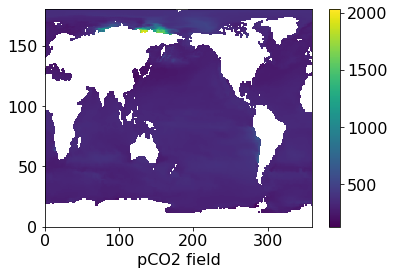

0 [304.367001911194 312.9504691242416 312.90249711619146 310.7781533179911
 313.2223925740311 319.1747134997625 325.53843485042165 332.63941361309844
 338.97935742609707 334.6282460929455 318.4732820349826 300.150528042138]
1 [304.71082803716996 312.6814795768301 312.23803515448594
 312.10506083325623 316.1570487526432 321.3711782900467 327.8068819774208
 331.03381453621165 337.8395764392834 336.2989587674926 320.13942765355773
 300.6650419094889]
2 [304.9066137740904 314.0647445779453 313.0337571517328 312.566013891415
 316.20318648865174 324.1376855025985 329.157273937175 333.2990356331167
 339.43668133348234 338.16656261259885 320.99514402022896
 302.08547882736354]
3 [307.8756714808405 314.32170734737053 312.72525652240694
 311.67133232468245 316.55987839618854 322.38983275949647
 327.64057790006376 332.3993110496313 337.8345845164831 336.68002861503254
 318.6191138606115 300.66435835740367]
4 [304.86596531311926 312.5586852784751 313.40092977778994
 314.11373619336746 318.98867418

<class 'numpy.ndarray'>
global no Arc, apply some mask


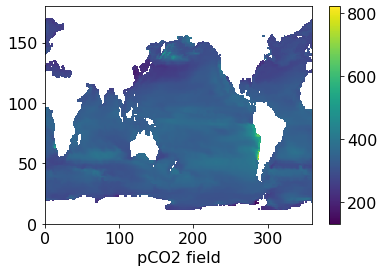

0 [300.5467941414559 309.68373278240557 309.5516189794181 307.20030195154686
 309.76859546575537 316.17769165935465 323.4715179588612 332.244677244616
 338.73437381705804 333.4503094015751 315.6696972720569 295.7776736454857]
1 [300.54845523910774 309.0136192489999 308.44040187192405 308.2196078576496
 312.53601696779987 318.29998773178926 326.829642003228 332.58109728879344
 339.00371305593654 335.71987171309854 317.5225412709618
 296.21199334157336]
2 [300.5602901504463 310.29313915170565 309.07931703973554
 308.50192853621223 312.37373913623173 321.23854130027416 329.162938167165
 335.63686082402694 340.8209561060759 337.7061605223305 318.4984774381637
 297.76236844660343]
3 [303.78337842455187 310.5914954739593 308.797468554778 307.69547523510954
 312.9407078105306 319.37289515485173 326.50747140760797 334.81839533119
 339.21019824370245 336.2272873935436 316.0556529357304 296.34213869911133]
4 [300.7133694583332 308.8891046488642 309.7066983454891 310.42210194288475
 315.602123963

<class 'numpy.ndarray'>
N_noArc, apply some mask


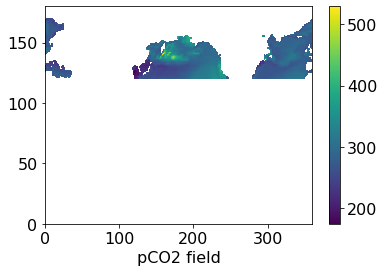

0 [270.43700821471515 269.08580430458403 267.6821809972629 264.4109433013255
 263.2242655069594 279.29414422363817 307.44226990920333
 322.35278049982446 316.03465497034836 296.69922038967417
 282.2140349391415 274.2127865049255]
1 [270.5123571458516 269.0889824267869 267.72324820707524 264.00925017395485
 262.4366063925184 276.9702823519797 303.5366201044982 321.8694488376248
 314.2324993814721 295.6457181003804 281.04605914105184 273.7318177410974]
2 [273.0077188222563 271.5757430760866 269.423894356388 265.9689599598923
 263.2029629406788 278.8719669243803 308.87241145742655 326.9399959435129
 317.97911261351817 297.8281763165146 280.9544297367267 273.43397375654297]
3 [271.2097880320903 270.217640270397 268.75204297477075 265.5321885692656
 263.67492669966083 280.53383352257623 309.2110173163421
 327.03939522043015 316.14061739335574 299.25020568866313
 283.7941766542807 275.4255320430717]
4 [272.11525794030655 270.6907357976352 269.0850688644114 264.89409368878705
 262.83480873520

<class 'numpy.ndarray'>
Arc, apply some mask


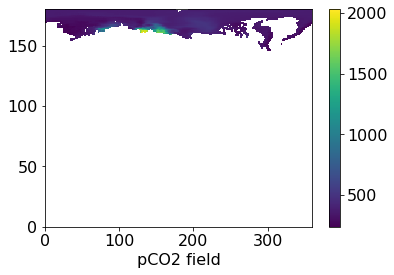

0 [355.47833906384466 356.6567994131425 357.7345776021738 358.6469548321407
 359.4314469234592 359.2724785879283 353.1921365542679 337.9206718147437
 342.25704298489256 350.3881007935279 355.98301309962454
 358.65583687827785]
1 [360.40006073337173 361.75452930192836 363.0473436493632 364.0893268724348
 364.6035698716461 362.4612617474434 340.88157445767763 310.33240372181706
 322.264355746618 344.0466823107855 355.1512830951825 360.24328488224296]
2 [363.0569619992171 364.5258210864934 365.94101612736586 366.94023888838734
 367.43814189823246 362.92592575302655 329.0814910514836 302.0207966632067
 320.9161874550061 344.3263758688037 354.39855428616903 359.9252523521179]
3 [362.6272930508257 364.2289710891573 365.2759310349012 364.86513340159405
 364.9814981525408 362.7540549101884 342.8006402465512 300.0338901699439
 319.429968526567 342.7373455488736 352.91617923154246 358.49221472500136]
4 [360.4243902956497 361.65475127117315 362.82680387604483
 363.50486206755767 364.2980187451144

<class 'numpy.ndarray'>
T, apply some mask


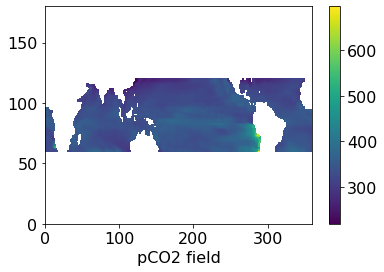

0 [318.4508924086528 320.17297173641583 322.004085730271 323.0145394967508
 321.5968570229111 318.86151615420584 315.5564940130926 314.98347661028555
 314.89248799378674 315.4545030222992 315.8097027286169 317.0363269054358]
1 [316.98549161791624 318.01009613617316 319.5487039592236
 319.28420662915886 318.73564135560406 317.08359812373794
 315.0942975160323 313.7233365734409 314.2674882204677 315.15120210335357
 315.84549839913825 316.1249932771538]
2 [317.1580148454104 317.9164032962949 319.68215834907045 320.1254824721149
 320.0029767808848 317.3786868874732 315.1587738172728 313.56959084949557
 314.03740903313485 315.5002981124548 316.23828665321014
 316.84120278289026]
3 [317.3713830546549 318.95185739541506 320.0940791776697 320.98820904489827
 320.32895884588277 317.93754718449827 315.7195930601299 314.9727333113202
 315.03084676212916 316.42201712816046 317.2262290987089
 317.97593373680263]
4 [318.61696981014114 319.13187802288917 322.32447078764085
 323.55892431346723 323.094

<class 'numpy.ndarray'>
S, apply some mask


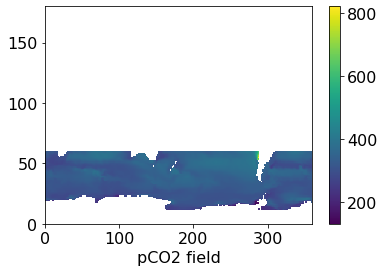

0 [300.5467941414559 309.68373278240557 309.5516189794181 307.20030195154686
 309.76859546575537 316.17769165935465 323.4715179588612 332.244677244616
 338.73437381705804 333.4503094015751 315.6696972720569 295.7776736454857]
1 [300.54845523910774 309.0136192489999 308.44040187192405 308.2196078576496
 312.53601696779987 318.29998773178926 326.829642003228 332.58109728879344
 339.00371305593654 335.71987171309854 317.5225412709618
 296.21199334157336]
2 [300.5602901504463 310.29313915170565 309.07931703973554
 308.50192853621223 312.37373913623173 321.23854130027416 329.162938167165
 335.63686082402694 340.8209561060759 337.7061605223305 318.4984774381637
 297.76236844660343]
3 [303.78337842455187 310.5914954739593 308.797468554778 307.69547523510954
 312.9407078105306 319.37289515485173 326.50747140760797 334.81839533119
 339.21019824370245 336.2272873935436 316.0556529357304 296.34213869911133]
4 [300.7133694583332 308.8891046488642 309.7066983454891 310.42210194288475
 315.602123963

(180, 360)


<ipython-input-24-87a1668ea4db>:51: RuntimeWarning: Mean of empty slice
  fesom_spco2_2009_2018 = np.nanmean(np.squeeze(fesom_spco2_gridded[ind_2009_2018_monthly,:,:]),axis=0) # maybe double-check lengths of time-series,


In [24]:
# fesom
#---------------------------
# now spco2

in_data = Dataset('/work/ollie/jhauck/subsampling/fesom/spco2_fesom_A_reg_1958_2019.nc',mode='r')

# mol/m2/s convert to mol/m2/yr
fesom_spco2_gridded = in_data['spco2'][:]

fesom_lon = in_data['Lon'][:]
fesom_lat = in_data['Lat'][:]
fesom_time = in_data['Time'][:]

# check whether it starts at 0 deg:
print(min(fesom_lon),min(fesom_time),np.shape(fesom_spco2_gridded))

# again trouble with negative numbers (ha, no data types trouble this time)
ftest = np.copy(fesom_spco2_gridded.data)
ftest[ftest<0]=np.nan

# # fill to have same length as Rö and filled Landschützer
# fesom_spco2_1x1 = np.nan * np.zeros((tsteps,180,360))
# fesom_spco2_1x1[0:744,:,:] = fesom_spco2_gridded
# print(np.shape(fesom_spco2_1x1))

# calc regional averages from gridded fields

for reg in regions:
        print(reg)
        exec('fesom_spco2_'+reg+'_ts, fesom_spco2_'+reg+'_am = reg_ave_pCO2(ftest,"'+reg+'",fareaT,fYY,freg_arcT)')
#        exec('fesom_spco2_'+reg+'_ts, fesom_spco2_'+reg+'_am = reg_ave_pCO2(fesom_spco2_gridded.data,"'+reg+'",fareaT,fYY)')
#        exec('fesom_spco2_'+reg+'_am[(gcb_years[:-1]>2018)]=np.nan')  # only later than 2018 for roedenbeck, (gcb_years<1982) | 


# fesom_spco2_glo= reg_ave_pCO2(fesom_spco2_gridded,'global',areaT[0:744,:,:],xax,yax)
# fesom_spco2_N= reg_ave_pCO2(fesom_spco2_gridded,'N',areaT[0:744,:,:],xax,yax)
# fesom_spco2_N60= reg_ave_pCO2(fesom_spco2_gridded,'N60',areaT[0:744,:,:],xax,yax)
# fesom_spco2_Arc= reg_ave_pCO2(fesom_spco2_gridded,'Arc',areaT[0:744,:,:],xax,yax)
# fesom_spco2_T= reg_ave_pCO2(fesom_spco2_gridded,'T',areaT[0:744,:,:],xax,yax)
# fesom_spco2_S= reg_ave_pCO2(fesom_spco2_gridded,'S',areaT[0:744,:,:],xax,yax)

print(fesom_spco2_global_am)
# fesom_spco2_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_spco2_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_spco2_N60[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_spco2_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_spco2_T[(gcb_years<1982) | (gcb_years>2018) ]=np.nan
# fesom_spco2_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan

# average over last ten years (for maps plotting)
fesom_spco2_2009_2018 = np.nanmean(np.squeeze(fesom_spco2_gridded[ind_2009_2018_monthly,:,:]),axis=0) # maybe double-check lengths of time-series, 
# but this should be 2009-2018

print(np.shape(fesom_spco2_2009_2018))

In [25]:
# print(np.shape(fesom_fgco2_gridded))


# plt.figure()
# #plt.subplot(2,2,3)
# plt.pcolor(np.squeeze(fesom_fgco2_gridded[ind1,:,:]))#, vmin=-60, vmax=750)
# plt.colorbar()
# plt.xlabel('fgco2, fesom gridded')
# plt.show()


# plt.figure()
# #plt.subplot(2,2,3)
# plt.pcolor(np.squeeze(fesom_fgco2_grid[ind1,:,:]))#, vmin=-60, vmax=750)
# plt.colorbar()
# plt.xlabel('fgco2, fesom grid')
# plt.show()


# plt.figure()
# #plt.subplot(2,2,3)
# plt.pcolor(np.squeeze(fesom_fgco2_1x1a[ind1,:,:]))#, vmin=-60, vmax=750)
# plt.colorbar()
# plt.xlabel('fgco2, fesom 1x1')
# plt.show()

In [26]:
print(np.shape(co2flux_glo))

(62,)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


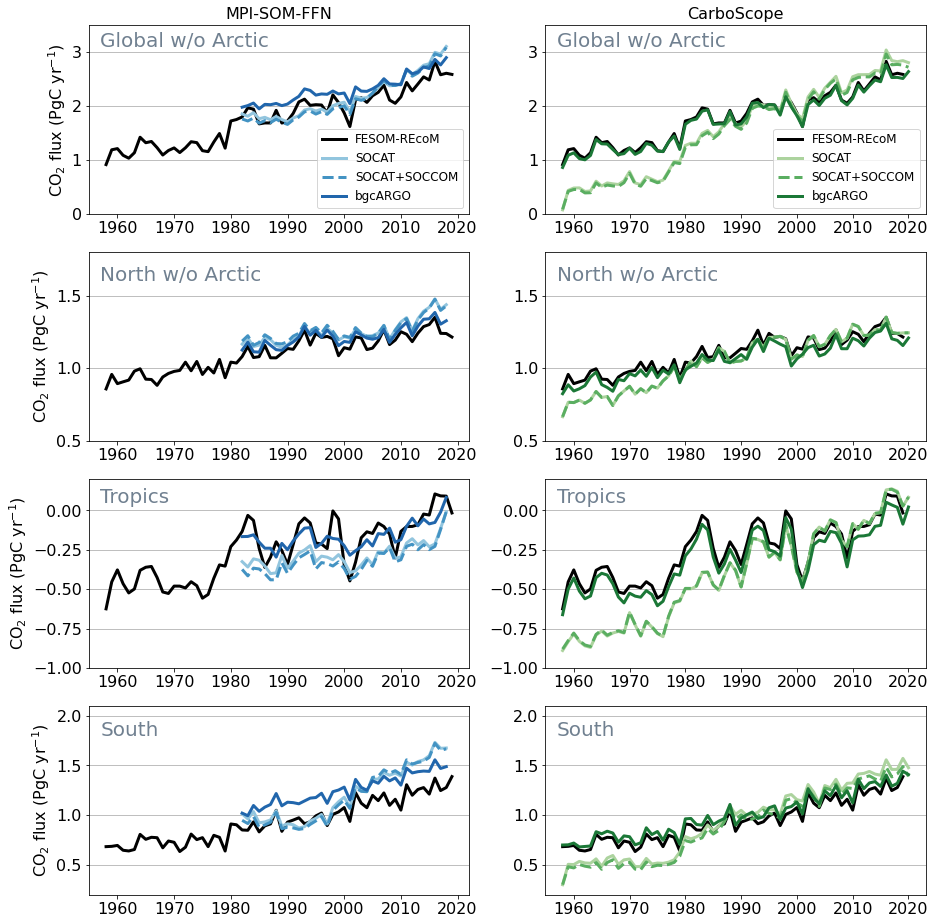

In [27]:
# now plot both products together with the known truth:


fig,ax = plt.subplots(4,2,figsize=(15,16))
#plt.figure(figsize=(8,8))

# left: Landschützer

# global
ax1 = plt.subplot(4,2,1)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_glo_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years,land_fgco2_PgCyr_A_glo_noArc,color='#92C5DE',linestyle='solid',linewidth='3',label='SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_glo_noArc,color='#4393C3',linestyle='dashed',linewidth='3',label='SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_glo_noArc,color='#2166AC',linestyle='solid',linewidth='3',label='bgcARGO')

plt.legend(loc=4)
plt.title('MPI-SOM-FFN', fontsize=16)#Global without Arctic')
plt.text(1957,3.1,'Global w/o Arctic',fontsize=20,color='slategrey')

plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0,3.5) 
plt.grid(b=None, which='major', axis='y')

# # N-Arc
# ax1 = plt.subplot(5,2,3)
# plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_Arc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

# plt.plot(gcb_years,land_fgco2_PgCyr_A_Arc,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
# plt.plot(gcb_years,land_fgco2_PgCyr_B_Arc,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
# plt.plot(gcb_years,land_fgco2_PgCyr_C_Arc,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

# #plt.legend()
# plt.title('Arctic')
# plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
# plt.ylim(-0.15,0.2) 
# plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,3)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_N_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,land_fgco2_PgCyr_A_N_noArc,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_N_noArc,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_N_noArc,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.legend()
#plt.title('North without Arctic')
plt.text(1957,1.6,'North w/o Arctic',fontsize=20,color='slategrey')
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.5,1.8) 
plt.grid(b=None, which='major', axis='y')

# T
ax1 = plt.subplot(4,2,5)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_T,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,land_fgco2_PgCyr_A_T,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_T,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_T,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.legend()
#plt.title('Tropics')
plt.text(1957,0.05,'Tropics',fontsize=20,color='slategrey')
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(-1.0,0.2) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,7)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_S,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years,land_fgco2_PgCyr_A_S,color='#92C5DE',linestyle='solid',linewidth='3',label='SSOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_S,color='#4393C3',linestyle='dashed',linewidth='3',label='SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_S,color='#2166AC',linestyle='solid',linewidth='3',label='bgcARGO')

#plt.title('South')
plt.text(1957,1.8,'South',fontsize=20,color='slategrey')

#plt.legend()
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.2,2.1) 
plt.grid(b=None, which='major', axis='y')

#------------------------------------------------------------
# right: Rödenbeck

# global
ax1 = plt.subplot(4,2,2)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_glo_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years,roeden_fgco2_PgCyr_A_glo_noArc,color='#ACD39E',linewidth=3,linestyle='solid',label='SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_glo_noArc,color='#5AAE61',linewidth=3,linestyle='dashed',label='SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_glo_noArc,color='#1B7837',linewidth=3,linestyle='solid',label='bgcARGO')

plt.legend(loc=4)
plt.title('CarboScope',fontsize=16)# global without Arctic')
#plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0,3.5) 
plt.grid(b=None, which='major', axis='y')
plt.text(1957,3.1,'Global w/o Arctic',fontsize=20,color='slategrey')

# # Arc
# ax1 = plt.subplot(5,2,4)
# plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_Arc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

# plt.plot(gcb_years,roeden_fgco2_PgCyr_A_Arc,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
# plt.plot(gcb_years,roeden_fgco2_PgCyr_B_Arc,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
# plt.plot(gcb_years,roeden_fgco2_PgCyr_C_Arc,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

# #plt.legend()
# plt.title('Arctic')
# plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
# plt.ylim(-0.15,0.2) 
# plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,4)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_N_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,roeden_fgco2_PgCyr_A_N_noArc,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_N_noArc,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_N_noArc,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.legend()
#plt.title('North without Arctic')
plt.text(1957,1.6,'North w/o Arctic',fontsize=20,color='slategrey')
#plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.5,1.8) 
plt.grid(b=None, which='major', axis='y')

# T
ax1 = plt.subplot(4,2,6)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_T,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,roeden_fgco2_PgCyr_A_T,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_T,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_T,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.legend()
#plt.title('Tropics')
plt.text(1957,0.05,'Tropics',fontsize=20,color='slategrey')

#plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(-1.0,0.2) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,8)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_S,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years,roeden_fgco2_PgCyr_A_S,color='#ACD39E',linewidth=3,linestyle='solid',label='SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_S,color='#5AAE61',linewidth=3,linestyle='dashed',label='SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_S,color='#1B7837',linewidth=3,linestyle='solid',label='bgcARGO')

#plt.title('South')
plt.text(1957,1.8,'South',fontsize=20,color='slategrey')
#plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.2,2.1) 
plt.grid(b=None, which='major', axis='y')
#plt.legend()
plt.savefig('subsampling_FLRflux_gloNTS_noArc_OCIM_prior_fesomkw.png',dpi=300,facecolor='w',transparent=False)
plt.savefig('subsampling_FLRflux_gloNTS_noArc_OCIMprior_fesomkw.pdf',facecolor='w',transparent=False)
plt.savefig('subsampling_FLRflux_gloNTS_noArc_OCIMprior_fesomkw.eps',facecolor='w',transparent=False)

plt.show()

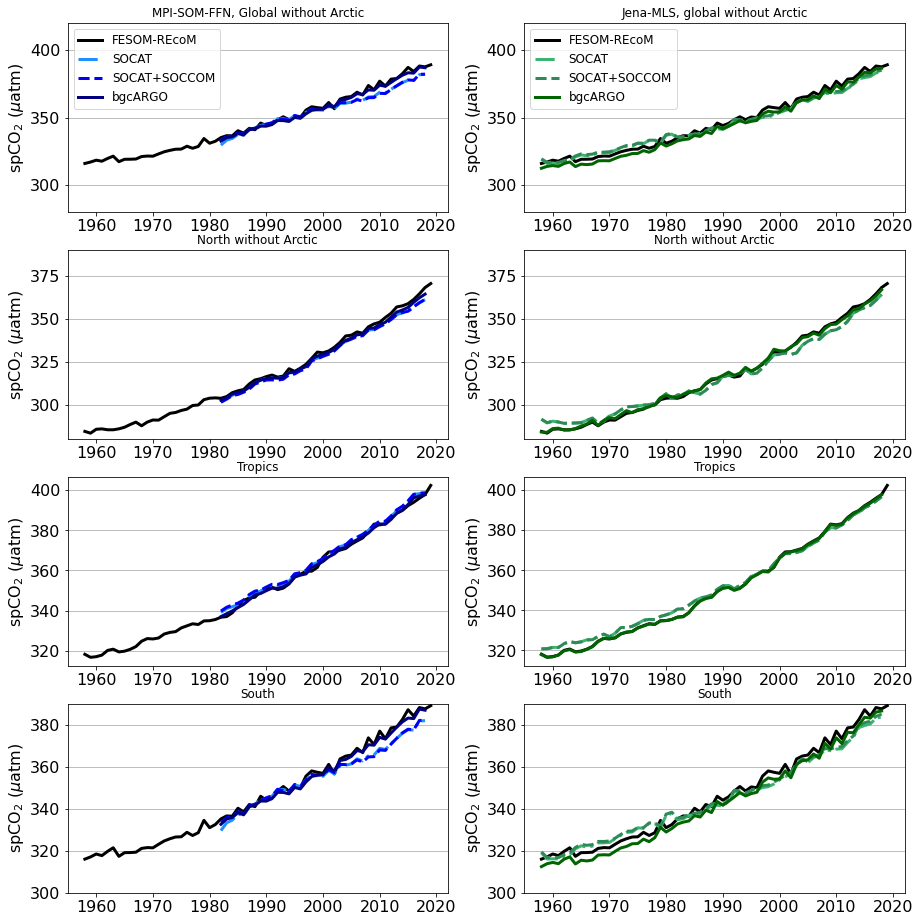

In [28]:
# same figure for pco2

# now plot both products together with the known truth:


fig,ax = plt.subplots(5,2,figsize=(15,16))
#plt.figure(figsize=(8,8))

# left: Landschützer

# global
ax1 = plt.subplot(4,2,1)
plt.plot(gcb_years[:-1],fesom_spco2_glo_noArc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years,land_spco2_A_glo_noArc_am,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOCAT')
plt.plot(gcb_years,land_spco2_B_glo_noArc_am,color='blue',linestyle='dashed',linewidth='3',label='SOCAT+SOCCOM')
plt.plot(gcb_years,land_spco2_C_glo_noArc_am,color='navy',linestyle='solid',linewidth='3',label='bgcARGO')

plt.legend()
plt.title('MPI-SOM-FFN, Global without Arctic')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(280,420) 
plt.grid(b=None, which='major', axis='y')

# # N-Arc
# ax1 = plt.subplot(5,2,3)
# plt.plot(gcb_years[:-1],fesom_spco2_Arc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

# plt.plot(gcb_years,land_spco2_A_Arc_am,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
# plt.plot(gcb_years,land_spco2_B_Arc_am,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
# plt.plot(gcb_years,land_spco2_C_Arc_am,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

# #plt.legend()
# plt.title('Arctic')
# plt.ylabel('spCO$_2$ ($\mu$atm)')
# plt.ylim(180,660) 
# plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,3)
plt.plot(gcb_years[:-1],fesom_spco2_N_noArc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,land_spco2_A_N_noArc_am,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_spco2_B_N_noArc_am,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_spco2_C_N_noArc_am,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.legend()
plt.title('North without Arctic')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(280,390) 
plt.grid(b=None, which='major', axis='y')

# T
ax1 = plt.subplot(4,2,5)
plt.plot(gcb_years[:-1],fesom_spco2_T_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,land_spco2_A_T_am,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_spco2_B_T_am,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_spco2_C_T_am,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.legend()
plt.title('Tropics')
plt.ylabel('spCO$_2$ ($\mu$atm)')
#plt.ylim(280,420) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,7)
plt.plot(gcb_years[:-1],fesom_spco2_S_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,land_spco2_A_S_am,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_spco2_B_S_am,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_spco2_C_S_am,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

plt.title('South')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(300,390) 
plt.grid(b=None, which='major', axis='y')

#------------------------------------------------------------
# right: Rödenbeck

# global
ax1 = plt.subplot(4,2,2)
plt.plot(gcb_years[:-1],fesom_spco2_glo_noArc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years,roeden_spco2_A_glo_noArc_am,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='SOCAT')
plt.plot(gcb_years,roeden_spco2_B_glo_noArc_am,color='seagreen',linewidth=3,linestyle='dashed',label='SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_spco2_C_glo_noArc_am,color='darkgreen',linewidth=3,linestyle='solid',label='bgcARGO')

plt.legend()
plt.title('Jena-MLS, global without Arctic')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(280,420) 
plt.grid(b=None, which='major', axis='y')

# # Arc
# ax1 = plt.subplot(5,2,4)
# plt.plot(gcb_years[:-1],fesom_spco2_Arc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

# plt.plot(gcb_years,roeden_spco2_A_Arc_am,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
# plt.plot(gcb_years,roeden_spco2_B_Arc_am,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
# plt.plot(gcb_years,roeden_spco2_C_Arc_am,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

# #plt.legend()
# plt.title('Arctic')
# plt.ylabel('spCO$_2$ ($\mu$atm)')
# plt.ylim(180,660) 
# plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,4)
plt.plot(gcb_years[:-1],fesom_spco2_N_noArc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,roeden_spco2_A_N_noArc_am,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_spco2_B_N_noArc_am,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_spco2_C_N_noArc_am,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.legend()
plt.title('North without Arctic')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(280,390) 
plt.grid(b=None, which='major', axis='y')

# T
ax1 = plt.subplot(4,2,6)
plt.plot(gcb_years[:-1],fesom_spco2_T_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,roeden_spco2_A_T_am,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_spco2_B_T_am,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_spco2_C_T_am,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.legend()
plt.title('Tropics')
plt.ylabel('spCO$_2$ ($\mu$atm)')
#plt.ylim(280,420) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,8)
plt.plot(gcb_years[:-1],fesom_spco2_S_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,roeden_spco2_A_S_am,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_spco2_B_S_am,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_spco2_C_S_am,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

plt.title('South')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(300,390) 
plt.grid(b=None, which='major', axis='y')

plt.savefig('subsampling_FLRspco2_gloNTS_noArc_OCIMprior_fesomkw.png',dpi=300,facecolor='w',transparent=False)
plt.show()




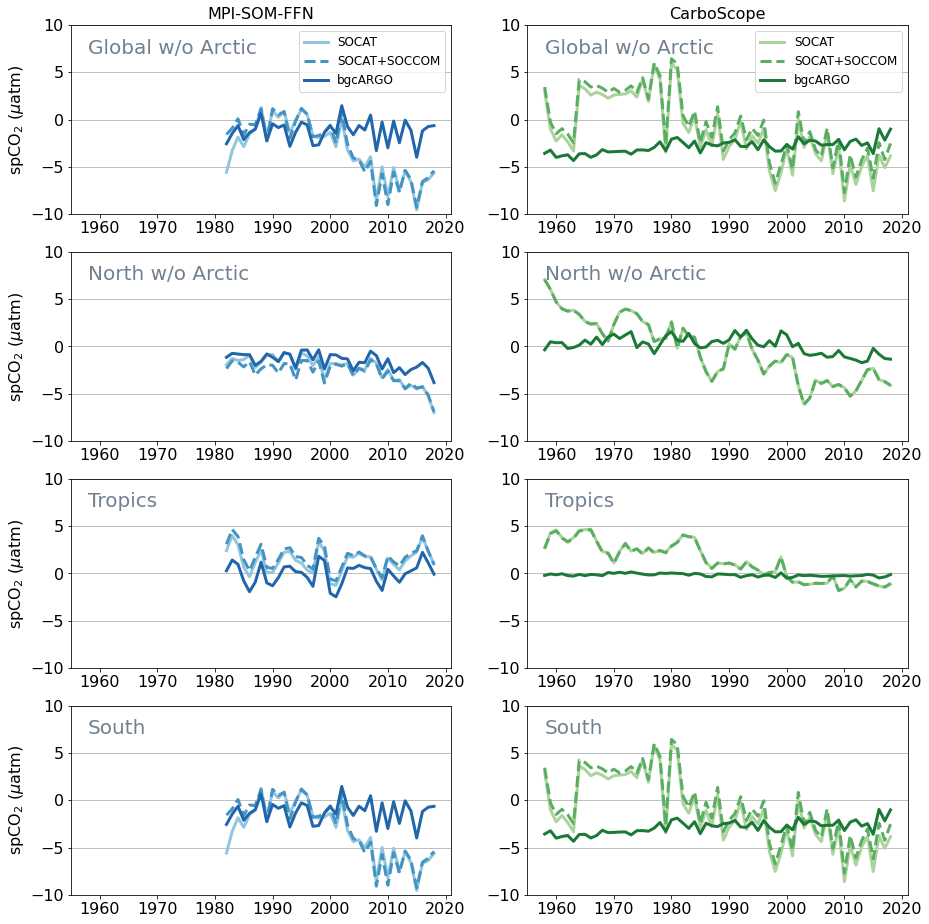

In [29]:
# plot difference in pCO2 rather than absolute values


fig,ax = plt.subplots(4,2,figsize=(15,16))
#plt.figure(figsize=(8,8))

# left: Landschützer

# global
ax1 = plt.subplot(4,2,1)
#plt.plot(gcb_years[:-1],fesom_spco2_global_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years[:-1],land_spco2_A_glo_noArc_am[:-1]-fesom_spco2_glo_noArc_am,color='#92C5DE',linestyle='solid',linewidth='3',label='SOCAT')
plt.plot(gcb_years[:-1],land_spco2_B_glo_noArc_am[:-1]-fesom_spco2_glo_noArc_am,color='#4393C3',linestyle='dashed',linewidth='3',label='SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],land_spco2_C_glo_noArc_am[:-1]-fesom_spco2_glo_noArc_am,color='#2166AC',linestyle='solid',linewidth='3',label='bgcARGO')

plt.legend(loc='upper right')
plt.title('MPI-SOM-FFN', fontsize=16)#Global without Arctic')
plt.text(1958,7,'Global w/o Arctic',fontsize=20,color='slategrey')

#plt.text()
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.xlim(1955,2021) 

plt.grid(b=None, which='major', axis='y')

# # N-Arc
# ax1 = plt.subplot(5,2,3)
# #plt.plot(gcb_years[:-1],fesom_spco2_Arc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

# plt.plot(gcb_years[:-1],land_spco2_A_Arc_am[:-1]-fesom_spco2_Arc_am,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
# plt.plot(gcb_years[:-1],land_spco2_B_Arc_am[:-1]-fesom_spco2_Arc_am,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
# plt.plot(gcb_years[:-1],land_spco2_C_Arc_am[:-1]-fesom_spco2_Arc_am,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

# #plt.legend()
# plt.title('Arctic')
# plt.ylabel('spCO$_2$ ($\mu$atm)')
# plt.ylim(-250,300) 
# plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,3)
#plt.plot(gcb_years[:-1],fesom_spco2_N60_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years[:-1],land_spco2_A_N_noArc_am[:-1]-fesom_spco2_N_noArc_am,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years[:-1],land_spco2_B_N_noArc_am[:-1]-fesom_spco2_N_noArc_am,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],land_spco2_C_N_noArc_am[:-1]-fesom_spco2_N_noArc_am,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.legend()
plt.text(1958,7,'North w/o Arctic',fontsize=20,color='slategrey')
#plt.title('North without Arctic')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.xlim(1955,2021) 
plt.grid(b=None, which='major', axis='y')

# T
ax1 = plt.subplot(4,2,5)
#plt.plot(gcb_years[:-1],fesom_spco2_T_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years[:-1],land_spco2_A_T_am[:-1]-fesom_spco2_T_am,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years[:-1],land_spco2_B_T_am[:-1]-fesom_spco2_T_am,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],land_spco2_C_T_am[:-1]-fesom_spco2_T_am,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.legend()
#plt.title('Tropics')
plt.text(1958,7,'Tropics',fontsize=20,color='slategrey')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.xlim(1955,2021) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,7)
#plt.plot(gcb_years[:-1],fesom_spco2_S_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years[:-1],land_spco2_A_S_am[:-1]-fesom_spco2_S_am,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years[:-1],land_spco2_B_S_am[:-1]-fesom_spco2_S_am,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],land_spco2_C_S_am[:-1]-fesom_spco2_S_am,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.title('South')
plt.text(1958,7,'South',fontsize=20,color='slategrey')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.xlim(1955,2021) 
plt.grid(b=None, which='major', axis='y')

#------------------------------------------------------------
# right: Rödenbeck

# global
ax1 = plt.subplot(4,2,2)
#plt.plot(gcb_years[:-1],fesom_spco2_global_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years[:-1],roeden_spco2_A_glo_noArc_am[:-1]-fesom_spco2_glo_noArc_am,color='#ACD39E',linewidth=3,linestyle='solid',label='SOCAT')
plt.plot(gcb_years[:-1],roeden_spco2_B_glo_noArc_am[:-1]-fesom_spco2_glo_noArc_am,color='#5AAE61',linewidth=3,linestyle='dashed',label='SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],roeden_spco2_C_glo_noArc_am[:-1]-fesom_spco2_glo_noArc_am,color='#1B7837',linewidth=3,linestyle='solid',label='bgcARGO')

plt.legend()
plt.title('CarboScope', fontsize=16)#Global without Arctic')
plt.text(1958,7,'Global w/o Arctic',fontsize=20,color='slategrey')

#plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.grid(b=None, which='major', axis='y')

# # Arc
# ax1 = plt.subplot(5,2,4)
# #plt.plot(gcb_years[:-1],fesom_spco2_Arc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

# plt.plot(gcb_years[:-1],roeden_spco2_A_Arc_am[:-1]-fesom_spco2_Arc_am,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
# plt.plot(gcb_years[:-1],roeden_spco2_B_Arc_am[:-1]-fesom_spco2_Arc_am,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
# plt.plot(gcb_years[:-1],roeden_spco2_C_Arc_am[:-1]-fesom_spco2_Arc_am,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

# #plt.legend()
# plt.title('Arctic')
# plt.ylabel('spCO$_2$ ($\mu$atm)')
# plt.ylim(-250,300) 
# plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,4)
#plt.plot(gcb_years[:-1],fesom_spco2_N60_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years[:-1],roeden_spco2_A_N_noArc_am[:-1]-fesom_spco2_N_noArc_am,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
plt.plot(gcb_years[:-1],roeden_spco2_B_N_noArc_am[:-1]-fesom_spco2_N_noArc_am,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],roeden_spco2_C_N_noArc_am[:-1]-fesom_spco2_N_noArc_am,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.legend()
#plt.title('North without Arctic')
plt.text(1958,7,'North w/o Arctic',fontsize=20,color='slategrey')
#plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.grid(b=None, which='major', axis='y')

# T
ax1 = plt.subplot(4,2,6)
#plt.plot(gcb_years[:-1],fesom_spco2_T_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years[:-1],roeden_spco2_A_T_am[:-1]-fesom_spco2_T_am,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
plt.plot(gcb_years[:-1],roeden_spco2_B_T_am[:-1]-fesom_spco2_T_am,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],roeden_spco2_C_T_am[:-1]-fesom_spco2_T_am,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.legend()
#plt.title('Tropics')
plt.text(1958,7,'Tropics',fontsize=20,color='slategrey')
#plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,8)
#plt.plot(gcb_years[:-1],fesom_spco2_S_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years[:-1],roeden_spco2_A_S_am[:-1]-fesom_spco2_S_am,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
plt.plot(gcb_years[:-1],roeden_spco2_B_S_am[:-1]-fesom_spco2_S_am,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],roeden_spco2_C_S_am[:-1]-fesom_spco2_S_am,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.title('South')
plt.text(1958,7,'South',fontsize=20,color='slategrey')
#plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.grid(b=None, which='major', axis='y')

plt.savefig('subsampling_FLRspco2diff_gloNTS_noArc_OCIMprior_fesomkw.png',dpi=300,facecolor='w',transparent=False)
plt.show()


In [30]:
###-----------------------------
### calculate some statistics
###-----------------------------
# first again some definitions:

# moved to top, need them earlier already
# ind = np.where((gcb_years>=2009) & (gcb_years<=2018))
# print(ind,gcb_years[ind])

# # for trend 2000 - 2018:

# ind2000 = np.where((gcb_years>=2000) & (gcb_years<=2018))
# print(ind2000,gcb_years[ind2000])

# # common years 1982 to 2018
# ind_com = np.where((gcb_years>=1982) & (gcb_years<=2018))


# names for loops:
products = ['Roedenbeck','Landschuetzer']
products_short=['roeden','land']

regions = ['glo','glo_noArc','Arc','N_noArc','T','S']

cases = ['A','B','C']
cases_long = ['SOCAT','SOCAT+SOCCOM','bgcArgo']

#----------------------------------
#..................................
# calculate the mean 2009-2018
#..................................
print('CO2 flux')
for region in regions:
    print('......................')
    
    exec("x = np.nanmean(fesom_fgco2_PgCyr_"+region+"[ind])")
    exec("fesom_"+region+"_mean = x")
    print('fesom ',region,'{:04.2f}'.format(x))
    
    for product in products_short:
        print('......................')

        for case in cases:
            
            exec("tmp = np.nanmean(" +product+"_fgco2_PgCyr_"+case+"_"+region+"[ind])") 
            exec(product+"_"+region+"_"+case+"_mean = tmp") 
                 
            print(product,region,case)
            print('{:04.2f}'.format(tmp))


#-------------------
# same for pCO2         

regions = ['global','glo_noArc','Arc','N_noArc','T','S']

print('--------')
print('pCO2')

for region in regions:
    print('......................')

    exec("x = np.nanmean(fesom_spco2_"+region+"_am[ind])")
    exec("fesom_"+region+"_mean_spco2 = x")
    print('fesom ',region,'{:04.2f}'.format(x))
    
    for product in products_short:
        print('......................')
    
        for case in cases:
            
            exec("tmp2 = np.nanmean(" +product+"_spco2_"+case+"_"+region+"_am[ind])") 
            exec(product+"_"+region+"_"+case+"_mean_spco2 = tmp2") 
                 
            print(product,region,case)
            print('{:04.2f}'.format(tmp2))

print('glo, SOCAT: Land-FESOM (%): ', 100*(land_glo_noArc_A_mean-fesom_glo_noArc_mean)/fesom_glo_noArc_mean)
print('glo, SOCAT: Roeden-FESOM (%): ', 100*(roeden_glo_noArc_A_mean-fesom_glo_noArc_mean)/fesom_glo_noArc_mean)

print('glo, bgcArgo: Land-FESOM (%): ', 100*(land_glo_noArc_C_mean-fesom_glo_noArc_mean)/fesom_glo_noArc_mean)
print('glo, bgcArgo: Roeden-FESOM (%): ', 100*(roeden_glo_noArc_C_mean-fesom_glo_noArc_mean)/fesom_glo_noArc_mean)

print('L: ', land_glo_A_mean, land_glo_B_mean,land_glo_C_mean)
print('R: ', roeden_glo_A_mean, roeden_glo_B_mean,roeden_glo_C_mean)

print('......................')

print('N_noArc, SOCAT: Land-FESOM (%): ', 100*(land_N_noArc_A_mean-fesom_N_noArc_mean)/fesom_N_noArc_mean)
print('N_norc, SOCAT: Roeden-FESOM (%): ', 100*(roeden_N_noArc_A_mean-fesom_N_noArc_mean)/fesom_N_noArc_mean)


print('N_noArc, bgcArgo: Land-FESOM (%): ', 100*(land_N_noArc_C_mean-fesom_N_noArc_mean)/fesom_N_noArc_mean)
print('N_norc, bgcArgo: Roeden-FESOM (%): ', 100*(roeden_N_noArc_C_mean-fesom_N_noArc_mean)/fesom_N_noArc_mean)
print('......................')

print('S, SOCAT: Land-FESOM (%): ', 100*(land_S_A_mean-fesom_S_mean)/fesom_S_mean)
print('S, SOCAT: Roeden-FESOM (%): ', 100*(roeden_S_A_mean-fesom_S_mean)/fesom_S_mean)


print('S, bgcArgo: Land-FESOM (%): ', 100*(land_S_C_mean-fesom_S_mean)/fesom_S_mean)
print('S, bgcArgo: Roeden-FESOM (%): ', 100*(roeden_S_C_mean-fesom_S_mean)/fesom_S_mean)
# print('N: Fesom: ', fesom_N_mean)
# print('L: ', land_N_A_mean, land_N_B_mean,land_N_C_mean)
# print('R: ', roeden_N_A_mean, roeden_N_B_mean,roeden_N_C_mean)

# print('Fesom: ', fesom_T_mean)
# print('L: ', land_T_A_mean, land_T_B_mean,land_T_C_mean)
# print('R: ', roeden_T_A_mean, roeden_T_B_mean,roeden_T_C_mean)

print('Fesom: ', fesom_S_mean)
print('L: ', land_S_A_mean, land_S_B_mean,land_S_C_mean)
print('R: ', roeden_S_A_mean, roeden_S_B_mean,roeden_S_C_mean)
print(land_S_A_mean-land_S_B_mean)
print('R: ', roeden_S_A_mean-roeden_S_B_mean)

CO2 flux
......................
fesom  glo 2.49
......................
roeden glo A
2.76
roeden glo B
2.70
roeden glo C
2.40
......................
land glo A
2.79
land glo B
2.76
land glo C
2.61
......................
fesom  glo_noArc 2.44
......................
roeden glo_noArc A
2.66
roeden glo_noArc B
2.61
roeden glo_noArc C
2.39
......................
land glo_noArc A
2.73
land glo_noArc B
2.71
land glo_noArc C
2.67
......................
fesom  Arc 0.06
......................
roeden Arc A
0.10
roeden Arc B
0.10
roeden Arc C
0.01
......................
land Arc A
0.06
land Arc B
0.05
land Arc C
-0.06
......................
fesom  N_noArc 1.25
......................
roeden N_noArc A
1.26
roeden N_noArc B
1.26
roeden N_noArc C
1.21
......................
land N_noArc A
1.37
land N_noArc B
1.36
land N_noArc C
1.30
......................
fesom  T -0.05
......................
roeden T A
-0.02
roeden T B
-0.02
roeden T C
-0.11
......................
land T A
-0.20
land T B
-0.22
land T 

In [31]:
#del a, b
#........................
# trend since 2000
#........................

x=gcb_years[ind2000]
regions = ['glo','glo_noArc','Arc','N_noArc','T','S']


for region in regions:
    print('......................')
    
    exec("a,b = np.polyfit(x,fesom_fgco2_PgCyr_"+region+"[ind2000],1)")
    exec("fesom_"+region+"_trend2000 = a")
    # b is offset, trend gets its own name
    print('fesom', region, '{:04.2f}'.format(a*10)) # this is trend in PgC/yr/decade
    
    for product in products_short:
        print('......................')
        
        for case in cases:
            exec("a,b =np.polyfit(x," +product+"_fgco2_PgCyr_"+case+"_"+region+"[ind2000],1)") 
            exec(product+"_"+region+"_"+case+"_trend2000 =a") 
            print(product, region, case,'{:04.2f}'.format(a*10)) # this is trend in PgC/yr/decade


# print('glo: Fesom: ', fesom_glo_trend2000)
# print('L: ', land_glo_A_trend2000, land_glo_B_trend2000,land_glo_C_trend2000)
# print('R: ', roeden_glo_A_trend2000, roeden_glo_B_trend2000,roeden_glo_C_trend2000)

# print('N: Fesom: ', fesom_N_trend2000)
# print('L: ', land_N_A_trend2000, land_N_B_trend2000,land_N_C_trend2000)
# print('R: ', roeden_N_A_trend2000, roeden_N_B_trend2000,roeden_N_C_trend2000)

# print('Fesom: ', fesom_T_trend2000)
# print('L: ', land_T_A_trend2000, land_T_B_trend2000,land_T_C_trend2000)
# print('R: ', roeden_T_A_trend2000, roeden_T_B_trend2000,roeden_T_C_trend2000)

# print('Fesom: ', fesom_S_trend2000)
# print('L: ', land_S_A_trend2000, land_S_B_trend2000,land_S_C_trend2000)
# print('R: ', roeden_S_A_trend2000, roeden_S_B_trend2000,roeden_S_C_trend2000)

#-----------
# same for pCO2
                 
print('------------')
print('pCO2')
                 
regions = ['global','glo_noArc','Arc','N_noArc','T','S']


for region in regions:
    print('......................')
   
    exec("a,b = np.polyfit(x,fesom_spco2_"+region+"_am[ind2000],1)")
    exec("fesom_"+region+"_trend2000_spco2 = a")
    # b is offset, trend gets its own name
    print('fesom', region, '{:04.2f}'.format(a*10)) # this is trend in PgC/yr/decade

    for product in products_short:
        print('......................')
        
        for case in cases:
            exec("a,b =np.polyfit(x," +product+"_spco2_"+case+"_"+region+"_am[ind2000],1)") 
            exec(product+"_"+region+"_"+case+"_trend2000_spco2 =a") 
            print(product, region, case,'{:04.2f}'.format(a*10)) # this is trend in PgC/yr/decade
            


print('glo, SOCAT: Land-FESOM (%): ', 100*(land_glo_noArc_A_trend2000-fesom_glo_noArc_trend2000)/fesom_glo_noArc_trend2000)
print('glo, SOCAT: Roeden-FESOM (%): ', 100*(roeden_glo_noArc_A_trend2000-fesom_glo_noArc_trend2000)/fesom_glo_noArc_trend2000)

print('glo, bgcArgo: Land-FESOM (%): ', 100*(land_glo_noArc_C_trend2000-fesom_glo_noArc_trend2000)/fesom_glo_noArc_trend2000)
print('glo, bgcArgo: Roeden-FESOM (%): ', 100*(roeden_glo_noArc_C_trend2000-fesom_glo_noArc_trend2000)/fesom_glo_noArc_trend2000)


......................
fesom glo 0.43
......................
roeden glo A 0.54
roeden glo B 0.52
roeden glo C 0.42
......................
land glo A 0.59
land glo B 0.59
land glo C 0.36
......................
fesom glo_noArc 0.43
......................
roeden glo_noArc A 0.52
roeden glo_noArc B 0.51
roeden glo_noArc C 0.43
......................
land glo_noArc A 0.58
land glo_noArc B 0.59
land glo_noArc C 0.39
......................
fesom Arc -0.00
......................
roeden Arc A 0.02
roeden Arc B 0.02
roeden Arc C -0.01
......................
land Arc A 0.00
land Arc B 0.00
land Arc C -0.03
......................
fesom N_noArc 0.08
......................
roeden N_noArc A 0.09
roeden N_noArc B 0.09
roeden N_noArc C 0.09
......................
land N_noArc A 0.14
land N_noArc B 0.13
land N_noArc C 0.09
......................
fesom T 0.23
......................
roeden T A 0.25
roeden T B 0.25
roeden T C 0.21
......................
land T A 0.15
land T B 0.16
land T C 0.15
...........

In [32]:
# standard deviation of detrended time-series, do this for 1982 to 2018 where all data sets are available

regions = ['glo','glo_noArc','Arc','N_noArc','T','S']

for region in regions:
    print('......................')

    # detrending
    exec("fesom_"+region+"_det = scipy.signal.detrend(fesom_fgco2_PgCyr_"+region+"[ind_com])")
    
    # standard deviation of detrended time-series
    exec("tmp = np.std(fesom_"+region+"_det)")
    exec("fesom_"+region+"_std = tmp")
    print('fesom','{:04.2f}'.format(tmp))
    
    for product in products_short:
        print('......................')
        
        for case in cases:
            # detrending
            exec(product+"_"+region+"_"+case+"_det= scipy.signal.detrend(" +product+"_fgco2_PgCyr_"+case+"_"+region+"[ind_com])") 
            
            # standard deviation of detrended time-series:
            exec("tmp= np.std(" +product+"_"+region+"_"+case+"_det)") 
            exec(product+"_"+region+"_"+case+"_std= tmp") 
            print(product,region,case,'std','{:04.2f}'.format(tmp))

            # correlation coefficient with fesom time-series:
            exec("corr= np.corrcoef(fesom_"+region+"_det," +product+"_"+region+"_"+case+"_det)[0,1]") 
            exec(product+"_"+region+"_"+case+"_corr= corr") 
            print(product,region,case,'corr','{:04.2f}'.format(corr))
            
            
            
#---------------
# pCO2
#---------------
print('----------------------')
print('pCO2')
regions = ['global','glo_noArc','Arc','N_noArc','T','S']

for region in regions:
    print('......................')

    # detrending
    exec("fesom_"+region+"_det = scipy.signal.detrend(fesom_spco2_"+region+"_am[ind_com])")
    
    # standard deviation of detrended time-series
    exec("tmp = np.std(fesom_"+region+"_det)")
    exec("fesom_"+region+"_std_spco2 = tmp")
    print('fesom','{:04.2f}'.format(tmp))
    
    for product in products_short:
        print('......................')
        
        for case in cases:
            # detrending
            exec(product+"_"+region+"_"+case+"_det= scipy.signal.detrend(" +product+"_spco2_"+case+"_"+region+"_am[ind_com])") 
            
            # standard deviation of detrended time-series:
            exec("tmp= np.std(" +product+"_"+region+"_"+case+"_det)") 
            exec(product+"_"+region+"_"+case+"_std_spco2= tmp") 
            print(product,region,case,'std','{:04.2f}'.format(tmp))

            # correlation coefficient with fesom time-series:
            exec("corr= np.corrcoef(fesom_"+region+"_det," +product+"_"+region+"_"+case+"_det)[0,1]") 
            exec(product+"_"+region+"_"+case+"_corr_spco2= corr") 
            print(product,region,case,'corr','{:04.2f}'.format(corr))
                       
            
            
            
            
            
# # print std:
# print('std of detrended time-series:')
# print('glo: Fesom: ', fesom_glo_std)
# print('L: ', land_glo_A_std, land_glo_B_std,land_glo_C_std)
# print('R: ', roeden_glo_A_std, roeden_glo_B_std,roeden_glo_C_std)

# print('N: Fesom: ', fesom_N_std)
# print('L: ', land_N_A_std, land_N_B_std,land_N_C_std)
# print('R: ', roeden_N_A_std, roeden_N_B_std,roeden_N_C_std)

# print('T: Fesom: ', fesom_T_std)
# print('L: ', land_T_A_std, land_T_B_std,land_T_C_std)
# print('R: ', roeden_T_A_std, roeden_T_B_std,roeden_T_C_std)

# print('S: Fesom: ', fesom_S_std)
# print('L: ', land_S_A_std, land_S_B_std,land_S_C_std)
# print('R: ', roeden_S_A_std, roeden_S_B_std,roeden_S_C_std)

# # print corr:
# print('correlation coefficient of product and fesom, both detrended time-series:')

# print('glo, L: ', land_glo_A_corr, land_glo_B_corr,land_glo_C_corr)
# print('R: ', roeden_glo_A_corr, roeden_glo_B_corr,roeden_glo_C_corr)

# print('N, L: ', land_N_A_corr, land_N_B_corr,land_N_C_corr)
# print('R: ', roeden_N_A_corr, roeden_N_B_corr,roeden_N_C_corr)

# print('T, L: ', land_T_A_corr, land_T_B_corr,land_T_C_corr)
# print('R: ', roeden_T_A_corr, roeden_T_B_corr,roeden_T_C_corr)

# print('S, L: ', land_S_A_corr, land_S_B_corr,land_S_C_corr)
# print('R: ', roeden_S_A_corr, roeden_S_B_corr,roeden_S_C_corr)




# # f_glo_det =scipy.signal.detrend(co2flux_glo[ind_com])
# # f_glo_std = np.std(f_glo_det)
# # print('f, glo, std: ',f_glo_std)

# # # L, global
# # l_glo_A_det = scipy.signal.detrend(land_fgco2_PgCyr_A_glo[ind_com])
# # l_glo_A_std = np.std(l_glo_A_det)
# # print('l, glo, A std: ',l_glo_A_std)
# # # corr coeff F, L
# # l_glo_A_corr = np.corrcoef(f_glo_det,l_glo_A_det)
# # print('l, glo, A corr: ',l_glo_A_corr[0,1])

# # # B
# # l_glo_B_det = scipy.signal.detrend(land_fgco2_PgCyr_B_glo[ind_com])
# # l_glo_B_std = np.std(l_glo_B_det)
# # print('l, glo, B std: ',l_glo_B_std)
# # # corr coeff F, L
# # l_glo_B_corr = np.corrcoef(f_glo_det,l_glo_B_det)
# # print('f, glo, B corr: ',l_glo_B_corr[0,1])





......................
fesom 0.16
......................
roeden glo A std 0.13
roeden glo A corr 0.81
roeden glo B std 0.13
roeden glo B corr 0.81
roeden glo C std 0.15
roeden glo C corr 0.99
......................
land glo A std 0.14
land glo A corr 0.68
land glo B std 0.13
land glo B corr 0.70
land glo C std 0.09
land glo C corr 0.80
......................
fesom 0.16
......................
roeden glo_noArc A std 0.14
roeden glo_noArc A corr 0.81
roeden glo_noArc B std 0.13
roeden glo_noArc B corr 0.81
roeden glo_noArc C std 0.16
roeden glo_noArc C corr 0.99
......................
land glo_noArc A std 0.14
land glo_noArc A corr 0.69
land glo_noArc B std 0.14
land glo_noArc B corr 0.70
land glo_noArc C std 0.10
land glo_noArc C corr 0.83
......................
fesom 0.01
......................
roeden Arc A std 0.01
roeden Arc A corr 0.19
roeden Arc B std 0.01
roeden Arc B corr 0.19
roeden Arc C std 0.01
roeden Arc C corr 0.09
......................
land Arc A std 0.01
land Arc A corr 0

glo_noArc


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


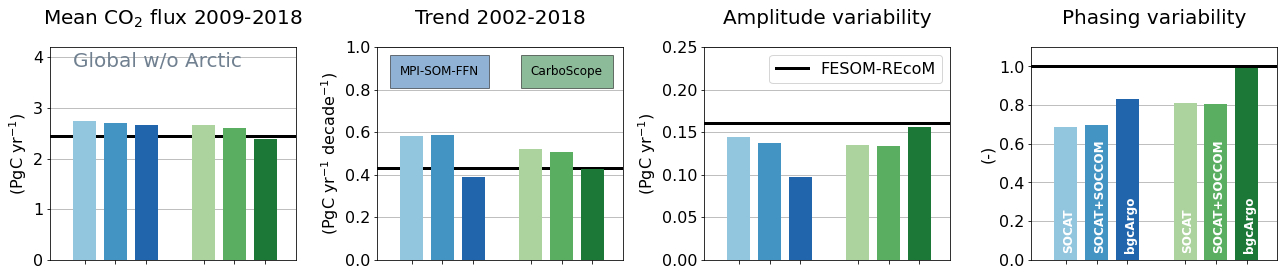

N_noArc


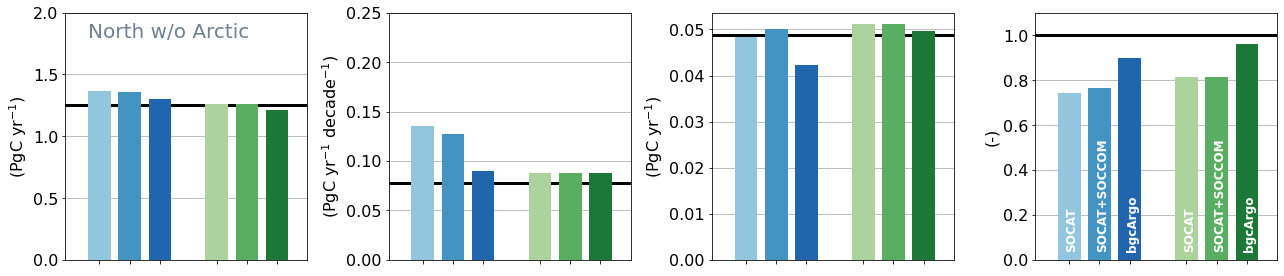

Arc
0.001556158759278171
0.027825685776503732


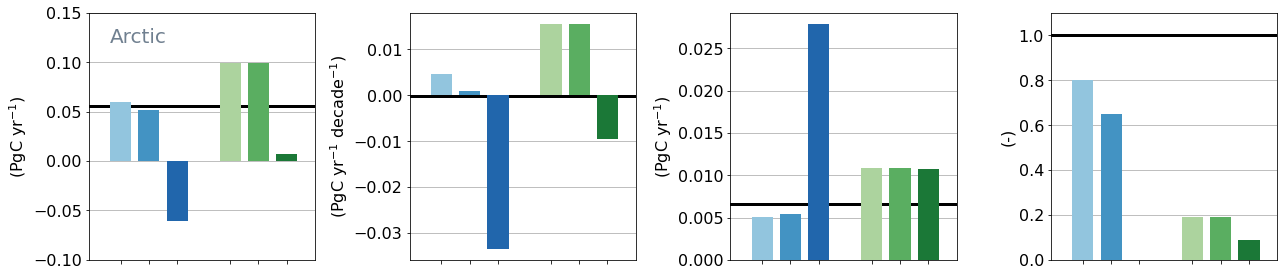

T
[-0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617]


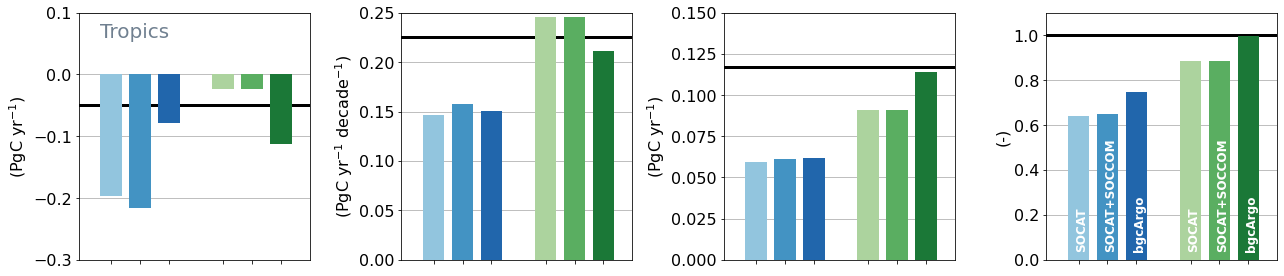

S
[1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533]


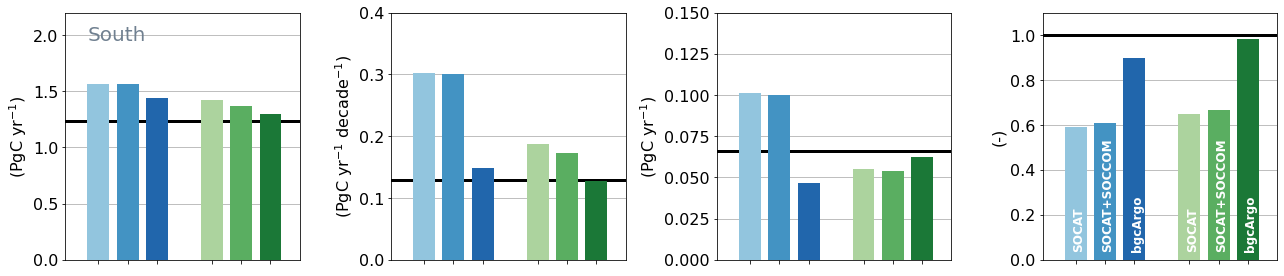

In [34]:
#del xbars, width, color
#---------------------------
# some illustrations of these statistics:
# for plots 1-3:
#xbars = np.array([1, 2.25, 2.65,3.05,3.8,4.2,4.6])
#width = np.array([0.3,0.3,0.3,0.3,0.3,0.3]) #0.8,
color=['#92C5DE','#4393C3','#2166AC','#ACD39E','#5AAE61','#1B7837'] #'black',
#color=['dodgerblue','blue','navy','mediumseagreen','seagreen','darkgreen'] #'black',

#for subplot 4:
xbars2 = np.array([2.25, 2.65,3.05,3.8,4.2,4.6])
width2 = np.array([0.3,0.3,0.3,0.3,0.3,0.3])
#color2=['dodgerblue','blue','navy','mediumseagreen','seagreen','darkgreen']
tick_labels = ['','A','B','C','A','B','C']


#-----------------

# loop over regions rather than repeating all

regions=('glo_noArc','N_noArc','Arc','T','S') #'N','Arc','N60',

# sim A
for reg in regions:
        print(reg)

# mean 2009 - 2018 ----------------------------------------------
#fesom'+reg+'mean,
        exec('data_mean = np.hstack([land_'+reg+'_A_mean,land_'+reg+'_B_mean,land_'+reg+'_C_mean,roeden_'+reg+'_A_mean,roeden_'+reg+'_B_mean,roeden_'+reg+'_C_mean])')
        #fesom'+reg+'trend2000,
        exec('data_trend = np.hstack([land_'+reg+'_A_trend2000,land_'+reg+'_B_trend2000,land_'+reg+'_C_trend2000,roeden_'+reg+'_A_trend2000,roeden_'+reg+'_B_trend2000,roeden_'+reg+'_C_trend2000])')
        #fesom'+reg+'std,
        exec('data_std = np.hstack([land_'+reg+'_A_std,land_'+reg+'_B_std,land_'+reg+'_C_std,roeden_'+reg+'_A_std,roeden_'+reg+'_B_std,roeden_'+reg+'_C_std])')

        exec('data_corr = np.hstack([land_'+reg+'_A_corr,land_'+reg+'_B_corr,land_'+reg+'_C_corr,roeden_'+reg+'_A_corr,roeden_'+reg+'_B_corr,roeden_'+reg+'_C_corr])')


        # ---------------------------
        # plot
        fig,ax = plt.subplots(1,4,figsize=(18,4))

        #----------------------------
        # mean 2009 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        exec('y[:]=fesom_'+reg+'_mean')

        ax1 = plt.subplot(1,4,1)
        plt.grid(b=None, which='major', axis='y',zorder=0)

        bar1=plt.bar(xbars2,data_mean,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3)
        #plt.xticks(rotation = 90)
        
        if (reg=='glo_noArc'):
            plt.ylim(0,4.2) 
            plt.title('Mean CO$_2$ flux 2009-2018',fontsize=20,y=1.08)

        elif (reg=='Arc'): 
            plt.ylim(-0.1,0.15) 
        elif (reg=='N_noArc'): 
            plt.ylim(0,2) 
        elif (reg=='T'): 
            plt.ylim(-0.3,0.1) 
        elif (reg=='S'): 
            plt.ylim(0,2.2) 

        plt.xlim(1.8,5)
        plt.ylabel('(PgC yr$^{-1}$)')

        # plt.text(0.6, 3.8, 'known truth', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        # #plt.legend(bar1,['REcoM','MPI-SOM-FFN SOCAT','MPI-SOM-FFN SOCAT+SOCCOM','MPI-SOM-FFN bgcArgo','Jena-MLS SOCAT','Jena-MLS SOCAT+SOCCOM','Jena-MLS bgcArgo'])
        # plt.text(2.1, 3.8, 'MPI-SOM-FFN', bbox={'facecolor': color[2], 'alpha': 0.5, 'pad': 10})
        # plt.text(3.8, 3.8, 'Jena-MLS', bbox={'facecolor': color[5], 'alpha': 0.5, 'pad': 10})
        if (reg=='glo_noArc'):
            plt.text(2.1,3.8,'Global w/o Arctic',fontsize=20,color='slategrey')
#             plt.text(2.2, 0.2, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(2.6, 0.2, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(3.0, 0.2, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#             plt.text(3.75, 0.2, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.15, 0.2, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.55, 0.2, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

        elif (reg=='Arc'): 
            plt.text(2.1,0.12,'Arctic',fontsize=20,color='slategrey')
        elif (reg=='N_noArc'): 
            plt.text(2.1,1.8,'North w/o Arctic',fontsize=20,color='slategrey')
#             plt.text(2.2, 0.1, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(2.6, 0.1, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(3.0, 0.1, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#             plt.text(3.75, 0.1, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.15, 0.1, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.55, 0.1, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

        elif (reg=='T'): 
            print(y)
            plt.text(2.1,0.06,'Tropics',fontsize=20,color='slategrey')
        elif (reg=='S'): 
            print(y)
            plt.text(2.1,1.95,'South',fontsize=20,color='slategrey')






        #----------------------------
        # trend 2000 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        exec('y[:]=10*fesom_'+reg+'_trend2000')  # trend per decade!

        ax1 = plt.subplot(1,4,2)
        plt.grid(b=None, which='major', axis='y',zorder=0)
### trend per decade!!
        bar2=plt.bar(xbars2,10*data_trend,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3)#,label='FESOM-REcoM')
       # plt.legend()
        #plt.xticks(rotation = 90)
        if (reg=='glo_noArc'):
            plt.ylim(0,1.0) 
        elif (reg=='Arc'): 
            print(max(data_trend))
        elif (reg=='N_noArc'): 
            plt.ylim(0,0.25) 
        elif (reg=='T'): 
            plt.ylim(0,0.25) 
        elif (reg=='S'): 
            plt.ylim(0,0.4) 
            
        plt.xlim(1.8,5)

        if (reg=='glo_noArc'):        
            plt.title('Trend 2002-2018',fontsize=20,y=1.08)
        plt.ylabel('(PgC yr$^{-1}$ decade$^{-1}$)')

        # plt.text(0.6, 0.085, 'known truth', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        # #plt.legend(bar1,['REcoM','MPI-SOM-FFN SOCAT','MPI-SOM-FFN SOCAT+SOCCOM','MPI-SOM-FFN bgcArgo','Jena-MLS SOCAT','Jena-MLS SOCAT+SOCCOM','Jena-MLS bgcArgo'])
        if (reg=='glo_noArc'): 
            plt.text(2.1, 0.87, 'MPI-SOM-FFN', bbox={'facecolor': color[2], 'alpha': 0.5, 'pad': 10})
            plt.text(3.8, 0.87, 'CarboScope', bbox={'facecolor': color[5], 'alpha': 0.5, 'pad': 10})
#         elif (reg=='N_noArc'): 
#             plt.text(2.1, 0.23, 'MPI-SOM-FFN', bbox={'facecolor': color[2], 'alpha': 0.5, 'pad': 10})
#             plt.text(3.8, 0.23, 'Jena-MLS', bbox={'facecolor': color[5], 'alpha': 0.5, 'pad': 10})


#         plt.text(2.2, 0.005, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#         plt.text(2.6, 0.005, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#         plt.text(3.0, 0.005, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#         plt.text(3.75, 0.005, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#         plt.text(4.15, 0.005, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#         plt.text(4.55, 0.005, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')



        #----------------------------
        # std 1982 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        exec('y[:]=fesom_'+reg+'_std')

        ax1 = plt.subplot(1,4,3)
        plt.grid(b=None, which='major', axis='y',zorder=0)

        bar3=plt.bar(xbars2,data_std,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3,label='FESOM-REcoM')
        

        #plt.xticks(rotation = 90)
        if (reg=='glo_noArc'):
            plt.ylim(0,0.25) 
            plt.legend(fontsize=16)

        elif (reg=='Arc'): 
            print(max(data_std))
#         elif (reg=='N_noArc'): 
#             print(max(data_std))
#             plt.ylim(0,0.15) 
#             plt.legend(fontsize=16)


        elif (reg=='T'): 
            plt.ylim(0,0.15) 

        elif (reg=='S'): 
            plt.ylim(0,0.15) 

        plt.xlim(1.8,5)

        if (reg=='glo_noArc'):
            plt.title('Amplitude variability',fontsize=20,y=1.08)  # 1982-2018
        plt.ylabel('(PgC yr$^{-1}$)')

        # plt.text(0.6, 0.22, 'known truth', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        # #plt.legend(bar1,['REcoM','MPI-SOM-FFN SOCAT','MPI-SOM-FFN SOCAT+SOCCOM','MPI-SOM-FFN bgcArgo','Jena-MLS SOCAT','Jena-MLS SOCAT+SOCCOM','Jena-MLS bgcArgo'])
        # plt.text(2.1, 0.22, 'MPI-SOM-FFN', bbox={'facecolor': 'dodgerblue', 'alpha': 0.5, 'pad': 10})
        # plt.text(3.8, 0.22, 'Jena-MLS', bbox={'facecolor': 'mediumseagreen', 'alpha': 0.5, 'pad': 10})
#         if (reg=='glo_noArc'):
#             plt.text(2.2, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(2.6, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(3.0, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#             plt.text(3.75, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.15, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.55, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#         elif (reg=='N_noArc'): 
#             print(max(data_std))

#             plt.text(2.2, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(2.6, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(3.0, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#             plt.text(3.75, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.15, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.55, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')


        #----------------------------
        # corr 1982 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        y[:]=1

        ax1 = plt.subplot(1,4,4)
        plt.grid(b=None, which='major', axis='y',zorder=0)

        bar4=plt.bar(xbars2,data_corr,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3)

        #plt.xticks(rotation = 90)
 
        plt.ylim(0,1.1) 
          
        plt.xlim(1.8,5)

        if (reg=='glo_noArc'):
            plt.title('Phasing variability',fontsize=20,y=1.08) # 1982-2018
        plt.ylabel('(-)')

        # #plt.text(0.6, 0.82, 'known truth', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        # #plt.legend(bar1,['REcoM','MPI-SOM-FFN SOCAT','MPI-SOM-FFN SOCAT+SOCCOM','MPI-SOM-FFN bgcArgo','Jena-MLS SOCAT','Jena-MLS SOCAT+SOCCOM','Jena-MLS bgcArgo'])
        # plt.text(2.2, 0.87, 'MPI-SOM-FFN', bbox={'facecolor': 'dodgerblue', 'alpha': 0.5, 'pad': 10})
        # plt.text(3.9, 0.87, 'Jena-MLS', bbox={'facecolor': 'mediumseagreen', 'alpha': 0.5, 'pad': 10})

        if (reg != 'Arc'):
            plt.text(2.2, 0.05, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(2.6, 0.05, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(3.0, 0.05, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

            plt.text(3.75, 0.05, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(4.15, 0.05, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(4.55, 0.05, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

        fig.tight_layout()

        plt.savefig('subsampling_barstats_'+reg+'_OCIMprior_fesomkw.png',dpi=300,facecolor='w',transparent=False)
        plt.savefig('subsampling_barstats_'+reg+'_OCIMprior_fesomkw.eps',facecolor='w',transparent=False)
        plt.savefig('subsampling_barstats_'+reg+'_OCIMprior_fesomkw.pdf',facecolor='w',transparent=False)
        plt.show()



glo_noArc


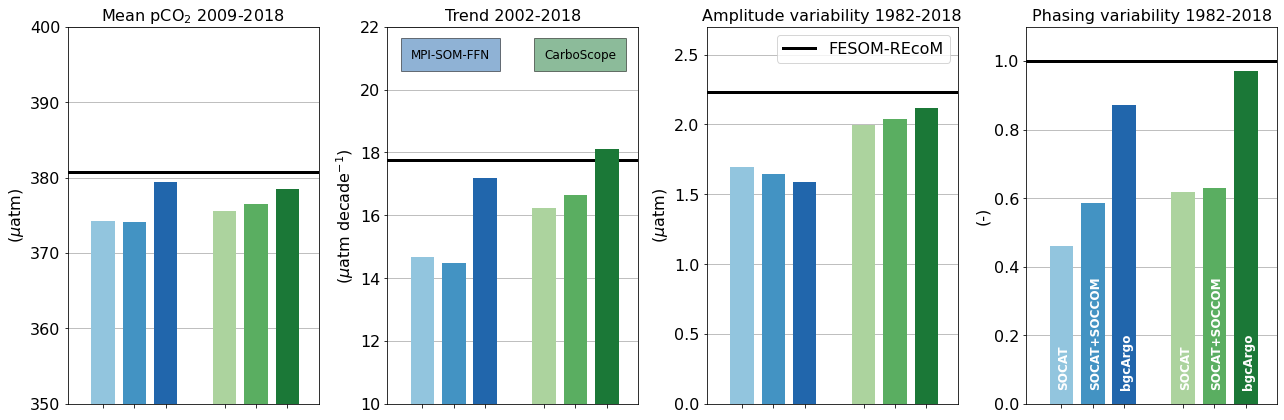

N_noArc


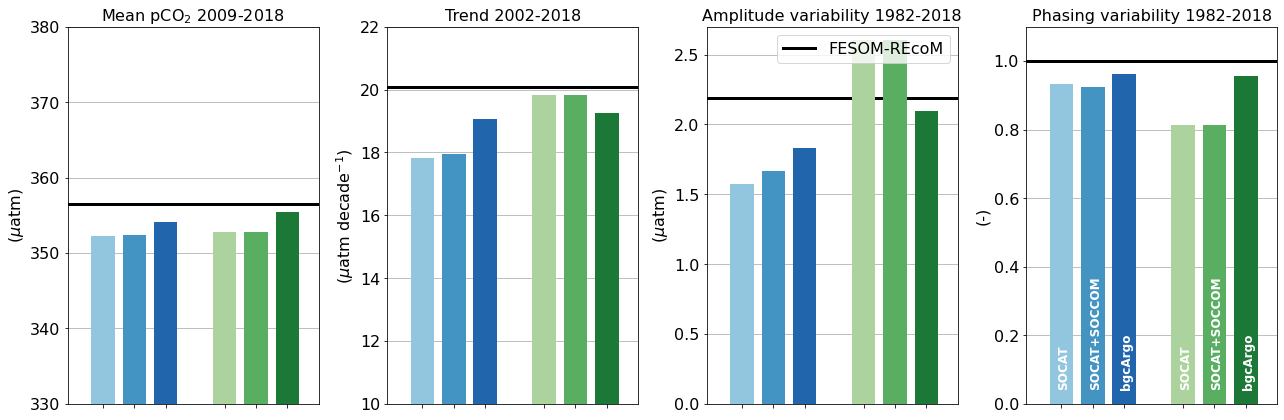

Arc
0.030229162829888356
41.465249858474266


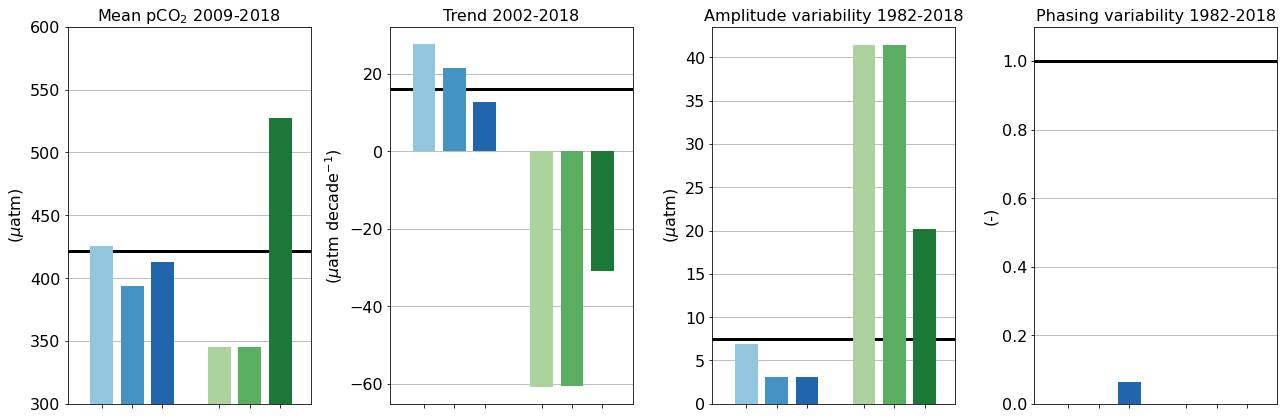

T


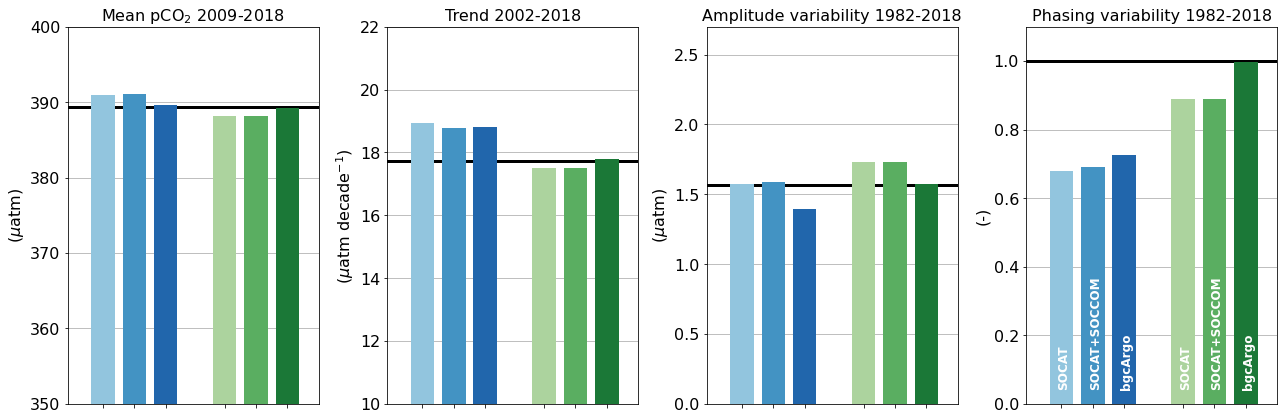

S


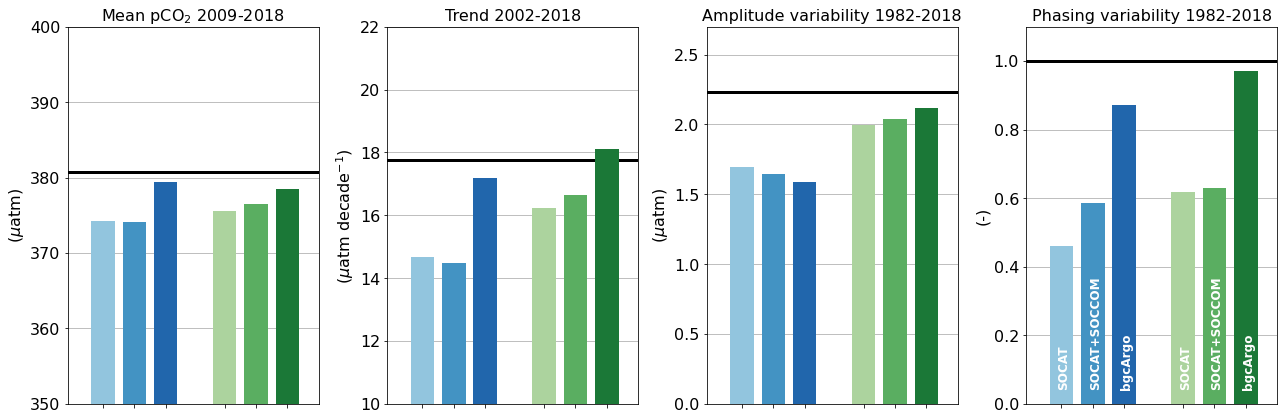

In [36]:
# same for spco2

#del xbars, width, color
#---------------------------
# some illustrations of these statistics:
# for plots 1-3:
#xbars = np.array([1, 2.25, 2.65,3.05,3.8,4.2,4.6])
#width = np.array([0.3,0.3,0.3,0.3,0.3,0.3]) #0.8,
color=['#92C5DE','#4393C3','#2166AC','#ACD39E','#5AAE61','#1B7837'] #'black',
#color=['dodgerblue','blue','navy','mediumseagreen','seagreen','darkgreen'] #'black',

#for subplot 4:
xbars2 = np.array([2.25, 2.65,3.05,3.8,4.2,4.6])
width2 = np.array([0.3,0.3,0.3,0.3,0.3,0.3])
#color2=['dodgerblue','blue','navy','mediumseagreen','seagreen','darkgreen']
tick_labels = ['','A','B','C','A','B','C']


#-----------------

# loop over regions rather than repeating all

regions=('glo_noArc','N_noArc','Arc','T','S') #'N','Arc','N60',

# sim A
for reg in regions:
        print(reg)

# mean 2009 - 2018 ----------------------------------------------
#fesom'+reg+'mean,
        exec('data_mean_spco2 = np.hstack([land_'+reg+'_A_mean_spco2,land_'+reg+'_B_mean_spco2,land_'+reg+'_C_mean_spco2,roeden_'+reg+'_A_mean_spco2,roeden_'+reg+'_B_mean_spco2,roeden_'+reg+'_C_mean_spco2])')
        #fesom'+reg+'trend2000,
        exec('data_trend_spco2 = np.hstack([land_'+reg+'_A_trend2000_spco2,land_'+reg+'_B_trend2000_spco2,land_'+reg+'_C_trend2000_spco2,roeden_'+reg+'_A_trend2000_spco2,roeden_'+reg+'_B_trend2000_spco2,roeden_'+reg+'_C_trend2000_spco2])')
        #fesom'+reg+'std,
        exec('data_std_spco2 = np.hstack([land_'+reg+'_A_std_spco2,land_'+reg+'_B_std_spco2,land_'+reg+'_C_std_spco2,roeden_'+reg+'_A_std_spco2,roeden_'+reg+'_B_std_spco2,roeden_'+reg+'_C_std_spco2])')

        exec('data_corr_spco2 = np.hstack([land_'+reg+'_A_corr_spco2,land_'+reg+'_B_corr_spco2,land_'+reg+'_C_corr_spco2,roeden_'+reg+'_A_corr_spco2,roeden_'+reg+'_B_corr_spco2,roeden_'+reg+'_C_corr_spco2])')


        # ---------------------------
        # plot
        fig,ax = plt.subplots(1,4,figsize=(18,6))

        #----------------------------
        # mean 2009 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        exec('y[:]=fesom_'+reg+'_mean_spco2')

        ax1 = plt.subplot(1,4,1)
        plt.grid(b=None, which='major', axis='y',zorder=0)

        bar1=plt.bar(xbars2,data_mean_spco2,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3)
        #plt.xticks(rotation = 90)
        
        if (reg=='glo_noArc'):
            plt.ylim(350,400) 
        elif (reg=='Arc'): 
            plt.ylim(300,600) 
        elif (reg=='N_noArc'): 
            plt.ylim(330,380) 
        elif (reg=='T'): 
            plt.ylim(350,400) 
        elif (reg=='S'): 
            plt.ylim(350,400) 
#        print(np.max(data_mean_spco2))

        plt.xlim(1.8,5)
        plt.title('Mean pCO$_2$ 2009-2018',fontsize=16)
        plt.ylabel('($\mu$atm)')

#         if (reg=='glo_noArc'):
#             plt.text(2.1,3.8,'Global w/o Arctic',fontsize=20,color='slategrey')


#         elif (reg=='Arc'): 
#             plt.text(2.1,0.12,'Arctic',fontsize=20,color='slategrey')
#         elif (reg=='N_noArc'): 
#             plt.text(2.1,1.8,'North w/o Arctic',fontsize=20,color='slategrey')

#         elif (reg=='T'): 
#             print(y)
#             plt.text(2.1,0.06,'Tropics',fontsize=20,color='slategrey')
#         elif (reg=='S'): 
#             print(y)
#             plt.text(2.1,1.84,'South',fontsize=20,color='slategrey')






        #----------------------------
        # trend 2000 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        exec('y[:]=10*fesom_'+reg+'_trend2000_spco2')  # trend per decade!

        ax1 = plt.subplot(1,4,2)
        plt.grid(b=None, which='major', axis='y',zorder=0)
### trend per decade!!
        bar2=plt.bar(xbars2,10*data_trend_spco2,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3)#,label='FESOM-REcoM')

        if (reg=='glo_noArc'):
            plt.ylim(10,22) 
        elif (reg=='Arc'): 
            print(max(data_trend))
        elif (reg=='N_noArc'): 
            plt.ylim(10,22) 
        elif (reg=='T'): 
            plt.ylim(10,22) 
        elif (reg=='S'): 
            plt.ylim(10,22) 
#        print(np.max(10*data_trend_spco2))

            
        plt.xlim(1.8,5)

        plt.title('Trend 2002-2018',fontsize=16)
        plt.ylabel('($\mu$atm decade$^{-1}$)')

        if (reg=='glo_noArc'): 
            plt.text(2.1, 21, 'MPI-SOM-FFN', bbox={'facecolor': color[2], 'alpha': 0.5, 'pad': 10})
            plt.text(3.8, 21, 'CarboScope', bbox={'facecolor': color[5], 'alpha': 0.5, 'pad': 10})
#         elif (reg=='N_noArc'): 
#             plt.text(2.1, 21, 'MPI-SOM-FFN', bbox={'facecolor': color[2], 'alpha': 0.5, 'pad': 10})
#             plt.text(3.8, 21, 'Jena-MLS', bbox={'facecolor': color[5], 'alpha': 0.5, 'pad': 10})






        #----------------------------
        # std 1982 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        exec('y[:]=fesom_'+reg+'_std_spco2')

        ax1 = plt.subplot(1,4,3)
        plt.grid(b=None, which='major', axis='y',zorder=0)

        bar3=plt.bar(xbars2,data_std_spco2,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3,label='FESOM-REcoM')
        

        #plt.xticks(rotation = 90)
        if (reg=='glo_noArc'):
            plt.ylim(0,2.7) 
            plt.legend(fontsize=16)
        elif (reg=='Arc'): 
            print(max(data_std_spco2))
        elif (reg=='N_noArc'): 
            plt.ylim(0,2.7) 
            plt.legend(fontsize=16)
        elif (reg=='T'): 
            plt.ylim(0,2.7) 
        elif (reg=='S'): 
            plt.ylim(0,2.7) 

        plt.xlim(1.8,5)

        plt.title('Amplitude variability 1982-2018',fontsize=16)
        plt.ylabel('($\mu$atm)')

        # plt.text(0.6, 0.22, 'known truth', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        # #plt.legend(bar1,['REcoM','MPI-SOM-FFN SOCAT','MPI-SOM-FFN SOCAT+SOCCOM','MPI-SOM-FFN bgcArgo','Jena-MLS SOCAT','Jena-MLS SOCAT+SOCCOM','Jena-MLS bgcArgo'])
        # plt.text(2.1, 0.22, 'MPI-SOM-FFN', bbox={'facecolor': 'dodgerblue', 'alpha': 0.5, 'pad': 10})
        # plt.text(3.8, 0.22, 'Jena-MLS', bbox={'facecolor': 'mediumseagreen', 'alpha': 0.5, 'pad': 10})
#         if (reg=='glo_noArc'):
#             plt.text(2.2, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(2.6, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(3.0, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#             plt.text(3.75, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.15, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.55, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#         elif (reg=='N_noArc'): 
#             print(max(data_std_spco2))

#             plt.text(2.2, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(2.6, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(3.0, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#             plt.text(3.75, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.15, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.55, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')


        #----------------------------
        # corr 1982 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        y[:]=1

        ax1 = plt.subplot(1,4,4)
        plt.grid(b=None, which='major', axis='y',zorder=0)

        bar4=plt.bar(xbars2,data_corr_spco2,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3)

        #plt.xticks(rotation = 90)
 
        plt.ylim(0,1.1) 
          
        plt.xlim(1.8,5)

        plt.title('Phasing variability 1982-2018',fontsize=16)
        plt.ylabel('(-)')

        # #plt.text(0.6, 0.82, 'known truth', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        # #plt.legend(bar1,['REcoM','MPI-SOM-FFN SOCAT','MPI-SOM-FFN SOCAT+SOCCOM','MPI-SOM-FFN bgcArgo','Jena-MLS SOCAT','Jena-MLS SOCAT+SOCCOM','Jena-MLS bgcArgo'])
        # plt.text(2.2, 0.87, 'MPI-SOM-FFN', bbox={'facecolor': 'dodgerblue', 'alpha': 0.5, 'pad': 10})
        # plt.text(3.9, 0.87, 'Jena-MLS', bbox={'facecolor': 'mediumseagreen', 'alpha': 0.5, 'pad': 10})

        if (reg != 'Arc'):
            plt.text(2.2, 0.05, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(2.6, 0.05, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(3.0, 0.05, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

            plt.text(3.75, 0.05, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(4.15, 0.05, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(4.55, 0.05, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

        fig.tight_layout()

        plt.savefig('subsampling_barstats_'+reg+'_OCIMprior_spco2.png',dpi=300,facecolor='w',transparent=False)
        plt.show()


(180, 360)


<ipython-input-37-079ff5886579>:47: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar2 = fig.colorbar(image,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists wi

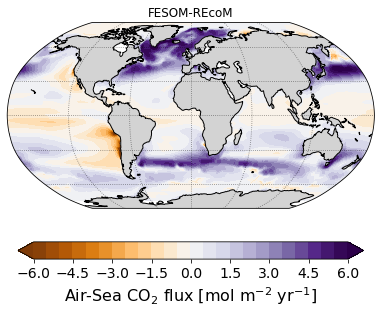

In [37]:
# continue with some difference maps of CO2 flux and also pCO2...

cmap = cm.coolwarm_r
cmap2 = cm.PuOr



#### fgco2

fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.Robinson()),  #ccrs.PlateCarree()
            constrained_layout=False,
            figsize=(6,4),sharex=True,sharey=True,
        )

#ax = ax.flatten()


# first one: fesom only



x = fesom_fgco2_2009_2018
x_m = np.ma.array(x, mask=np.isnan(x))
print(np.shape(x_m))
levels = np.arange(-6,6.5,0.5)
image = ax.contourf(xax,yax,x_m, levels, cmap=cmap2, extend='both',transform=ccrs.PlateCarree())#vmin=np.nanmin(x), vmax=np.nanmax(x)) 
ax.set_title('FESOM-REcoM')
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
#ax.set_xticks([-180, -90, 0, 90, 180], crs=ccrs.Robinson())  #crs=ccrs.PlateCarree()
#ax.set_yticks([-60, 30,0, 30,60], crs=ccrs.Robinson())#crs=ccrs.PlateCarree()
#ax.set_yticks([-60, 30,0, 30,60], crs=ccrs.Robinson())#crs=ccrs.PlateCarree()
#lon_formatter = LongitudeFormatter() #zero_direction_label=True
#lat_formatter = LatitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)
#ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines()
ax.gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 

#------------
# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

cbar2_ax = fig.add_axes([0.125, 0.001, 0.8, 0.06])
cbar2 = fig.colorbar(image,
                    cax = cbar2_ax, 
                    orientation = 'horizontal',
                    pad=0.01,  extend='both') #shrink=0.9,
cbar2.set_label('Air-Sea CO$_2$ flux [mol m$^{-2}$ yr$^{-1}$]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)


plt.savefig('FESOM_CO2flux_map_2009_2018.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('FESOM_CO2flux_map_2009_2018.eps',transparent=False, bbox_inches='tight')
plt.savefig('FESOM_CO2flux_map_2009_2018.pdf',transparent=False, bbox_inches='tight')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

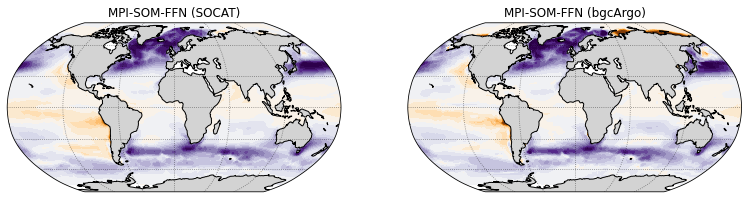

In [38]:
# then the three versions of Landschützer - skip SOCCOM

fig, ax = plt.subplots(
            1,
            2, #3
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(12,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. landschuetzer, A:
x3 = land_fgco2_A_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
levels = np.arange(-6,6.5,0.5)
image3 = ax[0].contourf(xax,yax,x_m3, levels, cmap=cmap2, extend='both',transform=ccrs.PlateCarree())
#image3 = ax[0].pcolor(xax,yax,x_m3, vmin=-5, vmax=5, cmap=cmap)
ax[0].set_title('MPI-SOM-FFN (SOCAT)')
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 

# #----------------------------------------------------------------------
# # 4. landschuetzer, B:
# x4 = land_fgco2_B_2009_2018
# x_m4 = np.ma.array(x4, mask=np.isnan(x4))
# image4 = ax[1].pcolor(xax,yax,x_m4, vmin=-5, vmax=5, cmap=cmap)
# ax[1].set_title('MPI-SOM-FFN, SOCAT+ SOCCOM')
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

# ax[1].coastlines()
#----------------------------------------------------------------------
# 5. landschuetzer, C:
x5 = land_fgco2_C_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image3 = ax[1].contourf(xax,yax,x_m5, levels, cmap=cmap2, extend='both',transform=ccrs.PlateCarree())
ax[1].set_title('MPI-SOM-FFN (bgcArgo)')
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 

# ax[1] for second subplot


# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

# cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
# cbar2 = fig.colorbar(image3,
#                     cax = cbar2_ax, 
#                     orientation = 'horizontal',
#                     pad=0.1, shrink=0.9, extend='both') #
# cbar2.set_label('Air-Sea CO$_2$ exchange [mol m$^{-2}$ yr$^{-1}$]', fontsize=16)
# cbar2.ax.tick_params(labelsize=14)


plt.savefig('L_CO2flux_map_AC_2009_2018_fesomkw.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('L_CO2flux_map_AC_2009_2018_fesomkw.eps',transparent=False, bbox_inches='tight')
plt.savefig('L_CO2flux_map_AC_2009_2018_fesomkw.pdf',transparent=False, bbox_inches='tight')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

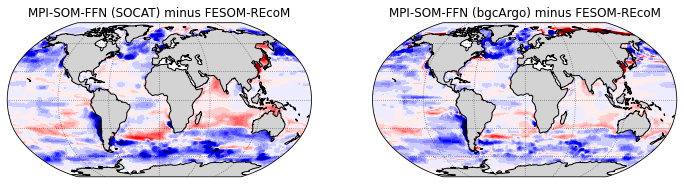

In [48]:
# three times Landschuetzer minus fesom

cmap = cm.seismic_r


fig, ax = plt.subplots(
            1,
            2,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(12,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. landschuetzer, A:
x3 = land_fgco2_A_2009_2018 - fesom_fgco2_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
levels=np.arange(-3,3.2,0.2)
image3 = ax[0].contourf(xax,yax,x_m3, levels, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax[0].set_title('MPI-SOM-FFN (SOCAT) minus FESOM-REcoM')
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 

# #----------------------------------------------------------------------
# # 4. landschuetzer, B:
# x4 = land_fgco2_B_2009_2018 - fesom_fgco2_2009_2018
# x_m4 = np.ma.array(x4, mask=np.isnan(x4))
# image4 = ax[1].pcolor(xax,yax,x_m4, vmin=-3, vmax=3, cmap=cmap)
# ax[1].set_title('MPI-SOM-FFN minus FESOM-REcoM, SOCAT+SOCCOM')
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

# ax[1].coastlines()
#----------------------------------------------------------------------
# 5. landschuetzer, C:
x5 = land_fgco2_C_2009_2018 -fesom_fgco2_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[1].contourf(xax,yax,x_m5, levels, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax[1].set_title('MPI-SOM-FFN (bgcArgo) minus FESOM-REcoM')
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 




# # plt.colorbar()    
# plt.subplots_adjust(top=0.9, bottom=0.2, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

# cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
# cbar2 = fig.colorbar(image3,
#                     cax = cbar2_ax, 
#                     orientation = 'horizontal',
#                     pad=0.01, shrink=0.9, extend='both') 
# cbar2.set_label('Air-Sea CO$_2$ exchange [mol m$^{-2}$ yr$^{-1}$]', fontsize=16)
# cbar2.ax.tick_params(labelsize=14)


plt.savefig('LminusF_CO2flux_map_AC_2009_2018_fesomkw.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('LminusF_CO2flux_map_AC_2009_2018_fesomkw.eps',transparent=False, bbox_inches='tight')
plt.savefig('LminusF_CO2flux_map_AC_2009_2018_fesomkw.pdf',transparent=False, bbox_inches='tight')

plt.show()




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

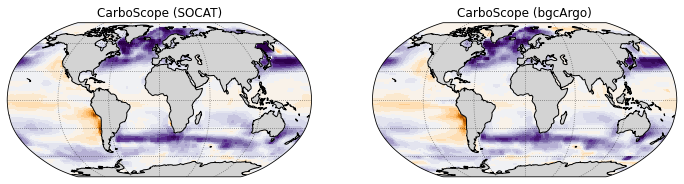

In [41]:
# three times Rödenbeck



fig, ax = plt.subplots(
            1,
            2,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(12,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. roedenbeck, A:
x3 = roeden_fgco2_A_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
levels = np.arange(-6,6.5,0.5)
image3 = ax[0].contourf(xax,yax,x_m3, levels, cmap=cmap2,extend='both',transform=ccrs.PlateCarree())
ax[0].set_title('CarboScope (SOCAT)')
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 

#----------------------------------------------------------------------
# 4. roedenbeck, B:
# x4 = roeden_fgco2_B_2009_2018
# x_m4 = np.ma.array(x4, mask=np.isnan(x4))
# image4 = ax[1].pcolor(xax,yax,x_m4, vmin=-5, vmax=5, cmap=cmap)
# ax[1].set_title('Jena-MLS, SOCAT+ SOCCOM')
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

# ax[1].coastlines()
#----------------------------------------------------------------------
# 5. roedenbeck, C:
x5 = roeden_fgco2_C_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[1].contourf(xax,yax,x_m5, levels, cmap=cmap2,extend='both',transform=ccrs.PlateCarree())
ax[1].set_title('CarboScope (bgcArgo)')
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 




# plt.colorbar()    
# plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

# cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
# cbar2 = fig.colorbar(image3,
#                     cax = cbar2_ax, 
#                     orientation = 'horizontal',
#                     pad=0.01, shrink=0.9, extend='both') 
# cbar2.set_label('Air-Sea CO$_2$ exchange [mol m$^{-2}$ yr$^{-1}$]', fontsize=16)
# cbar2.ax.tick_params(labelsize=14)


plt.savefig('R_CO2flux_map_AC_2009_2018_OCIMprior_fesomkw.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('R_CO2flux_map_AC_2009_2018_OCIMprior_fesomkw.eps',transparent=False, bbox_inches='tight')
plt.savefig('R_CO2flux_map_AC_2009_2018_OCIMprior_fesomkw.pdf',transparent=False, bbox_inches='tight')

plt.show()


<ipython-input-42-b5fdd9cdc5a4>:61: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar2 = fig.colorbar(image3,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists w

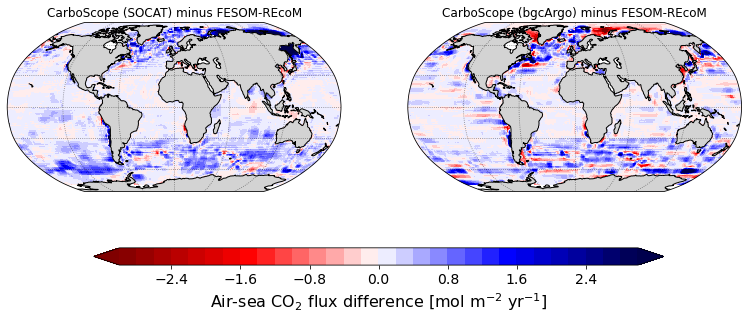

In [42]:
# three times Roedenbeck minus fesom

cmap = cm.seismic_r


fig, ax = plt.subplots(
            1,
            2,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(12,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. roedenbeck, A:
x3 = roeden_fgco2_A_2009_2018 - fesom_fgco2_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
levels=np.arange(-3,3.2,0.2)
image3 = ax[0].contourf(xax,yax,x_m3,levels, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax[0].set_title('CarboScope (SOCAT) minus FESOM-REcoM')
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 

#----------------------------------------------------------------------
# 4. roedenbeck, B:
# x4 = roeden_fgco2_B_2009_2018 - fesom_fgco2_2009_2018
# x_m4 = np.ma.array(x4, mask=np.isnan(x4))
# image4 = ax[1].pcolor(xax,yax,x_m4, vmin=-3, vmax=3, cmap=cmap)
# ax[1].set_title('Jena-MLS minus FESOM-REcoM, SOCAT+SOCCOM')
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

# ax[1].coastlines()
#----------------------------------------------------------------------
# 5. roedenbeck, C:
x5 = roeden_fgco2_C_2009_2018 -fesom_fgco2_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[1].contourf(xax,yax,x_m5, levels, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax[1].set_title('CarboScope (bgcArgo) minus FESOM-REcoM')
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 




# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.2, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
cbar2 = fig.colorbar(image3,
                    cax = cbar2_ax, 
                    orientation = 'horizontal',
                    pad=0.01, shrink=0.9, extend='both') 
cbar2.set_label('Air-sea CO$_2$ flux difference [mol m$^{-2}$ yr$^{-1}$]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)


plt.savefig('RminusF_CO2flux_map_AC_2009_2018_OCIMprior_fesomkw.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('RminusF_CO2flux_map_AC_2009_2018_OCIMprior_fesomkw.pdf',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('RminusF_CO2flux_map_AC_2009_2018_OCIMprior_fesomkw.eps', dpi=300, bbox_inches='tight')

plt.show()

(180, 360)


/home/ollie/jhauck/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be 

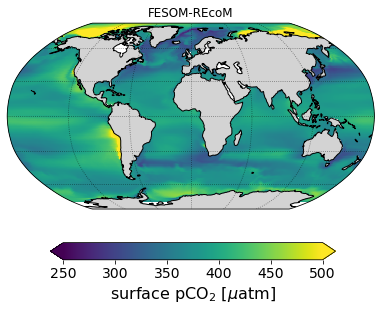

In [43]:
# pCO2 maps


cmap = cm.viridis




fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(6,4),sharex=True,sharey=True,
        )

#ax = ax.flatten()


# first one: fesom only



x = fesom_spco2_2009_2018
x_m = np.ma.array(x, mask=np.isnan(x))
print(np.shape(x_m))
image = ax.pcolor(xax,yax,x_m, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())#vmin=np.nanmin(x), vmax=np.nanmax(x)) 
ax.set_title('FESOM-REcoM')
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax.set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax.set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines()
ax.gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 


#------------
# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
cbar2 = fig.colorbar(image,
                    cax = cbar2_ax, 
                    orientation = 'horizontal',
                    pad=0.01, shrink=0.9, extend='both') 
cbar2.set_label('surface pCO$_2$ [$\mu$atm]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)


plt.savefig('FESOM_spCO2_map_2009_2018.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('FESOM_spCO2_map_2009_2018.eps',bbox_inches='tight')
plt.savefig('FESOM_spCO2_map_2009_2018.pdf',transparent=False, bbox_inches='tight')

plt.show()






/home/ollie/jhauck/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


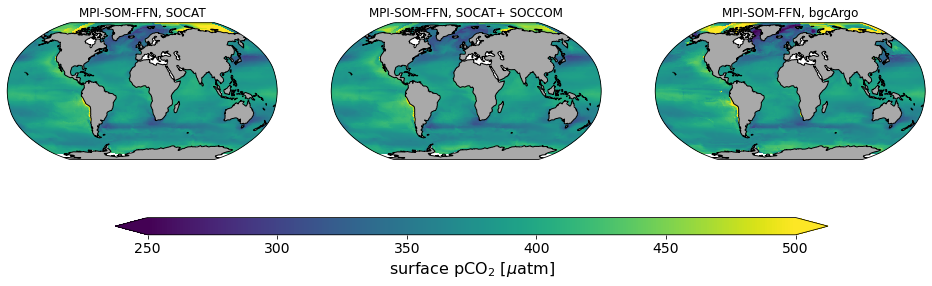

In [44]:
# then the three versions of Landschützer

fig, ax = plt.subplots(
            1,
            3,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(15,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. landschuetzer, A:
x3 = land_spco2_A_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
image3 = ax[0].pcolor(xax,yax,x_m3, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())
ax[0].set_title('MPI-SOM-FFN, SOCAT')
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()

#----------------------------------------------------------------------
# 4. landschuetzer, B:
x4 = land_spco2_B_2009_2018
x_m4 = np.ma.array(x4, mask=np.isnan(x4))
image4 = ax[1].pcolor(xax,yax,x_m4, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())
ax[1].set_title('MPI-SOM-FFN, SOCAT+ SOCCOM')
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

ax[1].coastlines()
#----------------------------------------------------------------------
# 5. landschuetzer, C:
x5 = land_spco2_C_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[2].pcolor(xax,yax,x_m5, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())
ax[2].set_title('MPI-SOM-FFN, bgcArgo')
ax[2].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[2].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[2].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[2].coastlines()




# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
cbar2 = fig.colorbar(image3,
                    cax = cbar2_ax, 
                    orientation = 'horizontal',
                    pad=0.01, shrink=0.9, extend='both') 
cbar2.set_label('surface pCO$_2$ [$\mu$atm]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)


plt.savefig('L_spco2_map_ABC_2009_2018.png',transparent=False, dpi=300, bbox_inches='tight')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

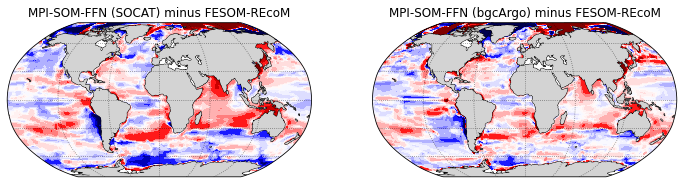

In [45]:
# three times Landschuetzer minus fesom

cmap = cm.seismic


fig, ax = plt.subplots(
            1,
            2,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(12,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. landschuetzer, A:
x3 = land_spco2_A_2009_2018 - fesom_spco2_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
levels=[-50,-40,-30,-15,-10,-5,-2,-1,0,1,2,5,10,15,30,40,50]
image3 = ax[0].contourf(xax,yax,x_m3, levels, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax[0].set_title('MPI-SOM-FFN (SOCAT) minus FESOM-REcoM')
# ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# #----------------------------------------------------------------------
# # 4. landschuetzer, B:
# x4 = land_spco2_B_2009_2018 - fesom_spco2_2009_2018
# x_m4 = np.ma.array(x4, mask=np.isnan(x4))
# image4 = ax[1].contourf(xax,yax,x_m4, levels, cmap=cmap,extend='both')
# ax[1].set_title('MPI-SOM-FFN minus FESOM-REcoM, SOCAT+SOCCOM')
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

# ax[1].coastlines()
#----------------------------------------------------------------------
# 5. landschuetzer, C:
x5 = land_spco2_C_2009_2018 -fesom_spco2_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[1].contourf(xax,yax,x_m5, levels, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax[1].set_title('MPI-SOM-FFN (bgcArgo) minus FESOM-REcoM')
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')



# # plt.colorbar()    
# plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

# cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
# cbar2 = fig.colorbar(image3,
#                     cax = cbar2_ax, 
#                     orientation = 'horizontal',
#                     pad=0.01, shrink=0.9, extend='both', ticks=[-50,-30,-10,-5,-2,-1,0,1,2,5,10,30,50]) 
# cbar2.set_label('surface pCO$_2$ [$\mu$atm]', fontsize=16)
# cbar2.ax.tick_params(labelsize=14)
# #cbar2.ax.ticks([-50,-30,-10,-5,-2,-1,0,1,2,5,10,30,50])


plt.savefig('LminusF_spco2_map_AC_2009_2018.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('LminusF_spco2_map_AC_2009_2018.eps',dpi=300, bbox_inches='tight')
plt.savefig('LminusF_spco2_map_AC_2009_2018.pdf',transparent=False, dpi=300, bbox_inches='tight')

plt.show()




/home/ollie/jhauck/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


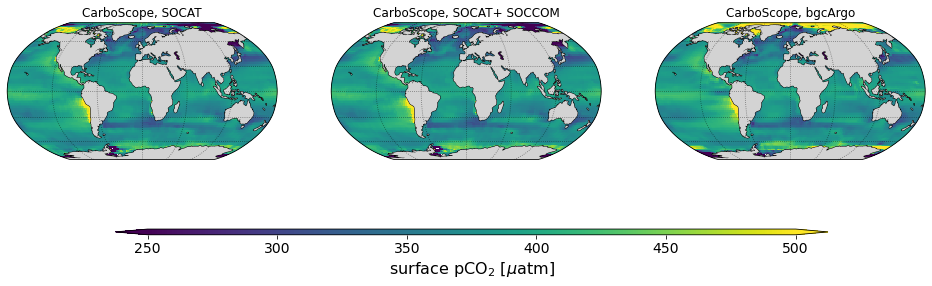

In [46]:
# three times Rödenbeck

cmap = cm.viridis


fig, ax = plt.subplots(
            1,
            3,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(15,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. roedenbeck, A:
x3 = roeden_spco2_A_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
image3 = ax[0].pcolor(xax,yax,x_m3, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())
ax[0].set_title('CarboScope, SOCAT')
# ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
#----------------------------------------------------------------------
# 4. roedenbeck, B:
x4 = roeden_spco2_B_2009_2018
x_m4 = np.ma.array(x4, mask=np.isnan(x4))
image4 = ax[1].pcolor(xax,yax,x_m4, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())
ax[1].set_title('CarboScope, SOCAT+ SOCCOM')
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
#----------------------------------------------------------------------
# 5. roedenbeck, C:
x5 = roeden_spco2_C_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[2].pcolor(xax,yax,x_m5, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())
ax[2].set_title('CarboScope, bgcArgo')
ax[2].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[2].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[2].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[2].coastlines()
ax[2].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[2].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')


# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.02])
cbar2 = fig.colorbar(image3,
                    cax = cbar2_ax, 
                    orientation = 'horizontal',
                    pad=0.01, shrink=0.9, extend='both') 
cbar2.set_label('surface pCO$_2$ [$\mu$atm]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)


plt.savefig('R_spco2_map_ABC_2009_2018_OCIMprior_fesomkw.png',transparent=False, dpi=300, bbox_inches='tight')
plt.show()


<ipython-input-47-36ac5db0fc1d>:64: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar2 = fig.colorbar(image3,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists w

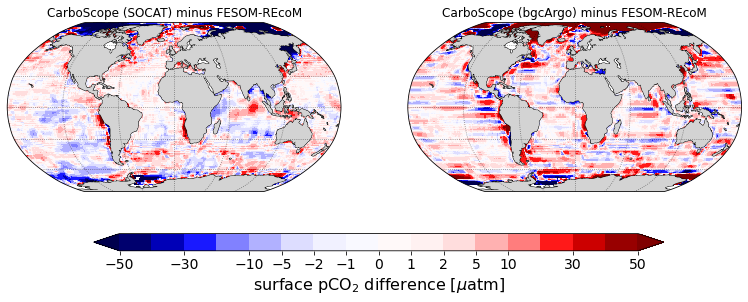

In [47]:
# three times Roedenbeck minus fesom

cmap = cm.seismic


fig, ax = plt.subplots(
            1,
            2,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(12,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. roedenbeck, A:
x3 = roeden_spco2_A_2009_2018 - fesom_spco2_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
levels=[-50,-40,-30,-15,-10,-5,-2,-1,0,1,2,5,10,15,30,40,50]
#norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

image3 = ax[0].contourf(xax,yax,x_m3, levels,extend='both', cmap=cmap,transform=ccrs.PlateCarree())#,norm=norm)
ax[0].set_title('CarboScope (SOCAT) minus FESOM-REcoM')
# ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# #----------------------------------------------------------------------
# # 4. roedenbeck, B:
# x4 = roeden_spco2_B_2009_2018 - fesom_spco2_2009_2018
# x_m4 = np.ma.array(x4, mask=np.isnan(x4))
# image4 = ax[1].contourf(xax,yax,x_m4, levels,extend='both', cmap=cmap,transform=ccrs.PlateCarree())
# ax[1].set_title('Jena-MLS minus FESOM-REcoM, SOCAT+SOCCOM')
# # ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# # ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# # ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
# ax[1].coastlines()
# ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
#----------------------------------------------------------------------
# 5. roedenbeck, C:
x5 = roeden_spco2_C_2009_2018 -fesom_spco2_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[1].contourf(xax,yax,x_m5, levels,extend='both', cmap=cmap,transform=ccrs.PlateCarree())#,norm=norm)
ax[1].set_title('CarboScope (bgcArgo) minus FESOM-REcoM')
# ax[2].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[2].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[2].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')



# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
cbar2 = fig.colorbar(image3,
                    cax = cbar2_ax, 
                    orientation = 'horizontal',
                    pad=0.01, shrink=0.9, extend='both', ticks=[-50,-30,-10,-5,-2,-1,0,1,2,5,10,30,50]) 
cbar2.set_label('surface pCO$_2$ difference [$\mu$atm]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)


plt.savefig('RminusF_spco2_map_AC_2009_2018_OCIMprior_fesomkw.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('RminusF_spco2_map_AC_2009_2018_OCIMprior_fesomkw.eps', dpi=300, bbox_inches='tight')
plt.savefig('RminusF_spco2_map_AC_2009_2018_OCIMprior_fesomkw.pdf',transparent=False, dpi=300, bbox_inches='tight')

plt.show()